In [3]:
import os
import re
import functools
import numpy as np
import pandas as pd
import pickle5 as pickle

In [4]:
# CURR_PATH = os.getcwd()
CURR_PATH = '/home/svetlanamaslenkova/Documents/AKI_deep/LSTM'
DATA_PATH = '/home/svetlanamaslenkova/Documents/data/physionet.org/files/mimiciv/2.0/'
DF_PATH = CURR_PATH +'/dataframes_2/'
# ED_PATH = DATA_PATH+'physionet.org/files/mimic-iv-ed/1.0/ed/'
PKL_PATH = CURR_PATH+'/pickles_2/'
DF_PATH = CURR_PATH+'/dataframes_2/'
ICU_PATH = DATA_PATH + 'icu/'
HOSP_PATH = DATA_PATH + 'hosp/'

# Loading data

## Loading MIMIC IV tables

### hosp

patients

In [5]:
import pandas as pd

data_patients = pd.read_csv(HOSP_PATH+'patients.csv')

data_patients.columns = data_patients.columns.str.lower()

data_patients.head(5)

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000032,F,52,2180,2014 - 2016,2180-09-09
1,10000048,F,23,2126,2008 - 2010,NaN
2,10000068,F,19,2160,2008 - 2010,NaN
3,10000084,M,72,2160,2017 - 2019,2161-02-13
4,10000102,F,27,2136,2008 - 2010,NaN


admissions

In [5]:
import pandas as pd

data_admissions = pd.read_csv(HOSP_PATH+'admissions.csv')

data_admissions.columns = data_admissions.columns.str.lower()

data_admissions.head(2)

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,EW EMER.,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,0


In [6]:
data_admissions['hadm_id'] = data_admissions['hadm_id'].astype(int)
# change charttime column to datettime type
format_ = '%Y-%m-%d %H:%M:%S'
# data_vitals['charttime'] = pd.to_datetime(data_vitals['charttime'], format=format_)
data_admissions['admittime'] = pd.to_datetime(data_admissions['admittime'], format=format_)
data_admissions['dischtime'] = pd.to_datetime(data_admissions['dischtime'], format=format_)

In [118]:
data_admissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 454324 entries, 0 to 454323
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   subject_id            454324 non-null  int64         
 1   hadm_id               454324 non-null  int64         
 2   admittime             454324 non-null  datetime64[ns]
 3   dischtime             454324 non-null  datetime64[ns]
 4   deathtime             9087 non-null    object        
 5   admission_type        454324 non-null  object        
 6   admission_location    454324 non-null  object        
 7   discharge_location    328519 non-null  object        
 8   insurance             454324 non-null  object        
 9   language              454324 non-null  object        
 10  marital_status        444608 non-null  object        
 11  race                  454324 non-null  object        
 12  edregtime             315460 non-null  object        
 13 

omr

In [400]:
import pandas as pd

data_omr = pd.read_csv(HOSP_PATH+'omr.csv')
data_omr.columns = data_omr.columns.str.lower()
format_ = '%Y-%m-%d %H:%M:%S'
data_omr['chartdate'] = pd.to_datetime(data_omr['chartdate'], format=format_)
print(data_omr.shape)
data_omr.head(5)

(6770301, 5)


,subject_id,chartdate,seq_num,result_name,result_value
0,10000032,2180-04-27,1,Blood Pressure,110/65
1,10000032,2180-04-27,1,Weight (Lbs),94
2,10000032,2180-05-07,1,BMI (kg/m2),18.0
3,10000032,2180-05-07,1,Height (Inches),60
4,10000032,2180-05-07,1,Weight (Lbs),92.15


In [234]:
data_omr.result_name.unique()

array(['Blood Pressure', 'Weight (Lbs)', 'BMI (kg/m2)', 'Height (Inches)',
       'Blood Pressure Sitting', 'Blood Pressure Standing (1 min)',
       'Blood Pressure Lying', 'Blood Pressure Standing (3 mins)', 'BMI',
       'Weight', 'Blood Pressure Standing', 'eGFR', 'Height'],
      dtype=object)

weight_data

In [94]:
weight_data = data_omr[data_omr.result_name.isin(['Weight', 'Weight (Lbs)'])]
weight_data['result_value'] = weight_data['result_value'].astype(float)

weight_data['weight_kg'] = [np.round(v * 0.45359237) for v in weight_data.loc[:, 'result_value']]
weight_data = data_icustays[['subject_id']].merge(weight_data[['subject_id', 'chartdate', 'weight_kg']]).drop_duplicates()

/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [340]:
weight_data.describe()

,subject_id,weight_kg
count,5.200700e+05,5.200700e+05
mean,1.497994e+07,2.657037e+02
std,2.890909e+06,1.322370e+05
min,1.000003e+07,0.000000e+00
25%,1.245734e+07,6.500000e+01
50%,1.499547e+07,7.800000e+01
75%,1.750766e+07,9.300000e+01
max,1.999983e+07,9.536224e+07


In [242]:
# remove outliers (incorectly documented weight) 
weight_data = weight_data[~(weight_data.weight_kg>300)]

In [237]:
# get the most recent to icu stay weight of patients 
weight_data_icu = data_icustays[['subject_id', 'hadm_id',	'stay_id', 'intime', 'outtime']]\
                        .merge(weight_data, on='subject_id')

weight_data_icu_prev = weight_data_icu[(weight_data_icu.chartdate > weight_data_icu.intime - pd.Timedelta(360, 'd'))&(weight_data_icu.chartdate < weight_data_icu.outtime)]\
                                    .sort_values(['subject_id', 'intime', 'chartdate'], ascending=False)\
                                        .drop_duplicates('stay_id', keep='first')
print(weight_data_icu_prev.shape)

(17029, 7)


In [238]:
# get weight up to 180 days after outtime 
weight_data_icu_future = weight_data_icu[(weight_data_icu.chartdate >= weight_data_icu.intime)&(weight_data_icu.chartdate < weight_data_icu.outtime + pd.Timedelta(180, 'd'))]\
                                .sort_values(['subject_id', 'intime', 'chartdate'], ascending=False)\
                                    .drop_duplicates('stay_id', keep='last')
print(weight_data_icu_future.shape)

(14375, 7)


In [250]:
# merge to dataframes and fillna in weight_data_icu_prev with values from future 
weight_data_icu = weight_data_icu_prev.merge(weight_data_icu_future.rename(columns={'stay_id':'stay_id_f', 'chartdate':'chartdate_f', 'weight_kg':'weight_kg_f'}).drop(columns=['intime', 'outtime']), how='outer')
weight_data_icu['weight_kg'] = weight_data_icu['weight_kg'].fillna(weight_data_icu['weight_kg_f'])
weight_data_icu['chartdate'] = weight_data_icu['chartdate'].fillna(weight_data_icu['chartdate_f'])
weight_data_icu['stay_id'] = weight_data_icu['stay_id'].fillna(weight_data_icu['stay_id_f'])
weight_data_icu


,subject_id,hadm_id,stay_id,intime,outtime,chartdate,weight_kg,stay_id_f,chartdate_f,weight_kg_f
0,19999442,26785317,32336619.0,2148-11-19 14:23:43,2148-11-26 13:12:15,2148-10-30,103.0,NaN,NaT,NaN
1,19999287,20175828,35165301.0,2197-08-04 00:02:00,2197-08-08 16:58:17,2197-07-22,90.0,NaN,NaT,NaN
2,19998330,21135114,31417783.0,2178-10-21 17:20:00,2178-10-23 17:43:28,2178-08-08,75.0,31417783.0,2178-11-11,76.0
3,19998330,24492004,32641669.0,2178-10-01 08:51:00,2178-10-03 23:25:08,2178-08-08,75.0,32641669.0,2178-11-11,76.0
4,19997886,20793010,37403074.0,2186-12-06 10:12:48,2186-12-08 10:35:10,2186-11-12,68.0,NaN,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...
23169,10004606,29242151,30213599.0,NaT,NaT,2159-03-13,53.0,30213599.0,2159-03-13,53.0
23170,10004422,21255400,32155744.0,NaT,NaT,2111-06-06,63.0,32155744.0,2111-06-06,63.0
23171,10004235,24181354,34100191.0,NaT,NaT,2196-06-05,116.0,34100191.0,2196-06-05,116.0
23172,10002348,22725460,32610785.0,NaT,NaT,2112-12-14,41.0,32610785.0,2112-12-14,41.0


In [251]:
data_icustays[data_icustays.hadm_id==29242151]

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
42,10004606,29242151,30213599,Neuro Surgical Intensive Care Unit (Neuro SICU),Neuro Surgical Intensive Care Unit (Neuro SICU),2159-02-20 16:10:03,2159-02-25 20:09:14,5.1661


In [ ]:
print(weight_data_icu.hadm_id.unique().shape[0])
weight_data_icu.head()

In [252]:
with open(PKL_PATH + 'weight_data_icu.pkl', 'wb') as f:
    pickle.dump(weight_data_icu, f, protocol=pickle.HIGHEST_PROTOCOL)

In [334]:
with open(PKL_PATH + 'weight_data_icu.pkl', 'rb') as f:
    weight_data_icu = pickle.load(f)

d_icd_diagnoses

In [8]:
import pandas as pd

data_d_icd_diagnoses = pd.read_csv(HOSP_PATH+'d_icd_diagnoses.csv')

data_d_icd_diagnoses.columns = data_d_icd_diagnoses.columns.str.lower()

data_d_icd_diagnoses.head()

,icd_code,icd_version,long_title
0,0010,9,Cholera due to vibrio cholerae
1,0011,9,Cholera due to vibrio cholerae el tor
2,0019,9,"Cholera, unspecified"
3,0020,9,Typhoid fever
4,0021,9,Paratyphoid fever A


diagnoses_icd

In [9]:
import pandas as pd

data_diagnoses = pd.read_csv(HOSP_PATH+'diagnoses_icd.csv')

data_diagnoses.columns = data_diagnoses.columns.str.lower()

data_diagnoses.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version
0,10000032,22595853,1,5723,9
1,10000032,22595853,2,78959,9
2,10000032,22595853,3,5715,9
3,10000032,22595853,4,07070,9
4,10000032,22595853,5,496,9


labitems

In [13]:
import pandas as pd

data_labitems = pd.read_csv(HOSP_PATH+'d_labitems.csv')

data_labitems.columns = data_labitems.columns.str.lower()
data_labitems.label = data_labitems.label.str.lower()
labitems = data_labitems.copy()
data_labitems.head(2)

,itemid,label,fluid,category
0,50801,alveolar-arterial gradient,Blood,Blood Gas
1,50802,base excess,Blood,Blood Gas


labevents

In [10]:
# take item ids of all needed features
creatinine_id = labitems[labitems.label.str.contains('creatinine').fillna(False) & labitems.fluid.isin(['Blood', 'Urine'])].itemid.to_list()
creatinine_serum_id = labitems[labitems.label.str.contains('creatinine, serum').fillna(False)].itemid.to_list()
urine_volume_id = labitems[labitems.label.str.contains('urine volume').fillna(False)].itemid.to_list()
anion_gap_id = labitems[labitems.label.str.contains('anion').fillna(False) & labitems.fluid.isin(['Blood', 'Urine'])].itemid.to_list()
albumin_id = labitems[labitems.label.str.contains('albumin').fillna(False) & labitems.fluid.isin(['Blood', 'Urine'])].itemid.to_list()
bands_id = labitems[labitems.label.str.contains('bands').fillna(False) & labitems.fluid.isin(['Blood', 'Urine'])].itemid.to_list()
bilirubin_id = labitems[labitems.label.str.contains('bilirubin').fillna(False) & labitems.fluid.isin(['Blood', 'Urine'])].itemid.to_list()
hematocrit_id = labitems[labitems.label.str.contains('hematocrit').fillna(False) & labitems.fluid.isin(['Blood', 'Urine'])].itemid.to_list()
lactate_id = labitems[labitems.label.str.contains('lactate').fillna(False) & labitems.fluid.isin(['Blood', 'Urine'])].itemid.to_list()
sodium_id = labitems[labitems.label.str.contains('sodium').fillna(False) & labitems.fluid.isin(['Blood', 'Urine'])].itemid.to_list()
bicarbonate_id = labitems[labitems.label.str.contains('bicarbonate').fillna(False) & labitems.fluid.isin(['Blood', 'Urine'])].itemid.to_list()
bun_id = labitems[labitems.label.str.contains('nitrogen').fillna(False) & labitems.fluid.isin(['Blood', 'Urine'])].itemid.to_list()
calcium_id = labitems[labitems.label.str.contains('calcium').fillna(False) & labitems.fluid.isin(['Blood', 'Urine'])].itemid.to_list()
chloride_id = labitems[labitems.label.str.contains('chloride').fillna(False) & labitems.fluid.isin(['Blood', 'Urine'])].itemid.to_list()
hemoglobin_id = list(set(labitems[labitems.label.str.contains('hemoglobin').fillna(False) & labitems.fluid.isin(['Blood', 'Urine'])].itemid.to_list()) - set(['51212']))
inr_id = labitems[labitems.label.str.contains('inr').fillna(False) & labitems.fluid.isin(['Blood', 'Urine'])].itemid.to_list()
platelet_id = labitems[labitems.label.str.contains('platelet').fillna(False) & labitems.fluid.isin(['Blood', 'Urine'])].itemid.to_list()
potassium_id = labitems[labitems.label.str.contains('potassium').fillna(False) & labitems.fluid.isin(['Blood', 'Urine'])].itemid.to_list()
pt_id = ['51274', '52921', '52163', '52164']
ppt_id = ['51275', '52923', '52165', '52166', '52166', '52167']
wbc_id = labitems[labitems.label.str.contains('wbc').fillna(False) & labitems.fluid.isin(['Blood', 'Urine'])].itemid.to_list()
glucose_id = labitems[labitems.label.str.contains('glucose').fillna(False) & labitems.fluid.isin(['Blood', 'Urine'])].itemid.to_list()

In [142]:
lab_itemids = [*creatinine_id, *creatinine_serum_id, *urine_volume_id, *anion_gap_id, *albumin_id, *bands_id, *bilirubin_id, *hematocrit_id, *lactate_id,\
    *sodium_id, *bicarbonate_id, *bun_id, *calcium_id, *chloride_id, *hemoglobin_id, *inr_id, *platelet_id, *potassium_id, *pt_id, *ppt_id, *wbc_id, *glucose_id]
# all needed itemids    
len(set(lab_itemids))

136

In [144]:
%%time
my_chunk = 1000000

# create the iterator
iter_csv = pd.read_csv(HOSP_PATH+'labevents.csv', 
        header=0, usecols=['subject_id', 'hadm_id', 'specimen_id', 'itemid','flag', 'charttime', 'valuenum', 'valueuom'],
                            dtype={'subject_id':'uint32', 'flag':'str', 'valueuom':'category'},
                       engine='c', keep_default_na=False,  skip_blank_lines=True, low_memory=False, iterator=True, chunksize=my_chunk)

# concatenate according to a filter to our result dataframe
df_result_lab = pd.concat(
    [chunk[chunk.itemid.isin(lab_itemids)] 
    for chunk in iter_csv])

CPU times: user 2min 23s, sys: 43.4 s, total: 3min 6s
Wall time: 3min 11s


In [145]:
labevents = df_result_lab.copy()
labevents = labevents.merge(data_labitems[['itemid', 'label', 'fluid', 'category']])

In [146]:
labevents['hadm_id'] = pd.to_numeric(labevents['hadm_id'], errors='coerce')
labevents['hadm_id'] = labevents['hadm_id'].fillna(0).astype(int)

# change charttime column to datettime type
format_ = '%Y-%m-%d %H:%M:%S'
labevents['charttime'] = pd.to_datetime(labevents['charttime'], format=format_)

# removing duplicated rows and rows with no valuenum
labevents = labevents.drop_duplicates()
labevents = labevents[~labevents.valuenum.isna()]

labevents = labevents[~labevents['valuenum'].str.contains("[a-zA-Z]+$")]
labevents['valuenum'] = pd.to_numeric(labevents['valuenum'], errors='coerce')
labevents = labevents.dropna(subset=['valuenum'])

labevents.flag = labevents.flag.astype(str)

labevents.shape

(45761980, 11)

In [95]:
labevents = labevents.merge(data_admissions[['subject_id',	'hadm_id', 'admittime', 'dischtime']])

In [96]:
labevents.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27386285 entries, 0 to 27386284
Data columns (total 13 columns):
 #   Column       Dtype         
---  ------       -----         
 0   subject_id   uint32        
 1   hadm_id      int64         
 2   specimen_id  int64         
 3   itemid       int64         
 4   charttime    datetime64[ns]
 5   valuenum     float64       
 6   valueuom     object        
 7   flag         object        
 8   label        object        
 9   fluid        object        
 10  category     object        
 11  admittime    datetime64[ns]
 12  dischtime    datetime64[ns]
dtypes: datetime64[ns](3), float64(1), int64(3), object(5), uint32(1)
memory usage: 2.8+ GB


In [99]:
with open(PKL_PATH + 'labevents.pkl', 'wb') as f:
    pickle.dump(labevents, f, protocol=pickle.HIGHEST_PROTOCOL)

In [876]:
with open(PKL_PATH + 'labevents.pkl', 'rb') as f:
    labevents = pickle.load(f)

labevents createnine

In [134]:
creatinine_blood_id = [50912, 52546]
labevents_creatinine = labevents[labevents.itemid.isin(creatinine_blood_id)]

In [135]:
labevents_creatinine['day_id'] = labevents_creatinine['charttime'] - labevents_creatinine['admittime']
labevents_creatinine['day_id'] = [d.days for d in labevents_creatinine.loc[:, 'day_id']]

/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [143]:
labevents_creatinine['_12h_window_id'] = labevents_creatinine['charttime'] - labevents_creatinine['admittime']
labevents_creatinine['_12h_window_id'] = [(d.days*24 + d.seconds//3600)//12 for d in labevents_creatinine.loc[:, '_12h_window_id']]

/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [139]:
labevents_creatinine['hour_id'] = labevents_creatinine['charttime'] - labevents_creatinine['admittime']
labevents_creatinine['hour_id'] = [(d.days*24 + d.seconds//3600) for d in labevents_creatinine.loc[:, 'hour_id']]

/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [149]:
labevents_creatinine.sort_values(['hadm_id', 'charttime']).head()

,subject_id,hadm_id,specimen_id,itemid,charttime,valuenum,valueuom,flag,label,fluid,category,admittime,dischtime,day_id,_12h_window_id,hour_id
24562770,10467237,20000019,93881570,50912,2159-03-21 06:45:00,1.1,mg/dL,,creatinine,Blood,Chemistry,2159-03-20 21:08:00,2159-03-23 16:54:00,0,0,9
24562771,10467237,20000019,41011011,50912,2159-03-22 06:05:00,1.2,mg/dL,abnormal,creatinine,Blood,Chemistry,2159-03-20 21:08:00,2159-03-23 16:54:00,1,2,32
24562772,10467237,20000019,47569077,50912,2159-03-23 07:15:00,0.9,mg/dL,,creatinine,Blood,Chemistry,2159-03-20 21:08:00,2159-03-23 16:54:00,2,4,58
16274255,16925328,20000024,96139734,50912,2151-05-26 07:35:00,1.1,mg/dL,,creatinine,Blood,Chemistry,2151-05-25 21:44:00,2151-05-26 18:36:00,0,0,9
22101948,19430048,20000034,889934,50912,2174-05-23 07:35:00,2.3,mg/dL,abnormal,creatinine,Blood,Chemistry,2174-05-22 19:13:00,2174-05-24 17:27:00,0,1,12


In [150]:
with open(PKL_PATH + 'labevents_creatinine.pkl', 'wb') as f:
    pickle.dump(labevents_creatinine, f, protocol=pickle.HIGHEST_PROTOCOL)

In [198]:
with open(PKL_PATH + 'labevents_creatinine.pkl', 'rb') as f:
    labevents_creatinine = pickle.load(f)

prescriptions

In [158]:
import pandas as pd

data_prescriptions = pd.read_csv(HOSP_PATH+'prescriptions.csv')

data_prescriptions.columns = data_prescriptions.columns.str.lower()

# data_prescriptions['ndc'] = data_prescriptions['ndc'].astype('uint64')

data_prescriptions.head(5)

/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,subject_id,hadm_id,pharmacy_id,poe_id,poe_seq,starttime,stoptime,drug_type,drug,formulary_drug_cd,gsn,ndc,prod_strength,form_rx,dose_val_rx,dose_unit_rx,form_val_disp,form_unit_disp,doses_per_24_hrs,route
0,10000032,22595853,11700683,10000032-34,34.0,2180-05-07 01:00:00,2180-05-07 22:00:00,MAIN,Acetaminophen,APAP500,004490,9.041989e+08,500mg Tablet,NaN,500,mg,1,TAB,NaN,PO/NG
1,10000032,22595853,14779570,10000032-22,22.0,2180-05-07 00:00:00,2180-05-07 22:00:00,MAIN,Sodium Chloride 0.9% Flush,NACLFLUSH,NaN,0.000000e+00,10 mL Syringe,NaN,3,mL,0.3,SYR,3.0,IV
2,10000032,22595853,19796602,10000032-50,50.0,2180-05-08 08:00:00,2180-05-07 22:00:00,MAIN,Furosemide,FURO40,008209,5.107901e+10,40mg Tablet,NaN,40,mg,1,TAB,1.0,PO/NG
3,10000032,22595853,20256254,10000032-32,32.0,2180-05-07 01:00:00,2180-05-07 22:00:00,MAIN,Raltegravir,RALT400,063231,6.022761e+06,400 mg Tablet,NaN,400,mg,1,TAB,2.0,PO
4,10000032,22595853,28781051,10000032-27,27.0,2180-05-07 00:00:00,2180-05-07 22:00:00,MAIN,Heparin,HEPA5I,006549,6.332303e+10,5000 Units / mL- 1mL Vial,NaN,5000,UNIT,1,mL,3.0,SC


### ICU

d_items

In [228]:
import pandas as pd

data_d_items = pd.read_csv(ICU_PATH + 'd_items.csv')

data_d_items.columns = data_d_items.columns.str.lower()

data_d_items.head()

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,220001,Problem List,Problem List,chartevents,General,NaN,Text,NaN,NaN
1,220003,ICU Admission date,ICU Admission date,datetimeevents,ADT,NaN,Date and time,NaN,NaN
2,220045,Heart Rate,HR,chartevents,Routine Vital Signs,bpm,Numeric,NaN,NaN
3,220046,Heart rate Alarm - High,HR Alarm - High,chartevents,Alarms,bpm,Numeric,NaN,NaN
4,220047,Heart Rate Alarm - Low,HR Alarm - Low,chartevents,Alarms,bpm,Numeric,NaN,NaN


In [925]:
for _, row in  data_d_items.iterrows():
    print(row.itemid, '|', row.label, '|', row.category)

220001 | Problem List | General
220003 | ICU Admission date | ADT
220045 | Heart Rate | Routine Vital Signs
220046 | Heart rate Alarm - High | Alarms
220047 | Heart Rate Alarm - Low | Alarms
220048 | Heart Rhythm | Routine Vital Signs
220050 | Arterial Blood Pressure systolic | Routine Vital Signs
220051 | Arterial Blood Pressure diastolic | Routine Vital Signs
220052 | Arterial Blood Pressure mean | Routine Vital Signs
220056 | Arterial Blood Pressure Alarm - Low | Alarms
220058 | Arterial Blood Pressure Alarm - High | Alarms
220059 | Pulmonary Artery Pressure systolic | Hemodynamics
220060 | Pulmonary Artery Pressure diastolic | Hemodynamics
220061 | Pulmonary Artery Pressure mean | Hemodynamics
220063 | Pulmonary Artery Pressure Alarm - High | Alarms
220066 | Pulmonary Artery Pressure Alarm - Low | Alarms
220069 | Left Artrial Pressure | Hemodynamics
220072 | Central Venous Pressure Alarm - High | Alarms
220073 | Central Venous Pressure  Alarm - Low | Alarms
220074 | Central Venous 

chartevents

In [224]:
%%time
import pandas as pd

my_chunk = 1000000

# create the iterator
iter_csv = pd.read_csv(ICU_PATH + 'chartevents.csv', header=0, usecols=['subject_id', 'hadm_id', 'stay_id', 'charttime', 'itemid', 'value', 'valuenum', 'valueuom'], \
                        dtype={'subject_id':'uint32', 'hadm_id':'uint32', 'stay_id':'uint32', 'valueuom':'category'},\
                            engine='c', keep_default_na=False, skip_blank_lines=True, low_memory=False, iterator=True, chunksize=my_chunk )              

# concatenate according to a filter to our result dataframe
df_result = pd.concat(\
    [chunk for chunk in iter_csv])
         

CPU times: user 4min 52s, sys: 1min 13s, total: 6min 6s
Wall time: 6min 8s


In [ ]:
# data_chartevents = df_result.copy()
# data_chartevents.columns = data_chartevents.columns.str.lower()
# format_ = '%Y-%m-%d %H:%M:%S'
# data_chartevents['charttime'] = pd.to_datetime(data_chartevents['charttime'], format=format_)
data_chartevents['valuenum'] = data_chartevents['valuenum'].replace(r'[a-zA-Z]', '').astype(float)

In [60]:
%%time
# data_chartevents = data_chartevents.merge(data_d_items[['itemid', 'label', 'abbreviation', 'category', 'unitname', 'param_type']])
print('unique stays: ', data_chartevents.stay_id.unique().shape)
data_chartevents.head()

unique stays:  (76935,)


,subject_id,hadm_id,stay_id,charttime,itemid,value,valuenum,valueuom,label,abbreviation,category,unitname,param_type
0,10000032,29079034,39553978,2180-07-23 12:36:00,226512,39.4,39.4,kg,Admission Weight (Kg),Admission Weight (Kg),General,kg,Numeric
1,10000980,26913865,39765666,2189-06-27 07:40:00,226512,76.2,76.2,kg,Admission Weight (Kg),Admission Weight (Kg),General,kg,Numeric
2,10001217,24597018,37067082,2157-11-20 19:17:00,226512,71.2,71.2,kg,Admission Weight (Kg),Admission Weight (Kg),General,kg,Numeric
3,10001217,27703517,34592300,2157-12-19 15:42:00,226512,74.8,74.8,kg,Admission Weight (Kg),Admission Weight (Kg),General,kg,Numeric
4,10001725,25563031,31205490,2110-04-11 15:52:00,226512,72.2,72.2,kg,Admission Weight (Kg),Admission Weight (Kg),General,kg,Numeric


In [520]:
data_chartevents.category.unique()

array(['General', 'Labs', 'Routine Vital Signs', 'Respiratory',
       'Pain/Sedation', 'Alarms', 'Restraint/Support Systems',
       'Treatments', 'Access Lines - Peripheral', 'Neurological',
       'Pulmonary', 'GI/GU', 'Skin - Assessment', 'Skin - Incisions',
       'Cardiovascular (Pulses)', 'Cardiovascular', 'Care Plans',
       'Adm History/FHPA', 'Skin - Impairment', 'Access Lines - Invasive',
       'MD Progress Note', 'Cardiovascular (Pacer Data)', 'Hemodynamics',
       'OT Notes', 'NICOM', 'IABP', 'Toxicology', 'Dialysis', 'Impella',
       'Swallow Evaluation', 'PiCCO', 'Tandem Heart', 'OB-GYN',
       'Case Management', 'RNTriggerNote', 'Scores - APACHE IV (2)',
       'Heartware', 'ECMO', 'Centrimag', 'Scores - APACHE II',
       'Durable VAD', 'PA Line Insertion', 'Pastoral Care Note'],
      dtype=object)

In [263]:
unique_chart_items = data_chartevents.drop_duplicates('itemid', keep='first')

In [524]:
# print items
print('itemid | label | category | valuenum')
for _, row in  unique_chart_items.sort_values('category').iterrows():
    print(row.itemid, '|', row.label, '|', row.category, '|', row.value)

itemid | label | category | valuenum
229535 | Line Type | Access Lines - Invasive | Multi Lumen
226134 | ICP Line Zero/Calibrate | Access Lines - Invasive | 1
227363 | ICP Line Dressing Occlusive | Access Lines - Invasive | 1
229243 | Neuro Mon Line Type | Access Lines - Invasive | ICP
226131 | ICP Line Tip Cultured | Access Lines - Invasive | 0
226122 | Pheresis Catheter placed in outside facility | Access Lines - Invasive | 0
227129 | Pheresis Catheter Type | Access Lines - Invasive | Tunneled triple lumen
227362 | Pheresis Catheter Dressing Occlusive | Access Lines - Invasive | 1
226133 | ICP Line Waveform Appear | Access Lines - Invasive | Sharp
227758 | Pheresis Catheter Placement Confirmed by X-ray | Access Lines - Invasive | Post line placement
225731 | Pheresis Catheter Line Tip Cultured | Access Lines - Invasive | 0
225740 | Dialysis Catheter Discontinued | Access Lines - Invasive | Unplanned - Patient-initiated
229537 | Pheresis Catheter Type | Access Lines - Invasive | Tempo

In [527]:
for _, row in data_d_items[data_d_items.category=='Routine Vital Signs'].iterrows():
    print(row.itemid, '|', row.label, )

220045 | Heart Rate
220048 | Heart Rhythm
220050 | Arterial Blood Pressure systolic
220051 | Arterial Blood Pressure diastolic
220052 | Arterial Blood Pressure mean
220179 | Non Invasive Blood Pressure systolic
220180 | Non Invasive Blood Pressure diastolic
220181 | Non Invasive Blood Pressure mean
223761 | Temperature Fahrenheit
223762 | Temperature Celsius
223763 | Bladder Pressure
223764 | Orthostatic HR lying
223765 | Orthostatic HR sitting
223766 | Orthostatic BPs standing
224166 | Doppler BP
224167 | Manual Blood Pressure Systolic Left
224192 | Pulsus Paradoxus
224359 | QTc
224642 | Temperature Site
224643 | Manual Blood Pressure Diastolic Left
224645 | Orthostatic BPs lying
224646 | Orthostatic BPs sitting
224647 | Orthostatic HR standing
224650 | Ectopy Type 1
224651 | Ectopy Frequency 1
225309 | ART BP Systolic
225310 | ART BP Diastolic
225312 | ART BP Mean
226092 | Orthostatic BPd lying
226094 | Orthostatic BPd sitting
226096 | Orthostatic BPd standing
226329 | Blood Temperat

Lab results:

In [500]:
labs_itemids = data_d_items[data_d_items.category=='Labs'].itemid.unique()
labs_itemids

array([220224, 220227, 220228, 220235, 220274, 220507, 220541, 220545,
       220546, 220560, 220561, 220562, 220574, 220580, 220581, 220587,
       220602, 220603, 220611, 220612, 220615, 220621, 220624, 220632,
       220635, 220640, 220644, 220645, 220650, 220734, 220799, 223679,
       223830, 224826, 224828, 225612, 225622, 225624, 225625, 225628,
       225632, 225634, 225636, 225637, 225638, 225639, 225640, 225641,
       225642, 225643, 225644, 225645, 225651, 225655, 225656, 225657,
       225658, 225659, 225660, 225662, 225664, 225667, 225668, 225670,
       225671, 225672, 225674, 225676, 225677, 225678, 225679, 225680,
       225683, 225684, 225685, 225686, 225688, 225690, 225692, 225693,
       225694, 225695, 225697, 225698, 226062, 226063, 226064, 226065,
       226066, 226067, 226068, 226069, 226482, 226504, 226534, 226535,
       226536, 226537, 226540, 226541, 227073, 227429, 227440, 227441,
       227442, 227443, 227444, 227445, 227446, 227447, 227448, 227449,
      

In [502]:
chartevents_labs = data_chartevents[data_chartevents.itemid.isin(labs_itemids)]
chartevents_labs = chartevents_labs.merge(data_d_items[['itemid', 'label', 'abbreviation', 'category', 'unitname', 'param_type']])
chartevents_labs['valuenum'] = chartevents_labs['valuenum'].astype(float)

In [267]:
chartevents_labs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12687297 entries, 0 to 12687296
Data columns (total 13 columns):
 #   Column        Dtype         
---  ------        -----         
 0   subject_id    uint32        
 1   hadm_id       uint32        
 2   stay_id       uint32        
 3   charttime     datetime64[ns]
 4   itemid        int64         
 5   value         object        
 6   valuenum      float64       
 7   valueuom      object        
 8   label         object        
 9   abbreviation  object        
 10  category      object        
 11  unitname      object        
 12  param_type    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(7), uint32(3)
memory usage: 1.2+ GB


In [504]:
chartevents_labs.head()

,subject_id,hadm_id,stay_id,charttime,itemid,value,valuenum,valueuom,label,abbreviation,category,unitname,param_type
0,10000032,29079034,39553978,2180-07-23 13:06:00,227464,5.8,5.8,mEq/L,Potassium (whole blood),Potassium (whole blood),Labs,None,Numeric with tag
1,10001884,26184834,37510196,2131-01-11 06:37:00,227464,3.9,3.9,mEq/L,Potassium (whole blood),Potassium (whole blood),Labs,None,Numeric with tag
2,10002013,23581541,39060235,2160-05-18 10:26:00,227464,3.4,3.4,mEq/L,Potassium (whole blood),Potassium (whole blood),Labs,None,Numeric with tag
3,10002013,23581541,39060235,2160-05-18 11:23:00,227464,3.7,3.7,mEq/L,Potassium (whole blood),Potassium (whole blood),Labs,None,Numeric with tag
4,10002013,23581541,39060235,2160-05-18 12:20:00,227464,3.8,3.8,mEq/L,Potassium (whole blood),Potassium (whole blood),Labs,None,Numeric with tag


In [503]:
with open(PKL_PATH + 'chartevents_labs.pkl', 'wb') as f:
    pickle.dump(chartevents_labs, f, protocol=pickle.HIGHEST_PROTOCOL)

Creatinine

In [244]:
for _, row in data_d_items[data_d_items.category=='Labs'].iterrows():
    print(row.itemid, '|', row.label, )

220224 | Arterial O2 pressure
220227 | Arterial O2 Saturation
220228 | Hemoglobin
220235 | Arterial CO2 Pressure
220274 | PH (Venous)
220507 | Activated Clotting Time
220541 | ZFibrinogen
220545 | Hematocrit (serum)
220546 | WBC
220560 | ZProthrombin time
220561 | ZINR
220562 | ZPTT
220574 | ZAlbumin
220580 | Ammonia
220581 | Amylase
220587 | AST
220602 | Chloride (serum)
220603 | Cholesterol
220611 | ZCortisol
220612 | ZC Reactive Protein (CRP)
220615 | Creatinine (serum)
220621 | Glucose (serum)
220624 | HDL
220632 | LDH
220635 | Magnesium
220640 | ZPotassium (serum)
220644 | ALT
220645 | Sodium (serum)
220650 | Total Protein
220734 | PH (dipstick)
220799 | ZSpecific Gravity (urine)
223679 | TCO2 (calc) Venous
223830 | PH (Arterial)
224826 | ZHCO3 (serum)
224828 | Arterial Base Excess
225612 | Alkaline Phosphate
225622 | ZBrain Natiuretic Peptide (BNP)
225624 | BUN
225625 | Calcium non-ionized
225628 | CK-MB fraction (%)
225632 | ZCK-MB
225634 | CK (CPK)
225636 | D-Dimer
225637 | Dif

In [269]:
itemid_scr = 220615
chartevents_creatinine = chartevents_labs[chartevents_labs.itemid==itemid_scr]

In [270]:
with open(PKL_PATH + 'chartevents_creatinine.pkl', 'wb') as f:
    pickle.dump(chartevents_creatinine, f, protocol=pickle.HIGHEST_PROTOCOL)

data_datetimeevents

In [5]:
import pandas as pd

data_datetimeevents = pd.read_csv(ICU_PATH + 'datetimeevents.csv')

data_datetimeevents.columns = data_datetimeevents.columns.str.lower()

data_datetimeevents.head()

,subject_id,hadm_id,stay_id,charttime,storetime,itemid,value,valueuom,warning
0,10003700,28623837,30600691,2165-04-24 05:42:00,2165-04-24 05:42:00,225755,2165-04-24 05:42:00,Date,0
1,10003700,28623837,30600691,2165-04-24 08:00:00,2165-04-24 08:26:00,225755,2165-04-24 00:00:00,Date,0
2,10004235,24181354,34100191,2196-02-24 18:06:00,2196-02-24 18:07:00,224261,2196-02-24 18:06:00,Date,0
3,10004235,24181354,34100191,2196-02-24 18:06:00,2196-02-24 18:07:00,224279,2196-02-24 18:06:00,Date and Time,0
4,10004235,24181354,34100191,2196-02-24 18:06:00,2196-02-24 18:07:00,224280,2196-02-24 18:06:00,Date,0


icustays

In [9]:
import pandas as pd

data_icustays = pd.read_csv(ICU_PATH + 'icustays.csv')

data_icustays.columns = data_icustays.columns.str.lower()

data_icustays.head()

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
0,10000032,29079034,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266
1,10000980,26913865,39765666,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2189-06-27 08:42:00,2189-06-27 20:38:27,0.497535
2,10001217,24597018,37067082,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032
3,10001217,27703517,34592300,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-12-19 15:42:24,2157-12-20 14:27:41,0.948113
4,10001725,25563031,31205490,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2110-04-11 15:52:22,2110-04-12 23:59:56,1.338588


In [10]:
data_icustays['hadm_id'] = data_icustays['hadm_id'].astype(int)
# change charttime column to datettime type
format_ = '%Y-%m-%d %H:%M:%S'
data_icustays['intime'] = pd.to_datetime(data_icustays['intime'], format=format_)
data_icustays['outtime'] = pd.to_datetime(data_icustays['outtime'], format=format_)

In [13]:
print('n of unique patients: ', (data_icustays.subject_id.unique().shape[0]))
print('n of unique admissions: ', (data_icustays.hadm_id.unique().shape[0]))
print('n of unique ICU stays: : ', (data_icustays.stay_id.unique().shape[0]))

n of unique patients:  53569
n of unique admissions:  69639
n of unique ICU stays: :  76943


In [66]:
S = data_icustays.merge(data_admissions[['subject_id', 'hadm_id', 'admittime']], how='left')
S['day_id'] = S['intime'] - S['admittime']
S['day_id'] = [d.days for d in S.loc[:, 'day_id']]
S

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los,admittime,day_id
0,10000032,29079034,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,2180-07-23 12:35:00,0
1,10000980,26913865,39765666,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2189-06-27 08:42:00,2189-06-27 20:38:27,0.497535,2189-06-27 07:38:00,0
2,10001217,24597018,37067082,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032,2157-11-18 22:56:00,1
3,10001217,27703517,34592300,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-12-19 15:42:24,2157-12-20 14:27:41,0.948113,2157-12-18 16:58:00,0
4,10001725,25563031,31205490,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2110-04-11 15:52:22,2110-04-12 23:59:56,1.338588,2110-04-11 15:08:00,0
...,...,...,...,...,...,...,...,...,...,...
76938,19999442,26785317,32336619,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2148-11-19 14:23:43,2148-11-26 13:12:15,6.950370,2148-11-19 10:00:00,0
76939,19999625,25304202,31070865,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2139-10-10 19:18:00,2139-10-11 18:21:28,0.960741,2139-10-10 18:06:00,0
76940,19999828,25744818,36075953,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2149-01-08 18:12:00,2149-01-10 13:11:02,1.790995,2149-01-08 16:44:00,0
76941,19999840,21033226,38978960,Trauma SICU (TSICU),Surgical Intensive Care Unit (SICU),2164-09-12 09:26:28,2164-09-17 16:35:15,5.297766,2164-09-10 13:47:00,1


In [21]:
# filter out icu stays with less than 2 days 
data_icustays = data_icustays[data_icustays.los>=2].sort_values(['subject_id', 'hadm_id', 'stay_id'])
print(data_icustays.shape)
data_icustays.head(1)

(36911, 8)


,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
5,10001884,26184834,37510196,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2131-01-11 04:20:05,2131-01-20 08:27:30,9.171817


inputevents

In [1030]:
%%time
import pandas as pd

data_inputevents = pd.read_csv(ICU_PATH + 'inputevents.csv')

data_inputevents.columns = data_inputevents.columns.str.lower()

data_inputevents.head().iloc[:, :14]

,subject_id,hadm_id,stay_id,starttime,endtime,storetime,itemid,amount,amountuom,rate,rateuom,orderid,linkorderid,ordercategoryname
0,10000032,29079034,39553978,2180-07-23 17:00:00,2180-07-23 17:01:00,2180-07-23 18:56:00,226452,200.000000,ml,NaN,NaN,7140773,7140773,14-Oral/Gastric Intake
1,10000032,29079034,39553978,2180-07-23 17:00:00,2180-07-23 17:30:00,2180-07-23 17:02:00,220862,49.999999,ml,100.0,mL/hour,7578214,7578214,04-Fluids (Colloids)
2,10000032,29079034,39553978,2180-07-23 17:33:00,2180-07-23 18:03:00,2180-07-23 18:16:00,220862,49.999999,ml,100.0,mL/hour,427849,427849,04-Fluids (Colloids)
3,10000032,29079034,39553978,2180-07-23 18:56:00,2180-07-23 18:57:00,2180-07-23 18:56:00,226452,100.000000,ml,NaN,NaN,1579487,1579487,14-Oral/Gastric Intake
4,10000032,29079034,39553978,2180-07-23 21:10:00,2180-07-23 21:11:00,2180-07-23 21:10:00,226452,100.000000,ml,NaN,NaN,415918,415918,14-Oral/Gastric Intake


In [910]:
data_inputevents.head().iloc[:, 14:]

,secondaryordercategoryname,ordercomponenttypedescription,ordercategorydescription,patientweight,totalamount,totalamountuom,isopenbag,continueinnextdept,statusdescription,originalamount,originalrate,length_minutes,intime_x,start_icu_day_id,stop_icu_day_id,start_icu_12h_id,stop_icu_12h_id,intime_y
0,NaN,Main order parameter,Bolus,39.4,200.0,ml,0,0,FinishedRunning,200.0,200.0,1,2180-07-23 14:00:00,0,0,0,0,2180-07-23 14:00:00
1,NaN,Main order parameter,Continuous IV,39.4,50.0,ml,0,0,FinishedRunning,50.0,100.0,30,2180-07-23 14:00:00,0,0,0,0,2180-07-23 14:00:00
2,NaN,Main order parameter,Continuous IV,39.4,50.0,ml,0,0,FinishedRunning,50.0,100.0,30,2180-07-23 14:00:00,0,0,0,0,2180-07-23 14:00:00
3,NaN,Main order parameter,Bolus,39.4,100.0,ml,0,0,FinishedRunning,100.0,100.0,1,2180-07-23 14:00:00,0,0,0,0,2180-07-23 14:00:00
4,NaN,Main order parameter,Bolus,39.4,100.0,ml,0,0,FinishedRunning,100.0,100.0,1,2180-07-23 14:00:00,0,0,0,0,2180-07-23 14:00:00


In [914]:
data_inputevents = data_inputevents.merge(data_icustays[['stay_id', 'intime']], on='stay_id')

In [932]:
print('itemid','|', 'label','|', 'abbreviation','|', 'category')
for _,row in data_d_items[data_d_items.linksto=='inputevents'].iterrows():
    print(row.itemid,'|', row.label,'|', row.abbreviation,'|', row.category)

itemid | label | abbreviation | category
220861 | Albumin (Human) 20% | Albumin 20% | Fluids - Other (Not In Use)
220862 | Albumin 25% | Albumin 25% | Blood Products/Colloids
220863 | Albumin (Human) 4% | Albumin 4% | Fluids - Other (Not In Use)
220864 | Albumin 5% | Albumin 5% | Blood Products/Colloids
220865 | Aquadestila | Aquadest | Fluids - Other (Not In Use)
220866 | Darrow | Darrow | Fluids - Other (Not In Use)
220949 | Dextrose 5% | Dextrose 5% | Fluids/Intake
220950 | Dextrose 10% | Dextrose 10% | Fluids/Intake
220951 | Dextrose 20.% | Dextrose 20.% | Fluids - Other (Not In Use)
220952 | Dextrose 50% | Dextrose 50% | Fluids/Intake
220953 | Ringers | Ringers | Fluids - Other (Not In Use)
220954 | Saline 0,9% | Saline 0,9% | Fluids - Other (Not In Use)
220955 | Ringers Lactate | Ringers Lactate | Fluids - Other (Not In Use)
220956 | Ringers Acetate | Ringers Acetate | Fluids - Other (Not In Use)
220958 | Saline 0,255% | Saline 0,255% | Fluids - Other (Not In Use)
220959 | Saline

In [1031]:
data_inputevents = data_inputevents.merge(data_d_items[['itemid', 'label', 'abbreviation', 'category']], on='itemid')

In [1032]:
# change charttime column to datettime type
format_ = '%Y-%m-%d %H:%M:%S'
data_inputevents['starttime'] = pd.to_datetime(data_inputevents['starttime'], format=format_)
data_inputevents['endtime'] = pd.to_datetime(data_inputevents['endtime'], format=format_)

Ingridients

In [897]:
import pandas as pd

data_ingredientevents = pd.read_csv(ICU_PATH + 'ingredientevents.csv')

data_ingredientevents.columns = data_ingredientevents.columns.str.lower()

data_ingredientevents.head()

,subject_id,hadm_id,stay_id,starttime,endtime,storetime,itemid,amount,amountuom,rate,rateuom,orderid,linkorderid,statusdescription,originalamount,originalrate
0,10000032,29079034,39553978,2180-07-23 17:00:00,2180-07-23 17:01:00,2180-07-23 18:56:00,220490,200.000000,ml,NaN,NaN,7140773,7140773,FinishedRunning,0,200.0
1,10000032,29079034,39553978,2180-07-23 17:00:00,2180-07-23 17:01:00,2180-07-23 18:56:00,227075,200.000000,ml,NaN,NaN,7140773,7140773,FinishedRunning,0,200.0
2,10000032,29079034,39553978,2180-07-23 17:00:00,2180-07-23 17:30:00,2180-07-23 17:02:00,220490,49.999999,ml,100.0,mL/hour,7578214,7578214,FinishedRunning,0,50.0
3,10000032,29079034,39553978,2180-07-23 17:00:00,2180-07-23 17:30:00,2180-07-23 17:02:00,226509,49.999999,ml,100.0,mL/hour,7578214,7578214,FinishedRunning,0,50.0
4,10000032,29079034,39553978,2180-07-23 17:33:00,2180-07-23 18:03:00,2180-07-23 18:16:00,220490,49.999999,ml,100.0,mL/hour,427849,427849,FinishedRunning,0,50.0


In [899]:
data_ingredientevents.merge(data_d_items[['itemid', 'label',	'abbreviation']])

,subject_id,hadm_id,stay_id,starttime,endtime,storetime,itemid,amount,amountuom,rate,rateuom,orderid,linkorderid,statusdescription,originalamount,originalrate,label,abbreviation
0,10000032,29079034,39553978,2180-07-23 17:00:00,2180-07-23 17:01:00,2180-07-23 18:56:00,220490,200.000000,ml,NaN,NaN,7140773,7140773,FinishedRunning,0,200.0,Water,H2O
1,10000032,29079034,39553978,2180-07-23 17:00:00,2180-07-23 17:30:00,2180-07-23 17:02:00,220490,49.999999,ml,100.0,mL/hour,7578214,7578214,FinishedRunning,0,50.0,Water,H2O
2,10000032,29079034,39553978,2180-07-23 17:33:00,2180-07-23 18:03:00,2180-07-23 18:16:00,220490,49.999999,ml,100.0,mL/hour,427849,427849,FinishedRunning,0,50.0,Water,H2O
3,10000032,29079034,39553978,2180-07-23 18:56:00,2180-07-23 18:57:00,2180-07-23 18:56:00,220490,100.000000,ml,NaN,NaN,1579487,1579487,FinishedRunning,0,100.0,Water,H2O
4,10000032,29079034,39553978,2180-07-23 21:10:00,2180-07-23 21:11:00,2180-07-23 21:10:00,220490,100.000000,ml,NaN,NaN,415918,415918,FinishedRunning,0,100.0,Water,H2O
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12229403,19962418,25331514,33367985,2132-10-31 05:32:00,2132-10-31 05:33:00,2132-10-31 05:32:00,227080,120.000000,ml,NaN,NaN,101756,101756,FinishedRunning,0,120.0,Supplement Ingredient,Supplement Ingredient
12229404,19962418,25331514,33367985,2132-11-03 02:09:00,2132-11-03 02:10:00,2132-11-03 02:10:00,227080,60.000000,ml,NaN,NaN,4573931,4573931,FinishedRunning,0,60.0,Supplement Ingredient,Supplement Ingredient
12229405,19962418,25331514,33367985,2132-11-03 02:10:00,2132-11-03 02:11:00,2132-11-03 02:10:00,227080,60.000000,ml,NaN,NaN,950634,950634,FinishedRunning,0,60.0,Supplement Ingredient,Supplement Ingredient
12229406,19962418,25331514,33367985,2132-11-03 05:37:00,2132-11-03 05:38:00,2132-11-03 05:37:00,227080,60.000000,ml,NaN,NaN,7631533,7631533,FinishedRunning,0,60.0,Supplement Ingredient,Supplement Ingredient


outputevents

In [325]:
%%time
import pandas as pd

data_outputevents = pd.read_csv(ICU_PATH + 'outputevents.csv')

data_outputevents = data_outputevents.merge(data_d_items, on='itemid')

data_outputevents.columns = data_outputevents.columns.str.lower()
data_outputevents['hadm_id'] = data_outputevents['hadm_id'].astype(int)
# change charttime column to datettime type
format_ = '%Y-%m-%d %H:%M:%S'
data_outputevents['charttime'] = pd.to_datetime(data_outputevents['charttime'], format=format_)

data_outputevents.head()

CPU times: user 8.41 s, sys: 1.34 s, total: 9.75 s
Wall time: 9.84 s


,subject_id,hadm_id,stay_id,charttime,storetime,itemid,value,valueuom,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,10000032,29079034,39553978,2180-07-23 15:00:00,2180-07-23 16:00:00,226560,175.0,ml,Void,Void,outputevents,Output,mL,Numeric,NaN,NaN
1,10001217,24597018,37067082,2157-11-20 19:00:00,2157-11-21 02:20:00,226560,100.0,ml,Void,Void,outputevents,Output,mL,Numeric,NaN,NaN
2,10001217,24597018,37067082,2157-11-20 22:00:00,2157-11-21 02:20:00,226560,120.0,ml,Void,Void,outputevents,Output,mL,Numeric,NaN,NaN
3,10001217,24597018,37067082,2157-11-21 00:42:00,2157-11-21 00:43:00,226560,300.0,ml,Void,Void,outputevents,Output,mL,Numeric,NaN,NaN
4,10001217,24597018,37067082,2157-11-21 04:00:00,2157-11-21 06:38:00,226560,600.0,ml,Void,Void,outputevents,Output,mL,Numeric,NaN,NaN


In [31]:
print('itemid | label | abbreviation | category')
for _, row in data_outputevents.drop_duplicates('itemid').iterrows():
    print(f'{row.itemid} | {row.label} |  {row.abbreviation} | {row.category}')

itemid | label | abbreviation | category
226560 | Void |  Void | Output
226559 | Foley |  Foley | Output
226633 | Pre-Admission |  Pre-Admission | Output
226571 | Emesis |  Emesis | Output
226576 | Oral Gastric |  Oral Gastric | Output
227510 | TF Residual |  TF Residual | Output
226627 | OR Urine |  OR Urine | Output
226588 | Chest Tube #1 |  Chest Tube #1 | Output
226589 | Chest Tube #2 |  Chest Tube #2 | Output
226626 | OR EBL |  OR EBL | Output
226583 | Rectal Tube |  Rectal Tube | Output
226579 | Stool |  Stool | Output
226580 | Fecal Bag |  Fecal Bag | Output
226619 | Pigtail #1 |  Pigtail #1 | Drains
226561 | Condom Cath |  Condom Cath | Output
227701 | Drainage Bag |  Drainage Bag | Drains
226632 | Cath Lab |  Cath Lab | Output
227488 | GU Irrigant Volume In |  GU Irrigant Volume In | Output
227489 | GU Irrigant/Urine Volume Out |  GU Irrigant/Urine Volume Out | Output
226575 | Nasogastric |  Nasogastric | Output
226599 | Jackson Pratt #1 |  Jackson Pratt #1 | Drains
226600 | J

In [326]:
data_outputevents = data_outputevents.merge(data_icustays[['subject_id',	'hadm_id', 'stay_id', 'intime']])\
                                        .merge(data_admissions[['subject_id',	'hadm_id', 'admittime']])\
                                            .sort_values(['subject_id','hadm_id'])

In [190]:
# merge labevents with icu_stays to get icu stay column
O = data_outputevents.merge(data_icustays[['subject_id', 'hadm_id',	'stay_id', 'intime', 'outtime']])\
                        .merge(data_admissions[['subject_id',	'hadm_id', 'admittime']])\
                            .sort_values(['subject_id', 'hadm_id', 'charttime'])

# # remove wrong rows with inconsistency between intime, outtime and charttime
# O = O[(O.charttime > O.intime)&(O.charttime < O.outtime)]
# # get day ids for starting from admittime and intime
# O['day_id'] = O['charttime'] - O['admittime']
# O['day_id'] = [d.days for d in O.loc[:, 'day_id']]
# O['icu_day_id'] = O['charttime'] - O['intime']
# O['icu_day_id'] = [d.days for d in O.loc[:, 'icu_day_id']]

In [132]:
data_outputevents['day_id'] = data_outputevents['charttime'] - data_outputevents['admittime']
data_outputevents['day_id'] = [d.days for d in data_outputevents.loc[:, 'day_id']]

In [133]:
data_outputevents['_12h_window_id'] = data_outputevents['charttime'] - data_outputevents['admittime']
data_outputevents['_12h_window_id'] = [(d.days*24 + d.seconds//3600)//12 for d in data_outputevents.loc[:, '_12h_window_id']]

data_outputevents['hour_id'] = data_outputevents['charttime'] - data_outputevents['admittime']
data_outputevents['hour_id'] = [(d.days*24 + d.seconds//3600) for d in data_outputevents.loc[:, 'hour_id']]

In [327]:
%%time
data_outputevents['icu_day_id'] = data_outputevents['charttime'] - data_outputevents['intime']
data_outputevents['icu_day_id'] = [d.days for d in data_outputevents.loc[:, 'icu_day_id']]

data_outputevents['icu_12h_window_id'] = data_outputevents['charttime'] - data_outputevents['intime']
data_outputevents['icu_12h_window_id'] = [(d.days*24 + d.seconds//3600)//12 for d in data_outputevents.loc[:, 'icu_12h_window_id']]

data_outputevents['icu_hour_id'] = data_outputevents['charttime'] - data_outputevents['intime']
data_outputevents['icu_hour_id'] = [(d.days*24 + d.seconds//3600) for d in data_outputevents.loc[:, 'icu_hour_id']]

In [135]:
print(data_outputevents.shape)
data_outputevents.head(5)

(4450049, 24)


,subject_id,hadm_id,stay_id,charttime,storetime,itemid,value,valueuom,label,abbreviation,...,lownormalvalue,highnormalvalue,intime,admittime,day_id,_12h_window_id,hour_id,icu_day_id,icu_12h_window_id,icu_hour_id
0,10000032,29079034,39553978,2180-07-23 15:00:00,2180-07-23 16:00:00,226560,175.0,ml,Void,Void,...,NaN,NaN,2180-07-23 14:00:00,2180-07-23 12:35:00,0,0,2,0,0,1
1,10001217,24597018,37067082,2157-11-20 19:00:00,2157-11-21 02:20:00,226560,100.0,ml,Void,Void,...,NaN,NaN,2157-11-20 19:18:02,2157-11-18 22:56:00,1,3,44,-1,-1,-1
2,10001217,24597018,37067082,2157-11-20 22:00:00,2157-11-21 02:20:00,226560,120.0,ml,Void,Void,...,NaN,NaN,2157-11-20 19:18:02,2157-11-18 22:56:00,1,3,47,0,0,2
3,10001217,24597018,37067082,2157-11-21 00:42:00,2157-11-21 00:43:00,226560,300.0,ml,Void,Void,...,NaN,NaN,2157-11-20 19:18:02,2157-11-18 22:56:00,2,4,49,0,0,5
4,10001217,24597018,37067082,2157-11-21 04:00:00,2157-11-21 06:38:00,226560,600.0,ml,Void,Void,...,NaN,NaN,2157-11-20 19:18:02,2157-11-18 22:56:00,2,4,53,0,0,8


In [136]:
with open(PKL_PATH + 'data_outputevents.pkl', 'wb') as f:
    pickle.dump(data_outputevents, f, protocol=pickle.HIGHEST_PROTOCOL)

In [328]:
with open(PKL_PATH + 'data_outputevents.pkl', 'rb') as f:
    data_outputevents = pickle.load(f)

procedureevents

In [10]:
import pandas as pd

data_procedureevents = pd.read_csv(ICU_PATH + 'procedureevents.csv')

data_procedureevents.columns = data_procedureevents.columns.str.lower()

data_procedureevents.head()

,subject_id,hadm_id,stay_id,starttime,endtime,storetime,itemid,value,valueuom,location,...,patientweight,totalamount,totalamountuom,isopenbag,continueinnextdept,cancelreason,statusdescription,comments_date,originalamount,originalrate
0,15693895,21203492,30500789,2147-06-05 11:25:00,2147-06-05 11:26:00,2147-06-06 11:25:00,225399,1.0,None,NaN,...,80.0,NaN,NaN,0,0,0,FinishedRunning,NaN,1.0,0
1,15693895,21203492,30500789,2147-06-05 22:00:00,2147-06-05 22:01:00,2147-06-06 11:25:00,224385,1.0,None,NaN,...,80.0,NaN,NaN,0,0,0,FinishedRunning,NaN,1.0,0
2,12481680,26876606,30863119,2141-01-23 12:00:00,2141-01-23 18:33:00,2141-01-23 18:33:51.14,224275,393.0,min,NaN,...,123.0,NaN,NaN,1,0,0,FinishedRunning,NaN,393.0,1
3,12481680,26876606,30863119,2141-01-23 12:00:00,2141-01-23 18:33:00,2141-01-23 18:33:51.14,224275,393.0,min,NaN,...,123.0,NaN,NaN,1,0,0,FinishedRunning,NaN,393.0,1
4,15614172,27424463,33484414,2153-07-29 18:13:00,2153-07-31 01:25:00,2153-07-31 01:26:00,224277,1872.0,min,RL Post Forearm,...,71.6,NaN,NaN,1,1,0,FinishedRunning,NaN,1872.0,1


## Loading prepared dataframes

In [57]:
with open('/home/svetlanamaslenkova/Documents/AKI_deep/LSTM/pickles/' + 'pid_labevents.pkl', 'rb') as f:
    pid_labevents = pickle.load(f)
print('number of admissions from ICU: ', data_icustays[data_icustays.hadm_id.isin(pid_labevents.hadm_id.unique())].hadm_id.unique().shape[0])

number of admissions from ICU:  68465


In [ ]:
with open('/home/svetlanamaslenkova/Documents/AKI_deep/LSTM/pickles/' + 'aki_status_df.pkl', 'rb') as f:
    final_aki_status = pickle.load(f)
final_aki_status = final_aki_status[~final_aki_status.isna()]
print('number of admissions from ICU: ', data_icustays[data_icustays.hadm_id.isin(final_aki_status.hadm_id.unique())].hadm_id.unique().shape[0])
final_aki_status.head()

number of admissions from ICU:  43545


,hadm_id,day_id,AKI_1,AKI_2,AKI_3
0,21476780,-1.0,0,0,0
1,21476780,0.0,0,0,0
2,20940957,0.0,0,0,0
3,20940957,1.0,0,0,0
4,20940957,2.0,0,0,0


In [32]:
with open(PKL_PATH + 'pid_vitals.pkl', 'rb') as f:
    pid_vitals = pickle.load(f)
temp = pid_vitals[pid_vitals.vitals.str.contains(r'[0-9]')]
print('number of admissions from ICU with any information: ', data_icustays[data_icustays.hadm_id.isin(temp.hadm_id.unique())].hadm_id.unique().shape[0])
print('number of admissions from ICU: ', data_icustays[data_icustays.hadm_id.isin(pid_vitals.hadm_id.unique())].hadm_id.unique().shape[0])
pid_vitals.head()

number of admissions from ICU with any information:  30843
number of admissions from ICU:  30843


,subject_id,hadm_id,day_id,vitals
0,10467237,20000019,-1,temp {99.1} heartrate {75.0} resprate {16.0} o...
1,10467237,20000019,0,temp {98.0} heartrate {65.0} resprate {16.0} o...
2,16925328,20000024,-1,temp {98.7} heartrate {72.0} resprate {16.0} o...
3,16925328,20000024,0,temp {98.2} heartrate {53.0} resprate {18.0} o...
4,11146739,20000057,-1,temp {99.3} heartrate {81.0} resprate {16.0} o...


In [33]:
with open(PKL_PATH + 'pid_medications.pkl', 'rb') as f:
    pid_medications = pickle.load(f)
temp = pid_medications[pid_medications.medications.str.contains(r'[a-zA-Z]')]
print('number of admissions from ICU with any information: ', data_icustays[data_icustays.hadm_id.isin(temp.hadm_id.unique())].hadm_id.unique().shape[0])
print('number of admissions from ICU: ', data_icustays[data_icustays.hadm_id.isin(pid_medications.hadm_id.unique())].hadm_id.unique().shape[0])
pid_medications.head()

number of admissions from ICU with any information:  69197
number of admissions from ICU:  69197


,subject_id,hadm_id,day_id,medications
0,17868682.0,22726960.0,-1.0,BuPROPion (Sustained Release) {300} mg ; BuPRO...
1,17868682.0,22726960.0,0.0,BuPROPion (Sustained Release) {300} mg ; BuPRO...
2,17868682.0,22726960.0,1.0,BuPROPion (Sustained Release) {150} mg ; Pneum...
3,17868682.0,25218370.0,0.0,Sodium Chloride 0.9% Flush {3} mL ; Lactated ...
4,17868682.0,25218370.0,1.0,Sodium Chloride 0.9% Flush {3} mL ; Acetamino...


In [34]:
with open(PKL_PATH + 'data_demographics.pkl', 'rb') as f:
    data_demographics = pickle.load(f)
temp = data_demographics[data_demographics.demographics.str.contains(r'M|F')]
print('number of admissions from ICU with any information: ', data_icustays[data_icustays.hadm_id.isin(temp.hadm_id.unique())].hadm_id.unique().shape[0])
print('number of admissions from ICU: ', data_icustays[data_icustays.hadm_id.isin(data_demographics.hadm_id.unique())].hadm_id.unique().shape[0])
data_demographics.head()

number of admissions from ICU with any information:  69211
number of admissions from ICU:  69211


,subject_id,hadm_id,admittime,dischtime,ethnicity,gender,age,demographics
43,10292548,26653546.0,2120-01-07 05:51:00,2120-01-12 13:45:00,ASIAN,F,35.0,ASIAN F 35.0
44,10292548,24067979.0,2119-07-26 04:35:00,2119-07-27 19:35:00,ASIAN,F,34.0,ASIAN F 34.0
56,19120008,24459786.0,2185-09-18 11:15:00,2185-09-20 15:30:00,ASIAN,M,70.0,ASIAN M 70.0
57,19120008,28496347.0,2187-07-27 01:04:00,2187-08-02 18:16:00,ASIAN,M,72.0,ASIAN M 72.0
58,19120008,27495024.0,2190-06-30 01:16:00,2190-07-18 18:07:00,ASIAN,M,75.0,ASIAN M 75.0


In [217]:
with open('/home/svetlanamaslenkova/Documents/AKI_deep/LSTM/pickles/' + 'hid_previous_diagnoses.pkl', 'rb') as f:
    df_previous_diags = pickle.load(f)
temp = df_previous_diags[df_previous_diags.previous_diags_icd.str.contains('D')]
print('number of admissions from ICU with any information: ', data_icustays[data_icustays.hadm_id.isin(temp.hadm_id.unique())].hadm_id.unique().shape[0])
print('number of admissions from ICU: ', data_icustays[data_icustays.hadm_id.isin(df_previous_diags.hadm_id.unique())].hadm_id.unique().shape[0])
df_previous_diags.head()

number of admissions from ICU with any information:  33700
number of admissions from ICU:  69096


,hadm_id,previous_diags_icd,previous_diags_titles
0,21081215,,
1,26733622,,
2,20302177,,
3,22079847,,
4,20383396,,


In [11]:
with open(PKL_PATH + 'labevents_creatinine.pkl', 'rb') as f:
    labevents_creatinine = pickle.load(f)
print('number of admissions from ICU: ', data_icustays[data_icustays.hadm_id.isin(labevents_creatinine.hadm_id.unique())].hadm_id.unique().shape[0])
labevents_creatinine.head()

NameError: name 'data_icustays' is not defined

# Data analysis

In [173]:
print('n of unique patients: ', (data_icustays.subject_id.unique().shape[0]))
print('n of unique admissions: ', (data_icustays.hadm_id.unique().shape[0]))
print('n of unique ICU stays: : ', (data_icustays.stay_id.unique().shape[0]))

n of unique patients:  53569
n of unique admissions:  69639
n of unique ICU stays: :  76943


In [37]:
# number of admissions with aki status available from ICU wards
icu_aki_status = final_aki_status.merge(data_icustays, on='hadm_id', how='inner')
print('number of admissions with aki status available from ICU wards: ', \
                    icu_aki_status.hadm_id.unique().shape[0])

print('number of admissions in icu: ', data_icustays.hadm_id.unique().shape[0])

print('admissions with AKI 1 in ICU: ', icu_aki_status[icu_aki_status.AKI_1==1].drop_duplicates(subset=['hadm_id']).shape[0])
print('admissions with AKI 1 and 2 in ICU: ', icu_aki_status[icu_aki_status.AKI_2==1].drop_duplicates(subset=['hadm_id']).shape[0])
print('admissions with AKI 1 and 2 and 3 in ICU: ', icu_aki_status[icu_aki_status.AKI_3==1].drop_duplicates(subset=['hadm_id']).shape[0])

number of admissions with aki status available from ICU wards:  43597
number of admissions in icu:  69211
admissions with AKI 1 in ICU:  14784
admissions with AKI 1 and 2 in ICU:  4300
admissions with AKI 1 and 2 and 3 in ICU:  1504


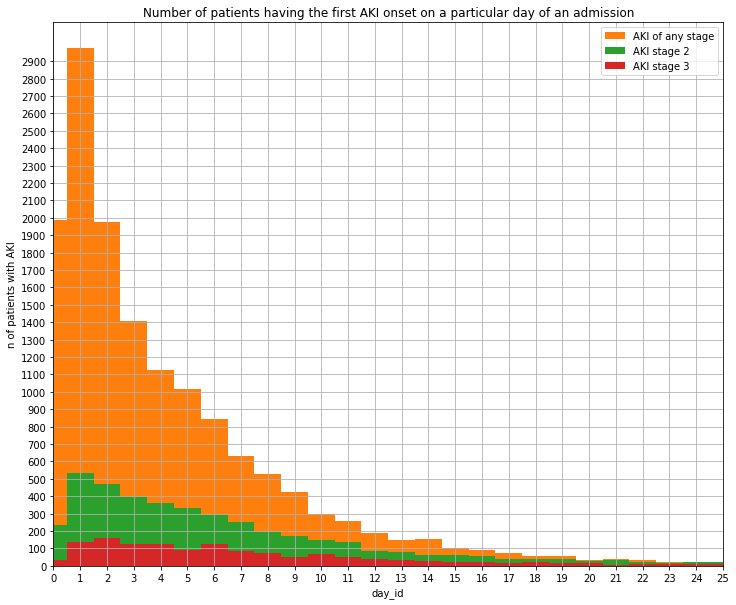

In [52]:
from cProfile import label
from matplotlib import pyplot as plt

g1 = icu_aki_status[icu_aki_status.AKI_1==1].sort_values(['hadm_id', 'day_id'])\
                        .drop_duplicates(['hadm_id'], keep='first')\
                            .groupby('day_id')\
                                .count()
index1 = g1.AKI_1.sort_values(ascending=False).index
values1 = g1.AKI_1.sort_values(ascending=False).values

g2 = icu_aki_status[icu_aki_status.AKI_2==1].sort_values(['hadm_id', 'day_id'])\
                        .drop_duplicates(['hadm_id'], keep='first')\
                            .groupby('day_id')\
                                .count()
index2 = g2.AKI_2.sort_values(ascending=False).index
values2 = g2.AKI_2.sort_values(ascending=False).values

g3 = icu_aki_status[icu_aki_status.AKI_3==1].sort_values(['hadm_id', 'day_id'])\
                        .drop_duplicates(['hadm_id'], keep='first')\
                            .groupby('day_id')\
                                .count()
index3 = g3.AKI_3.sort_values(ascending=False).index
values3 = g3.AKI_3.sort_values(ascending=False).values

fig, (ax2) = plt.subplots(1, 1, figsize=(12, 10), sharex=False) 

ax2.bar(index1, values1, width=1)
ax2.set_xticks(index1)
ax2.set_yticks(np.arange(0, 3000, 100))
ax2.set_xlim([0,25])
ax2.set_xlabel('day_id')
ax2.set_ylabel('n of patients with AKI')
ax2.bar(index1, values1, width=1, label='AKI of any stage')
ax2.bar(index2, values2, width=1, label='AKI stage 2')
ax2.bar(index3, values3, width=1, label='AKI stage 3')
ax2.set_title('Number of patients having the first AKI onset on a particular day of an admission')
ax2.grid(True)
ax2.legend()



length of ICU stay

In [341]:
data_icustays.head(1)

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
0,10000032,29079034,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266


In [400]:
print('n of unique ICU stays with length of stay at least than 2 days: : ', (data_icustays[data_icustays.los>=2].stay_id.unique().shape[0]))

n of unique ICU stays with length of stay at least than 2 days: :  36911


0.0 110.23


Text(0.5, 0.98, 'Length of ICU stay')

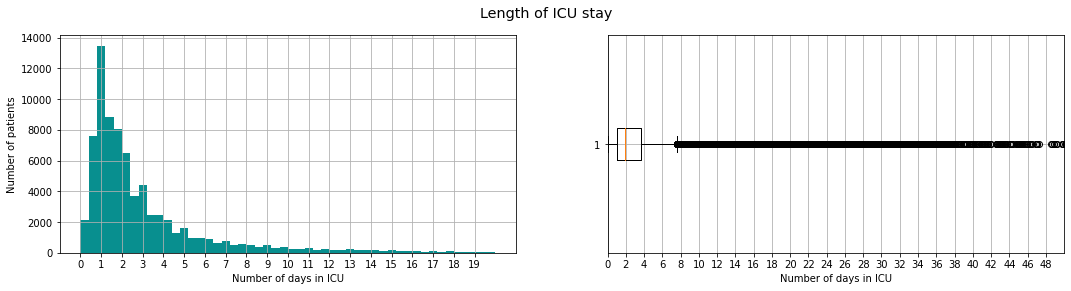

In [399]:
from matplotlib import pyplot as plt

print(np.round(data_icustays.los.min(),2) , np.round(data_icustays.los.max(), 2))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 4), sharex=False)
ax1.hist(data_icustays.los,  bins=50, range=(0,20),histtype ='bar', facecolor='#088F8F')
ax1.set_xticks(np.arange(0, 20))
ax1.set_xlabel('Number of days in ICU')
ax1.set_ylabel('Number of patients')
ax1.grid()

ax2.boxplot(data_icustays.los, vert=False)
ax2.set_xticks(np.arange(0, 50, 2 ))
ax2.set_xlim([0,50])
ax2.set_xlabel('Number of days in ICU')
ax2.grid()

fig.suptitle("Length of ICU stay", fontsize="x-large")

# AKI status for ICU patients

## Get urine output values

In [335]:
with open(PKL_PATH + 'weight_data_icu.pkl', 'rb') as f:
    weight_data_icu = pickle.load(f)
weight_data_icu.head(1)

,subject_id,hadm_id,stay_id,intime,outtime,chartdate,weight_kg,stay_id_f,chartdate_f,weight_kg_f
0,19999442,26785317,32336619.0,2148-11-19 14:23:43,2148-11-26 13:12:15,2148-10-30,103.0,NaN,NaT,NaN


In [44]:
print('itemid | label | value | valueuom | abbreviation | category')
for _, row in data_outputevents[data_outputevents.category=='Output'].drop_duplicates('itemid').iterrows():
    print(f'{row.itemid} | {row.label} | {row.value}  | {row.valueuom} | {row.abbreviation} | {row.category}')

itemid | label | value | valueuom | abbreviation | category
226560 | Void | 175.0  | ml | Void | Output
226559 | Foley | 450.0  | ml | Foley | Output
226633 | Pre-Admission | 400.0  | ml | Pre-Admission | Output
226571 | Emesis | 100.0  | ml | Emesis | Output
226576 | Oral Gastric | 10.0  | ml | Oral Gastric | Output
227510 | TF Residual | 0.0  | ml | TF Residual | Output
226627 | OR Urine | 450.0  | ml | OR Urine | Output
226588 | Chest Tube #1 | 5.0  | ml | Chest Tube #1 | Output
226589 | Chest Tube #2 | 1300.0  | ml | Chest Tube #2 | Output
226626 | OR EBL | 400.0  | ml | OR EBL | Output
226583 | Rectal Tube | 525.0  | ml | Rectal Tube | Output
226579 | Stool | 250.0  | ml | Stool | Output
226580 | Fecal Bag | 300.0  | ml | Fecal Bag | Output
226561 | Condom Cath | 300.0  | ml | Condom Cath | Output
226632 | Cath Lab | 150.0  | ml | Cath Lab | Output
227488 | GU Irrigant Volume In | 3000.0  | ml | GU Irrigant Volume In | Output
227489 | GU Irrigant/Urine Volume Out | 2800.0  | ml | 

In [323]:
urine_output_ids = [226559, 226627, 226561]

In [331]:
urine_output_df = data_outputevents[data_outputevents.itemid.isin(urine_output_ids)].sort_values(['subject_id',	'hadm_id',	'stay_id', 'charttime'])

urine_output_df['icu_6h_window_id'] = urine_output_df['charttime'] - urine_output_df['intime']
urine_output_df['icu_6h_window_id'] = [(d.days*24 + d.seconds//3600)//6 for d in urine_output_df.loc[:, 'icu_6h_window_id']]

In [336]:
sum_urine_output_6h = urine_output_df[['subject_id', 'hadm_id',	'stay_id', 'icu_day_id',  'icu_6h_window_id', 'value']]\
                            .groupby(['subject_id', 'hadm_id', 'stay_id','icu_day_id', 'icu_6h_window_id'])\
                                .agg('sum').reset_index()\
                                    .merge(weight_data_icu[['subject_id', 'hadm_id', 'stay_id', 'weight_kg']]).sort_values(['subject_id','hadm_id','stay_id','icu_6h_window_id'])

sum_urine_output_12h = urine_output_df[['subject_id', 'hadm_id','stay_id', 'icu_day_id', 'icu_12h_window_id', 'value']]\
                            .groupby(['subject_id', 'hadm_id', 'stay_id','icu_day_id', 'icu_12h_window_id'])\
                                .agg('sum')\
                                    .reset_index().merge(weight_data_icu[['subject_id', 'hadm_id', 'stay_id', 'weight_kg']]).sort_values(['subject_id','hadm_id','stay_id','icu_12h_window_id'])
                                    
sum_urine_output_24h = urine_output_df[['subject_id', 'hadm_id','stay_id', 'icu_day_id', 'value']]\
                            .groupby(['subject_id', 'hadm_id', 'stay_id', 'icu_day_id'])\
                                .agg('sum')\
                                    .reset_index().merge(weight_data_icu[['subject_id', 'hadm_id', 'stay_id', 'weight_kg']]).sort_values(['subject_id','hadm_id','stay_id','icu_day_id'])

In [337]:
sum_urine_output_6h['urine_ml_kg_h_6h'] = sum_urine_output_6h['value'] / sum_urine_output_6h['weight_kg'] / 6
sum_urine_output_12h['urine_ml_kg_h_12h'] = sum_urine_output_12h['value'] / sum_urine_output_12h['weight_kg'] / 12
sum_urine_output_24h['urine_ml_kg_h_24h'] = sum_urine_output_24h['value'] / sum_urine_output_24h['weight_kg'] / 24

In [173]:
sum_urine_output_6h

,subject_id,hadm_id,stay_id,icu_day_id,icu_6h_window_id,value,weight_kg,urine_ml_kg_h_6h
0,10000980,26913865,39765666,0,0,2850.0,75.0,6.333333
1,10000980,26913865,39765666,0,1,1050.0,75.0,2.333333
2,10001725,25563031,31205490,0,0,300.0,68.0,0.735294
3,10001725,25563031,31205490,0,1,445.0,68.0,1.090686
4,10001725,25563031,31205490,0,2,610.0,68.0,1.495098
...,...,...,...,...,...,...,...,...
253818,19999442,26785317,32336619,5,23,460.0,103.0,0.744337
253819,19999442,26785317,32336619,6,24,260.0,103.0,0.420712
253820,19999442,26785317,32336619,6,25,500.0,103.0,0.809061
253821,19999442,26785317,32336619,6,26,795.0,103.0,1.286408


In [174]:
sum_urine_output_12h

,subject_id,hadm_id,stay_id,icu_day_id,icu_12h_window_id,value,weight_kg,urine_ml_kg_h_12h
0,10000980,26913865,39765666,0,0,3900.0,75.0,4.333333
1,10001725,25563031,31205490,0,0,745.0,68.0,0.912990
2,10001725,25563031,31205490,0,1,1220.0,68.0,1.495098
3,10001725,25563031,31205490,1,2,700.0,68.0,0.857843
4,10001884,26184834,37510196,0,0,1040.0,64.0,1.354167
...,...,...,...,...,...,...,...,...
136061,19999442,26785317,32336619,4,9,1875.0,103.0,1.516990
136062,19999442,26785317,32336619,5,10,2335.0,103.0,1.889159
136063,19999442,26785317,32336619,5,11,1105.0,103.0,0.894013
136064,19999442,26785317,32336619,6,12,760.0,103.0,0.614887


In [175]:
sum_urine_output_24h

,subject_id,hadm_id,stay_id,icu_day_id,value,weight_kg,urine_ml_kg_h_24h
0,10000980,26913865,39765666,0,3900.0,75.0,2.166667
1,10001725,25563031,31205490,0,1965.0,68.0,1.204044
2,10001725,25563031,31205490,1,700.0,68.0,0.428922
3,10001884,26184834,37510196,0,1560.0,64.0,1.015625
4,10001884,26184834,37510196,1,670.0,64.0,0.436198
...,...,...,...,...,...,...,...
74914,19999442,26785317,32336619,2,3510.0,103.0,1.419903
74915,19999442,26785317,32336619,3,3140.0,103.0,1.270227
74916,19999442,26785317,32336619,4,3475.0,103.0,1.405744
74917,19999442,26785317,32336619,5,3440.0,103.0,1.391586


In [338]:
sum_urine_output_6h['AKI_1'] = (sum_urine_output_6h.urine_ml_kg_h_6h < 0.5).astype(int).values
sum_urine_output_12h['AKI_2'] = (sum_urine_output_12h.urine_ml_kg_h_12h < 0.5).astype(int).values
sum_urine_output_24h['AKI_3'] = (sum_urine_output_24h.urine_ml_kg_h_24h < 0.3).astype(int).values

In [298]:
stay = 38875437
sum_urine_output_6h[sum_urine_output_6h.stay_id==stay]

,subject_id,hadm_id,stay_id,icu_day_id,icu_6h_window_id,value,weight_kg,urine_ml_kg_h_6h
121,10002428,28662225,38875437,0,0,670.0,45.0,2.481481
122,10002428,28662225,38875437,0,1,340.0,45.0,1.259259
123,10002428,28662225,38875437,0,2,255.0,45.0,0.944444
124,10002428,28662225,38875437,0,3,365.0,45.0,1.351852
125,10002428,28662225,38875437,1,4,250.0,45.0,0.925926
126,10002428,28662225,38875437,1,5,265.0,45.0,0.981481
127,10002428,28662225,38875437,1,6,400.0,45.0,1.481481
128,10002428,28662225,38875437,1,7,340.0,45.0,1.259259
129,10002428,28662225,38875437,2,8,230.0,45.0,0.851852
130,10002428,28662225,38875437,2,9,350.0,45.0,1.296296


In [310]:
sum_urine_output_12h[sum_urine_output_12h.stay_id==stay]

,subject_id,hadm_id,stay_id,icu_day_id,icu_12h_window_id,value,weight_kg,urine_ml_kg_h_12h,AKI_2
4,10001884,26184834,37510196,0,0,1040.0,64.0,1.354167,0
5,10001884,26184834,37510196,0,1,520.0,64.0,0.677083,0
6,10001884,26184834,37510196,1,2,405.0,64.0,0.527344,0
7,10001884,26184834,37510196,1,3,265.0,64.0,0.345052,1
8,10001884,26184834,37510196,2,4,308.0,64.0,0.401042,1
9,10001884,26184834,37510196,2,5,410.0,64.0,0.533854,0
10,10001884,26184834,37510196,3,6,610.0,64.0,0.794271,0
11,10001884,26184834,37510196,3,7,640.0,64.0,0.833333,0
12,10001884,26184834,37510196,4,8,560.0,64.0,0.729167,0
13,10001884,26184834,37510196,4,9,540.0,64.0,0.703125,0


In [311]:
sum_urine_output_24h[sum_urine_output_24h.stay_id==stay]

,subject_id,hadm_id,stay_id,icu_day_id,value,weight_kg,urine_ml_kg_h_24h,AKI_3
3,10001884,26184834,37510196,0,1560.0,64.0,1.015625,0
4,10001884,26184834,37510196,1,670.0,64.0,0.436198,0
5,10001884,26184834,37510196,2,718.0,64.0,0.467448,0
6,10001884,26184834,37510196,3,1250.0,64.0,0.813802,0
7,10001884,26184834,37510196,4,1100.0,64.0,0.716146,0
8,10001884,26184834,37510196,5,1005.0,64.0,0.654297,0
9,10001884,26184834,37510196,6,2360.0,64.0,1.536458,0
10,10001884,26184834,37510196,7,1580.0,64.0,1.028646,0
11,10001884,26184834,37510196,8,1465.0,64.0,0.953776,0


In [29]:
print(sum_urine_output_6h.stay_id.unique().shape)
print(sum_urine_output_12h.stay_id.unique().shape)
print(sum_urine_output_24h.stay_id.unique().shape)

(13946,)
(13946,)
(13946,)


In [30]:
data_icustays[data_icustays.hadm_id==28662225]

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
14,10002428,28662225,33987268,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2156-04-12 16:24:18,2156-04-17 15:57:08,4.981134
15,10002428,28662225,38875437,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2156-04-19 18:11:19,2156-04-26 18:58:41,7.032894


## Urine AKI critetia

In [257]:
def get_aki_status_urine_out(stay_id, interval='24'):
    adm_urine_output_6h = sum_urine_output_6h[sum_urine_output_6h.stay_id==stay_id]
    adm_urine_output_12h = sum_urine_output_12h[sum_urine_output_12h.stay_id==stay_id]
    adm_urine_output_24h = sum_urine_output_24h[sum_urine_output_24h.stay_id==stay_id]
    AKI_1_list = []
    AKI_2_list = []
    AKI_3_list = []
    AKI_1_12h_list = []
    AKI_2_12h_list = []
    AKI_3_12h_list = []
    stay_id_list_1 = []
    stay_id_list_2 = []
    #days in icu
    try:
        if interval=='24':
            days = list(adm_urine_output_24h.icu_day_id.unique())
            arranged_days = list(np.arange(0, np.max(days) + 1))
        for day in arranged_days:
            if day in days:
                # i = arranged_days.index(day)
                if sum(adm_urine_output_6h[adm_urine_output_6h.icu_day_id==day].AKI_1.values)>0:
                    AKI_1_list.append(1)
                else:
                    AKI_1_list.append(0)
                if (sum(adm_urine_output_12h[adm_urine_output_12h.icu_day_id==day].AKI_2.values)>0)&(AKI_1_list[day]==True):
                    AKI_2_list.append(1)
                else:
                    AKI_2_list.append(0)
                if (sum(adm_urine_output_24h[adm_urine_output_24h.icu_day_id==day].AKI_3.values)>0)&(AKI_1_list[day]==True):
                    AKI_3_list.append(1)
                else:
                    AKI_3_list.append(0)
            else:
                AKI_1_list.append(0)
                AKI_2_list.append(0)
                AKI_3_list.append(0)
            stay_id_list_1.append(stay_id)
        dict_ = {'stay_id':stay_id_list_1, 'icu_day_id':arranged_days, 'AKI_1_urine':AKI_1_list, 'AKI_2_urine':AKI_2_list, 'AKI_3_urine':AKI_3_list}
        # not correct:
        if interval=='12':
            wind_6h = adm_urine_output_6h.icu_6h_window_id.unique()
            wind_12h = adm_urine_output_12h.icu_12h_window_id.unique()
            day_id_list = []
            for wind in np.arange(np.min(wind_12h), np.max(wind_12h)+1):
                if sum(adm_urine_output_6h[adm_urine_output_6h.icu_6h_window_id.isin(np.arange(wind*2, wind*2+2))].AKI_1.values)>0:
                    AKI_1_12h_list.append(1)
                else:
                    AKI_1_12h_list.append(0)
                if (sum(adm_urine_output_12h[adm_urine_output_12h.icu_12h_window_id==wind].AKI_2.values)>0)&(AKI_1_12h_list[wind]==True):
                    AKI_2_12h_list.append(1)
                else:
                    AKI_2_12h_list.append(0)
                if (sum(adm_urine_output_24h[adm_urine_output_24h.icu_day_id==wind//2].AKI_3.values)>0)&(AKI_1_list[day]==True):
                    AKI_3_12h_list.append(1)
                else:
                    AKI_3_12h_list.append(0)
                day_id_list.appens
                stay_id_list_2.append(wind//2)
            dict_ = {'stay_id':stay_id_list_2, 'icu_day_id':days, 'wind_12h':wind_12h, 'AKI_1_urine':AKI_1_list, 'AKI_2_urine':AKI_2_list, 'AKI_3_urine':AKI_3_list}
        
        return dict_
    except:
        print(stay_id)
        raise
        # errors.append(stay)

### Check

In [143]:
adm_urine_output_24h[adm_urine_output_24h.stay_id==stay_id]

,subject_id,hadm_id,stay_id,icu_day_id,value,weight_kg,urine_ml_kg_h_24h,AKI_3
34017,14591912,23321282,38118624,-1,0.0,48.0,0.0,1


In [50]:
adm_urine_output_12h[adm_urine_output_12h.stay_id==stay_id]

,subject_id,hadm_id,stay_id,icu_day_id,icu_12h_window_id,value,weight_kg,urine_ml_kg_h_12h,AKI_2
123,10003400,23559586,38383343,0,1,130.0,98.0,0.110544,1
124,10003400,23559586,38383343,1,2,295.0,98.0,0.250850,1
125,10003400,23559586,38383343,1,3,404.0,98.0,0.343537,1
126,10003400,23559586,38383343,2,4,750.0,98.0,0.637755,0
127,10003400,23559586,38383343,2,5,890.0,98.0,0.756803,0
128,10003400,23559586,38383343,3,6,1950.0,98.0,1.658163,0
129,10003400,23559586,38383343,3,7,1560.0,98.0,1.326531,0
130,10003400,23559586,38383343,4,8,1845.0,98.0,1.568878,0
131,10003400,23559586,38383343,4,9,1400.0,98.0,1.190476,0
132,10003400,23559586,38383343,5,10,1865.0,98.0,1.585884,0


In [144]:
adm_urine_output_6h[adm_urine_output_6h.stay_id==stay_id]

,subject_id,hadm_id,stay_id,icu_day_id,icu_6h_window_id,value,weight_kg,urine_ml_kg_h_6h,AKI_1
120175,14591912,23321282,38118624,-1,-1,0.0,48.0,0.0,1


In [145]:
urine_output_df[urine_output_df.stay_id==stay_id].sort_values('charttime')

,subject_id,hadm_id,stay_id,charttime,storetime,itemid,value,valueuom,label,abbreviation,...,highnormalvalue,intime,admittime,day_id,_12h_window_id,hour_id,icu_day_id,icu_12h_window_id,icu_hour_id,icu_6h_window_id
4423397,14591912,23321282,38118624,2116-10-28 20:00:00,2116-10-29 07:45:00,226627,0.0,ml,OR Urine,OR Urine,...,NaN,2116-10-28 20:35:08,2116-10-26 02:33:00,2,5,65,-1,-1,-1,-1


In [140]:
stay_id=38118624
adm_urine_output_6h = sum_urine_output_6h[sum_urine_output_6h.stay_id==stay_id]
adm_urine_output_12h = sum_urine_output_12h[sum_urine_output_12h.stay_id==stay_id]
adm_urine_output_24h = sum_urine_output_24h[sum_urine_output_24h.stay_id==stay_id]
AKI_1_list = []
AKI_2_list = []
AKI_3_list = []
AKI_1_12h_list = []
AKI_2_12h_list = []
AKI_3_12h_list = []
stay_id_list_1 = []
stay_id_list_2 = []

days = list(adm_urine_output_24h.icu_day_id.unique())
arranged_days = np.arange(np.min(days), np.max(days) + 1)
for day in arranged_days:
    if day in days:
        # i = arranged_days.index(day)
        if sum(adm_urine_output_6h[adm_urine_output_6h.icu_day_id==day].AKI_1.values)>0:
            AKI_1_list.append(1)
        else:
            AKI_1_list.append(0)
        if (sum(adm_urine_output_12h[adm_urine_output_12h.icu_day_id==day].AKI_2.values)>0)&(AKI_1_list[day]==True):
            AKI_2_list.append(1)
        else:
            AKI_2_list.append(0)
        if (sum(adm_urine_output_24h[adm_urine_output_24h.icu_day_id==day].AKI_3.values)>0)&(AKI_1_list[day]==True):
            AKI_3_list.append(1)
        else:
            AKI_3_list.append(0)
    else:
        AKI_1_list.append(0)
        AKI_2_list.append(0)
        AKI_3_list.append(0)

In [146]:
AKI_1_list

[1]

In [148]:
pd.DataFrame(get_aki_status_urine_out(38118624))

,stay_id,icu_day_id,AKI_1_urine,AKI_2_urine,AKI_3_urine


In [258]:
patients = data_icustays.drop_duplicates(subset=['stay_id'], keep='first').subject_id.unique()
admissions = data_icustays.drop_duplicates(subset=['stay_id'], keep='first').hadm_id.unique()
icu_stays = data_icustays.drop_duplicates(subset=['stay_id'], keep='first').stay_id.unique()
icu_stays_weight_available = sum_urine_output_24h.stay_id.unique()
print('patients: ', len(patients))
print('admissions: ', len(admissions))
print("icu_stays: ", len(icu_stays))
print("icu stays with weight data available: ", len(icu_stays_weight_available))

patients:  28583
admissions:  34189
icu_stays:  36911
icu stays with weight data available:  17868


### Multiprocessing 

In [259]:
%%time
import traceback
import multiprocessing

stays = icu_stays_weight_available
pid_aki_status_urine_icu = pd.DataFrame()
chunk_size = 10000
# chunk_size = 10
n_chunks = len(stays)//chunk_size
# n_chunks = 2
errors = []

for i in range(0,n_chunks+1):
    with multiprocessing.Pool(processes=70) as pool_obj:
        pid_aki_status = pool_obj.map(get_aki_status_urine_out, stays[i*chunk_size:(i+1)*chunk_size])

    for e in pid_aki_status[:]:
        temp = pd.DataFrame(e)
        pid_aki_status_urine_icu = pd.concat([pid_aki_status_urine_icu, temp], ignore_index=True)

    print("Finished {} stays".format((i+1)*chunk_size))

    with open(PKL_PATH + 'pid_aki_status_urine_icu.pkl', 'wb') as f:
        pickle.dump(pid_aki_status_urine_icu, f, protocol=pickle.HIGHEST_PROTOCOL)

Finished 10000 stays
Finished 20000 stays
CPU times: user 14.7 s, sys: 10.7 s, total: 25.4 s
Wall time: 39.8 s


In [260]:
print(pid_aki_status_urine_icu.stay_id.unique().shape)
pid_aki_status_urine_icu.head()

(17864,)


,stay_id,icu_day_id,AKI_1_urine,AKI_2_urine,AKI_3_urine
0,37510196.0,0.0,1.0,0.0,0.0
1,37510196.0,1.0,1.0,1.0,0.0
2,37510196.0,2.0,1.0,1.0,0.0
3,37510196.0,3.0,0.0,0.0,0.0
4,37510196.0,4.0,0.0,0.0,0.0


In [345]:
sum_urine_output_6h[sum_urine_output_6h.stay_id==38875437]

,subject_id,hadm_id,stay_id,icu_day_id,icu_6h_window_id,value,weight_kg,urine_ml_kg_h_6h,AKI_1
121,10002428,28662225,38875437,0,0,670.0,45.0,2.481481,0
122,10002428,28662225,38875437,0,1,340.0,45.0,1.259259,0
123,10002428,28662225,38875437,0,2,255.0,45.0,0.944444,0
124,10002428,28662225,38875437,0,3,365.0,45.0,1.351852,0
125,10002428,28662225,38875437,1,4,250.0,45.0,0.925926,0
126,10002428,28662225,38875437,1,5,265.0,45.0,0.981481,0
127,10002428,28662225,38875437,1,6,400.0,45.0,1.481481,0
128,10002428,28662225,38875437,1,7,340.0,45.0,1.259259,0
129,10002428,28662225,38875437,2,8,230.0,45.0,0.851852,0
130,10002428,28662225,38875437,2,9,350.0,45.0,1.296296,0


In [330]:
sum_urine_output_12h[sum_urine_output_12h.stay_id==37510196]

,subject_id,hadm_id,stay_id,icu_day_id,icu_12h_window_id,value,weight_kg,urine_ml_kg_h_12h,AKI_2
0,10001884,26184834,37510196,0,0,1040.0,69.0,1.256039,0
1,10001884,26184834,37510196,0,1,520.0,69.0,0.628019,0
2,10001884,26184834,37510196,1,2,405.0,69.0,0.489130,1
3,10001884,26184834,37510196,1,3,265.0,69.0,0.320048,1
4,10001884,26184834,37510196,2,4,308.0,69.0,0.371981,1
5,10001884,26184834,37510196,2,5,410.0,69.0,0.495169,1
6,10001884,26184834,37510196,3,6,610.0,69.0,0.736715,0
7,10001884,26184834,37510196,3,7,640.0,69.0,0.772947,0
8,10001884,26184834,37510196,4,8,560.0,69.0,0.676329,0
9,10001884,26184834,37510196,4,9,540.0,69.0,0.652174,0


## Creatinine AKI criteria

In [154]:
data_icustays.describe()

,subject_id,hadm_id,stay_id,los
count,3.691100e+04,3.691100e+04,3.691100e+04,36911.000000
mean,1.498745e+07,2.499213e+07,3.497899e+07,5.961949
std,2.882582e+06,2.884057e+06,2.888597e+06,6.183397
min,1.000188e+07,2.000081e+07,3.000048e+07,2.000081
25%,1.249076e+07,2.250191e+07,3.247262e+07,2.705098
50%,1.498438e+07,2.500443e+07,3.496256e+07,3.840208
75%,1.748128e+07,2.747764e+07,3.747202e+07,6.605885
max,1.999984e+07,2.999962e+07,3.999981e+07,110.232280


In [153]:
# function for calculating AKI status for each day of an admission
print_on = False
def get_aki_status(admission):
    try:
        adm_labs = labevents_creatinine[(labevents_creatinine.hadm_id==admission)].sort_values('day_id')
        if len(adm_labs)<1:
            print('no Scr values available for', admission)
            return
        patient = data_admissions[data_admissions.hadm_id==admission].subject_id.values[0]
        # admittime = data_admissions[data_admissions.hadm_id==admission].admittime
        days = adm_labs.day_id.values.tolist()
        hadm_ids = []
        aki_status = {'AKI_1':[], 'AKI_2':[], 'AKI_3':[]}
        AKI_1 = False
        AKI_2 = False
        AKI_3 = False
        specimen_ids = []

        all_days = np.arange(np.min(days), np.max(days)+1)

        for day in all_days:
            hadm_ids.append(admission)
            if day not in days:
                if print_on:
                    print(f'day {day} - no SCr')
                    print(f'AKI_1  [{int(False)}], AKI_2 [{int(False)}], AKI_3 [{int(False)}]')
                    print('----------------')
                aki_status['AKI_1'].append(int(AKI_1))
                aki_status['AKI_2'].append(int(AKI_2))
                aki_status['AKI_3'].append(int(AKI_3))
                specimen_ids.append(None)
                continue
            
            row_creatinine = adm_labs[adm_labs.day_id==day].sort_values('valuenum', ascending=False)
            C1 = float(row_creatinine.valuenum.values[0])
            charttime = row_creatinine.charttime.values[0]
            specimen_id = row_creatinine.specimen_id.values[0]
            
            if print_on:
                print(f'day {day} creatinine {C1}')
            
            df_baseline_1 = adm_labs[(adm_labs.charttime + np.timedelta64(24*7, 'h') >= charttime) \
                                            & (adm_labs.charttime < charttime)]

            df_median_baseline = labevents_creatinine[(labevents_creatinine.subject_id==patient)\
                                            &(labevents_creatinine.charttime + np.timedelta64(365, 'D') >= charttime) \
                                                & (labevents_creatinine.charttime < charttime)]

            df_baseline_2 = adm_labs[(adm_labs.charttime + np.timedelta64(48, 'h') >= charttime) \
                                            & (adm_labs.charttime < charttime)]
            # get baselines values
            if len(df_baseline_1) > 0:
                scr_baseline_1 = np.min(df_baseline_1.valuenum.values)

            elif len(df_median_baseline):
                scr_baseline_1 = np.median(df_median_baseline.valuenum.values)
            else:
                scr_baseline_1 = None

            if len(df_baseline_2) > 0:
                scr_baseline_2 = np.min(df_baseline_2.valuenum.values) #.sort_values('value', ascending=True).value.values[0]
            else:
                scr_baseline_2 = None
            if print_on:
                # print(f' baseline1 = {scr_baseline_1}, baseline2 = {scr_baseline_2}')
                print('baseline_1', scr_baseline_1)
                print('baseline_2', scr_baseline_2)
            # calculate aki
            if C1 >= 4.0:
                AKI_3 = True
                AKI_2 = True
                AKI_1 = True
            elif (scr_baseline_1 is not None):
                RV = np.round(C1 / scr_baseline_1, 2)
                if print_on:
                    print(f'RV = {C1} / {scr_baseline_1} = {RV}')
                if (RV >= 1.5):
                    if RV >=3.0:
                        AKI_3 = True
                        AKI_2 = True
                        AKI_1 = True
                    elif 3.0 > RV >=2.0:
                        AKI_3 = False
                        AKI_2 = True
                        AKI_1 = True
                    elif 2.0 > RV >= 1.5:
                        AKI_3 = False
                        AKI_2 = False
                        AKI_1 = True
                elif  (scr_baseline_2 is not None):
                    if (C1 - scr_baseline_2 > 0.29):
                        AKI_3 = False
                        AKI_2 = False
                        AKI_1 = True
                    else:
                        AKI_3 = False
                        AKI_2 = False
                        AKI_1 = False
                else:
                    AKI_3 = False
                    AKI_2 = False
                    AKI_1 = False
            elif (scr_baseline_2 is not None):
                if (C1 - scr_baseline_2 > 0.29):    
                        AKI_1 = False
                        AKI_2 = False
                        AKI_1 = True
            else:
                AKI_1 = False
                AKI_2 = False
                AKI_3 = False

            specimen_ids.append(specimen_id)
           
            aki_status['AKI_1'].append(int(AKI_1))
            aki_status['AKI_2'].append(int(AKI_2))
            aki_status['AKI_3'].append(int(AKI_3))

            if print_on:
                print(f'AKI_1  [{int(AKI_1)}], AKI_2 [{int(AKI_2)}], AKI_3 [{int(AKI_3)}]')
                print('----------------')
    except:
        print(admission)
        # raise

    return {'hadm_id':hadm_ids, 'specimen_id':specimen_ids, 'day_id':all_days, 'AKI_1':aki_status['AKI_1'], 'AKI_2':aki_status['AKI_2'], 'AKI_3':aki_status['AKI_3']}

In [86]:
data_icustays.head(1)

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
0,17867402,24528534,31793211,Trauma SICU (TSICU),Trauma SICU (TSICU),2154-03-03 04:11:00,2154-03-04 18:16:56,1.587454


In [96]:
labevents_creatinine.head(1)

,subject_id,hadm_id,charttime,value,valueuom,admittime,day_id
9,10003299,21476780,2183-02-26 22:18:00,1.1,mg/dL,2183-02-27 15:18:00,-1.0


In [98]:
data_d_items.head(1)

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,220003,ICU Admission date,ICU Admission date,datetimeevents,ADT,NaN,Date and time,NaN,NaN


In [16]:
patients = data_icustays.drop_duplicates(subset=['stay_id'], keep='first').subject_id.unique()
admissions = data_icustays.drop_duplicates(subset=['stay_id'], keep='first').hadm_id.unique()
icu_stays = data_icustays.drop_duplicates(subset=['stay_id'], keep='first').stay_id.unique()
print('patients: ', len(patients))
print('admissions: ', len(admissions))
print("icu_stays: ", len(icu_stays))
print('n of unique ICU stays with length of stay at least than 2 days: : ', (data_icustays[data_icustays.los>=2].stay_id.unique().shape[0]))


patients:  53569
admissions:  69639
icu_stays:  76943
n of unique ICU stays with length of stay at least than 2 days: :  36911


In [20]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    #return lst3
    return lst3

In [21]:
scr_counts = labevents_creatinine.groupby('hadm_id').count().sort_values('subject_id')
admissions_with_2_scr_tests = scr_counts[scr_counts.subject_id > 1].reset_index().hadm_id.unique()
icu_admissions_with_2_scr_tests = intersection(admissions, admissions_with_2_scr_tests)
icu_admissions_with_2_scr_tests_and_2_days_in_icu = intersection(icu_admissions_with_2_scr_tests, list(data_icustays[data_icustays.los>=2].hadm_id.unique()))
print('n of admissions with at least 2 SCr measurements and at least 2 days in ICU: ', len(icu_admissions_with_2_scr_temps_and_2_days_in_icu))

n of admissions with at least 2 SCr measurements and at least 2 days in ICU:  33996


In [402]:
labevents_creatinine[labevents_creatinine.hadm_id==24033632]

,subject_id,hadm_id,specimen_id,itemid,charttime,valuenum,valueuom,flag,label,fluid,category,admittime,dischtime,day_id,_12h_window_id,hour_id


In [407]:
labevents[labevents.hadm_id==24033632]

,subject_id,hadm_id,specimen_id,itemid,charttime,valuenum,valueuom,flag,label,fluid,category,admittime,dischtime


In [338]:
data_admissions[data_admissions.hadm_id==28623837]

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
222,10003700,28623837,2165-04-24 04:59:00,2165-04-26 22:34:00,NaN,EW EMER.,EMERGENCY ROOM,PSYCH FACILITY,Other,ENGLISH,SINGLE,WHITE,2165-04-24 03:00:00,2165-04-24 05:43:00,0


In [409]:
data_icustays[data_icustays.hadm_id==28623837]

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
30,10003700,28623837,30600691,Trauma SICU (TSICU),Trauma SICU (TSICU),2165-04-24 05:43:00,2165-04-24 09:13:20,0.146065


In [451]:
%%time
pid_aki_status = []
errors = []
i = 0
for adm in icu_admissions_with_2_scr_tests_and_2_days_in_icu:
    if i % 100==0:
        print(f'------ {i}/{len(icu_admissions_with_2_scr_temps_and_2_days_in_icu)} admissions finished ------')
    try:
        pid_aki_status.append(get_aki_status(adm))
    except:
        print(adm)
        errors.add(adm)
    i += 1

In [30]:
%%time
import traceback
import multiprocessing

admissions = icu_admissions_with_2_scr_tests_and_2_days_in_icu
final_aki_status_icu = pd.DataFrame()
chunk_size = 5000
n_chunks = len(admissions)//chunk_size
errors = []

for i in range(0,n_chunks+1):
    with multiprocessing.Pool(processes=80) as pool_obj:
        pid_aki_status = pool_obj.map(get_aki_status, admissions[i*chunk_size:(i+1)*chunk_size])

    for e in pid_aki_status[:]:
        temp = pd.DataFrame(e)
        final_aki_status_icu = pd.concat([final_aki_status_icu, temp], ignore_index=True)

    print("Finished {} admissions".format((i+1)*chunk_size))

    with open(PKL_PATH + 'final_aki_status_icu.pkl', 'wb') as f:
        pickle.dump(final_aki_status_icu, f, protocol=pickle.HIGHEST_PROTOCOL)

/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in double_scalars
/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in double_scalars
/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in double_scalars
/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in double_scalars


Finished 5000 admissions


/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in double_scalars
/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in double_scalars
/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in double_scalars
/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in double_scalars
/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in double_scalars


Finished 10000 admissions


/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in double_scalars
/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in double_scalars
/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in double_scalars


Finished 15000 admissions


/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in double_scalars
/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in double_scalars
/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in double_scalars
/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in double_scalars
/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in double_scalars
/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in double_scalars
/home/svetlanamaslenkova/anac

Finished 20000 admissions


/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in double_scalars
/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in double_scalars
/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in double_scalars
/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in double_scalars
/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in double_scalars
/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in double_scalars


Finished 25000 admissions


/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in double_scalars
/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in double_scalars
/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in double_scalars
/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in double_scalars
/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in double_scalars
/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in double_scalars
/home/svetlanamaslenkova/anac

Finished 30000 admissions


/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in double_scalars
/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in double_scalars
/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in double_scalars


Finished 35000 admissions
CPU times: user 2min 40s, sys: 1min 18s, total: 3min 59s
Wall time: 1h 8min 53s


In [37]:
final_aki_status_icu[final_aki_status_icu.AKI_3==1].sort_values(['hadm_id', 'day_id']).drop_duplicates('hadm_id', keep='first')

,hadm_id,specimen_id,day_id,AKI_1,AKI_2,AKI_3
201195,20001361,8492551.0,1,1,1,1
21265,20001729,4840732.0,12,1,1,1
403574,20005119,45733489.0,14,1,1,1
255100,20009550,2053214.0,1,1,1,1
344354,20014219,79847429.0,4,1,1,1
...,...,...,...,...,...,...
354254,29992506,46901000.0,4,1,1,1
95268,29993312,24056227.0,0,1,1,1
57048,29994261,18609143.0,0,1,1,1
11006,29994296,6635379.0,11,1,1,1


## Combine two criterias

Filter stays:

In [261]:
data_icustays = data_icustays[data_icustays.los>=2].sort_values(['subject_id', 'hadm_id', 'stay_id'])
print(data_icustays.shape)
data_icustays.head(1)

(36911, 8)


,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
5,10001884,26184834,37510196,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2131-01-11 04:20:05,2131-01-20 08:27:30,9.171817


Merge createnine AKI status with labevents to get icu_day_id:

In [873]:
with open(PKL_PATH + 'final_aki_status_icu.pkl', 'rb') as f:
    final_aki_status_icu = pickle.load(f)
final_aki_status_icu.rename(columns={'AKI_1':'AKI_1_scr', 'AKI_2':'AKI_2_scr', 'AKI_3':'AKI_3_scr'}, inplace=True)

In [874]:
final_aki_status_icu.head(1)

,hadm_id,specimen_id,day_id,AKI_1_scr,AKI_2_scr,AKI_3_scr
0,26184834,64282020.0,0,0,0,0


In [159]:
labevents.head(1)

,subject_id,hadm_id,specimen_id,itemid,charttime,valuenum,valueuom,flag,label,fluid,category,admittime,dischtime
0,10000032,22595853,5305050,51237,2180-05-07 05:05:00,1.5,,abnormal,inr(pt),Blood,Hematology,2180-05-06 22:23:00,2180-05-07 17:15:00


In [877]:
# merge labevents with icu_stays to get icu stay column
L = labevents.merge(data_icustays[['subject_id', 'hadm_id',	'stay_id', 'intime', 'outtime']]).sort_values(['subject_id', 'hadm_id', 'charttime'])
# remove wrong rows with inconsistency between intime, outtime and charttime
L = L[(L.charttime > L.intime)&(L.charttime < L.outtime)]
# get day ids for starting from admittime and intime
L['day_id'] = L['charttime'] - L['admittime']
L['day_id'] = [d.days for d in L.loc[:, 'day_id']]
L['icu_day_id'] = L['charttime'] - L['intime']
L['icu_day_id'] = [d.days for d in L.loc[:, 'icu_day_id']]

In [878]:
final_aki_status_icu = final_aki_status_icu.merge(L[['specimen_id','icu_day_id', 'charttime', 'stay_id']], how='inner', on=['specimen_id']).drop_duplicates()
print(f'Number of unique admissions: ', final_aki_status_icu.hadm_id.unique().shape[0])
print(f'Shape: ', final_aki_status_icu.shape)
final_aki_status_icu.head()

Number of unique admissions:  33983
Shape:  (216769, 9)


,hadm_id,specimen_id,day_id,AKI_1_scr,AKI_2_scr,AKI_3_scr,icu_day_id,charttime,stay_id
0,26184834,5964265.0,4,0,0,0,0,2131-01-12 03:34:00,37510196
10,26184834,31483151.0,5,1,0,0,2,2131-01-13 08:23:00,37510196
19,26184834,70139371.0,6,0,0,0,2,2131-01-14 03:08:00,37510196
29,26184834,25469252.0,7,0,0,0,3,2131-01-15 02:30:00,37510196
40,26184834,71444952.0,8,0,0,0,4,2131-01-16 04:02:00,37510196


In [164]:
# patients with multiple icu stays
data_icustays[data_icustays.duplicated(subset=['subject_id', 'hadm_id'])]

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
15,10002428,28662225,38875437,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2156-04-19 18:11:19,2156-04-26 18:58:41,7.032894
28,10003400,23559586,38383343,Coronary Care Unit (CCU),Medical Intensive Care Unit (MICU),2137-08-17 17:36:37,2137-09-02 19:17:11,16.069838
87,10011849,20188892,36637825,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2185-09-30 11:25:30,2185-10-08 23:54:38,8.520231
108,10013569,27993048,39673498,Coronary Care Unit (CCU),Coronary Care Unit (CCU),2167-12-10 18:23:25,2167-12-18 18:16:14,7.995012
171,10020740,23831430,35026312,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2150-03-11 15:34:56,2150-03-19 02:17:47,7.446424
...,...,...,...,...,...,...,...,...
76780,19982539,23136520,31123584,Neuro Intermediate,Neuro Intermediate,2175-04-23 13:28:52,2175-05-13 10:22:21,19.870475
76819,19986715,28333468,39855146,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2150-11-29 03:59:00,2150-12-09 17:56:59,10.581933
76909,19997293,20208898,38350444,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2123-10-20 02:05:01,2123-10-30 15:34:17,10.561991
76918,19997473,27787494,32568753,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),2173-09-13 20:10:50,2173-09-17 11:37:50,3.643750


Merge urine AKI status with icu_stays to get hadm_id:

In [886]:
with open(PKL_PATH + 'pid_aki_status_urine_icu.pkl', 'rb') as f:
    pid_aki_status_urine_icu = pickle.load(f)

pid_aki_status_urine_icu.rename(columns={'day_id':'icu_day_id'}, inplace=True)
pid_aki_status_urine_icu = pid_aki_status_urine_icu.merge(data_icustays[['hadm_id', 'stay_id']], on='stay_id', how='left')

print(f'Number of unique ICU stays: ', pid_aki_status_urine_icu.stay_id.unique().shape[0])
print(f'Number of unique admissions: ', pid_aki_status_urine_icu.hadm_id.unique().shape[0])
print(f'Shape: ', pid_aki_status_urine_icu.shape)
pid_aki_status_urine_icu.head()

Number of unique ICU stays:  17864
Number of unique admissions:  16569
Shape:  (102627, 6)


,stay_id,icu_day_id,AKI_1_urine,AKI_2_urine,AKI_3_urine,hadm_id
0,37510196.0,0.0,1.0,0.0,0.0,26184834
1,37510196.0,1.0,1.0,1.0,0.0,26184834
2,37510196.0,2.0,1.0,1.0,0.0,26184834
3,37510196.0,3.0,0.0,0.0,0.0,26184834
4,37510196.0,4.0,0.0,0.0,0.0,26184834


Merge two criterias on icu_day_id:

In [887]:
aki_status_icu = final_aki_status_icu.merge(pid_aki_status_urine_icu, on=['hadm_id', 'icu_day_id'], how='left').sort_values(['hadm_id', 'day_id', 'icu_day_id'])
aki_status_icu

,hadm_id,specimen_id,day_id,AKI_1_scr,AKI_2_scr,AKI_3_scr,icu_day_id,charttime,stay_id_x,stay_id_y,AKI_1_urine,AKI_2_urine,AKI_3_urine
156118,20000808,72303623.0,0,0,0,0,0,2180-01-13 04:00:00,35191063,30610654.0,0.0,0.0,0.0
156119,20000808,63232011.0,5,0,0,0,0,2180-01-18 01:54:00,30610654,30610654.0,0.0,0.0,0.0
156120,20000808,72894600.0,6,0,0,0,1,2180-01-19 03:36:00,30610654,30610654.0,1.0,0.0,0.0
137997,20001305,90355490.0,0,0,0,0,0,2178-03-25 13:45:00,36916968,36916968.0,1.0,1.0,1.0
137998,20001305,92318652.0,1,1,0,0,1,2178-03-27 02:12:00,36916968,36916968.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8099,29999625,93541889.0,17,0,0,0,17,2157-11-25 09:48:00,36975675,NaN,NaN,NaN,NaN
8100,29999625,43309251.0,18,0,0,0,18,2157-11-26 07:05:00,36975675,NaN,NaN,NaN,NaN
8101,29999625,73696493.0,19,0,0,0,19,2157-11-27 06:15:00,36975675,NaN,NaN,NaN,NaN
8102,29999625,77141158.0,20,0,0,0,20,2157-11-28 06:38:00,36975675,NaN,NaN,NaN,NaN


Filter out rows without stay_id:

In [888]:
aki_status_icu = aki_status_icu[~(aki_status_icu.stay_id_x.isna())].rename(columns={'stay_id_x':'stay_id'}).drop(columns=['stay_id_y'])

In [882]:
aki_status_icu.isna().sum()

hadm_id             0
specimen_id         0
day_id              0
AKI_1_scr           0
AKI_2_scr           0
AKI_3_scr           0
icu_day_id          0
charttime           0
stay_id             0
AKI_1_urine    117247
AKI_2_urine    117247
AKI_3_urine    117247
dtype: int64

Add urine criteria to SCr criteria:

In [889]:
aki_status_icu = aki_status_icu.fillna(0)

In [890]:
aki_status_icu['AKI_1'] = (aki_status_icu['AKI_1_scr'] + aki_status_icu['AKI_1_urine']).astype(bool).astype(int)
aki_status_icu['AKI_2'] = (aki_status_icu['AKI_2_scr'] + aki_status_icu['AKI_2_urine']).astype(bool).astype(int)
aki_status_icu['AKI_3'] = (aki_status_icu['AKI_3_scr'] + aki_status_icu['AKI_3_urine']).astype(bool).astype(int)

In [891]:
print('Rows with positive AKI: ')
print('AKI_1 SCr:', aki_status_icu[aki_status_icu.AKI_1_scr==1].shape[0], 'Urine: ', aki_status_icu[aki_status_icu.AKI_1_urine==1].shape[0], 'Both: ', aki_status_icu[aki_status_icu.AKI_1==1].shape[0])
print('AKI_2 SCr:', aki_status_icu[aki_status_icu.AKI_2_scr==1].shape[0], 'Urine: ', aki_status_icu[aki_status_icu.AKI_2_urine==1].shape[0], 'Both: ', aki_status_icu[aki_status_icu.AKI_2==1].shape[0])
print('AKI_3 SCr:', aki_status_icu[aki_status_icu.AKI_3_scr==1].shape[0], 'Urine: ', aki_status_icu[aki_status_icu.AKI_3_scr==1].shape[0], 'Both: ', aki_status_icu[aki_status_icu.AKI_3==1].shape[0])

Rows with positive AKI: 
AKI_1 SCr: 69829 Urine:  50646 Both:  100123
AKI_2 SCr: 32173 Urine:  35028 Both:  59061
AKI_3 SCr: 20191 Urine:  20191 Both:  30970


In [892]:
print('ICU Stays with positive AKI: ')
print('AKI_1 SCr:', aki_status_icu[aki_status_icu.AKI_1_scr==1].stay_id.unique().shape[0], 'Urine: ', aki_status_icu[aki_status_icu.AKI_1_urine==1].stay_id.unique().shape[0], 'Both: ', aki_status_icu[aki_status_icu.AKI_1==1].stay_id.unique().shape[0])
print('AKI_2 SCr:', aki_status_icu[aki_status_icu.AKI_2_scr==1].stay_id.unique().shape[0], 'Urine: ', aki_status_icu[aki_status_icu.AKI_2_urine==1].stay_id.unique().shape[0], 'Both: ', aki_status_icu[aki_status_icu.AKI_2==1].stay_id.unique().shape[0])
print('AKI_3 SCr:', aki_status_icu[aki_status_icu.AKI_3_scr==1].stay_id.unique().shape[0], 'Urine: ', aki_status_icu[aki_status_icu.AKI_3_scr==1].stay_id.unique().shape[0], 'Both: ', aki_status_icu[aki_status_icu.AKI_3==1].stay_id.unique().shape[0])

ICU Stays with positive AKI: 
AKI_1 SCr: 18081 Urine:  14780 Both:  24719
AKI_2 SCr: 8180 Urine:  11455 Both:  16257
AKI_3 SCr: 5229 Urine:  5229 Both:  8722


In [893]:
aki_status_icu = aki_status_icu.merge(data_icustays[['subject_id', 'hadm_id', 'stay_id', 'intime']])

In [896]:
aki_status_icu.isna().sum()

hadm_id        0
specimen_id    0
day_id         0
AKI_1_scr      0
AKI_2_scr      0
AKI_3_scr      0
icu_day_id     0
charttime      0
stay_id        0
AKI_1_urine    0
AKI_2_urine    0
AKI_3_urine    0
AKI_1          0
AKI_2          0
AKI_3          0
subject_id     0
intime         0
dtype: int64

In [86]:
aki_status_icu['icu_day_id'] = aki_status_icu['charttime'] - aki_status_icu['intime']
aki_status_icu['icu_day_id'] = [d.days for d in aki_status_icu.loc[:, 'icu_day_id']]

aki_status_icu['icu_12h_window_id'] = aki_status_icu['charttime'] - aki_status_icu['intime']
aki_status_icu['icu_12h_window_id'] = [(d.days*24 + d.seconds//3600)//12 for d in aki_status_icu.loc[:, 'icu_12h_window_id']]

In [898]:
# aki_status_icu = aki_status_icu[['subject_id', 'hadm_id', 'stay_id', 'specimen_id', 'day_id', 'icu_day_id', 'icu_12h_window_id', 'charttime', 'intime', 'AKI_1_scr',	'AKI_2_scr',	'AKI_3_scr', 'AKI_1_urine',	'AKI_2_urine',	'AKI_3_urine',	'AKI_1',	'AKI_2',	'AKI_3']]
aki_status_icu = aki_status_icu[['subject_id', 'hadm_id', 'stay_id', 'specimen_id', 'day_id', 'icu_day_id',  'charttime', 'intime', 'AKI_1_scr',	'AKI_2_scr',	'AKI_3_scr', 'AKI_1_urine',	'AKI_2_urine',	'AKI_3_urine',	'AKI_1',	'AKI_2',	'AKI_3']]

In [899]:
aki_status_icu.head()

,subject_id,hadm_id,stay_id,specimen_id,day_id,icu_day_id,charttime,intime,AKI_1_scr,AKI_2_scr,AKI_3_scr,AKI_1_urine,AKI_2_urine,AKI_3_urine,AKI_1,AKI_2,AKI_3
0,16788749,20000808,35191063,72303623.0,0,0,2180-01-13 04:00:00,2180-01-12 22:07:00,0,0,0,0.0,0.0,0.0,0,0,0
1,16788749,20000808,30610654,63232011.0,5,0,2180-01-18 01:54:00,2180-01-17 19:32:10,0,0,0,0.0,0.0,0.0,0,0,0
2,16788749,20000808,30610654,72894600.0,6,1,2180-01-19 03:36:00,2180-01-17 19:32:10,0,0,0,1.0,0.0,0.0,1,0,0
3,16003661,20001305,36916968,90355490.0,0,0,2178-03-25 13:45:00,2178-03-25 02:59:09,0,0,0,1.0,1.0,1.0,1,1,1
4,16003661,20001305,36916968,92318652.0,1,1,2178-03-27 02:12:00,2178-03-25 02:59:09,1,0,0,1.0,1.0,1.0,1,1,1


Save

In [90]:
with open(PKL_PATH + 'aki_status_icu.pkl', 'wb') as f:
    pickle.dump(aki_status_icu, f, protocol=pickle.HIGHEST_PROTOCOL)

# Filtering admissions and stays

### Filter out admissions with AKI diagnoses and no AKI found by criterias:

In [192]:
# icd codes for AKI
AKI_icd = list(data_d_icd_diagnoses[(data_d_icd_diagnoses.long_title.str.contains('acute'))\
                & (data_d_icd_diagnoses.long_title.str.contains('kidney'))\
                    & (data_d_icd_diagnoses.long_title.str.contains(('|').join(['failure', 'injury'])))\
                        |(data_d_icd_diagnoses.icd_code.str.contains('N17'))\
                            |(data_d_icd_diagnoses.icd_code.str.contains('^584'))]\
                        .icd_code.values)

print(AKI_icd)

['5845', '5846', '5847', '5848', '5849', 'N17', 'N170', 'N171', 'N172', 'N178', 'N179', 'N990', 'O904']


In [193]:
# admissions with AKI icd code 
aki_admissions = list(data_diagnoses[data_diagnoses.icd_code.isin(AKI_icd)].hadm_id.unique())
print(len(aki_admissions))


56486


In [296]:
g = aki_status_icu.groupby('hadm_id')
g = pd.DataFrame(g.sum().AKI_1==0).reset_index()
neg_by_criteria_adms = g[g.AKI_1==True].hadm_id.unique()
print(f'n admissions with no AKI found by criterias: ', len(neg_by_criteria_adms))

pos_by_criteris_adms = aki_status_icu[(aki_status_icu.AKI_1==1)].hadm_id.unique()
print(f'n admissions with AKI found by criterias: ', len(pos_by_criteris_adms))

print(f'total adms with AKI status available: ', aki_status_icu.hadm_id.unique().shape[0])
print(f'total stays with AKI status available: ', aki_status_icu.stay_id.unique().shape[0])

n admissions with no AKI found by criterias:  13792
n admissions with AKI found by criterias:  20184
total adms with AKI status available:  33976
total stays with AKI status available:  36683


In [297]:
fn_adms = aki_status_icu[(aki_status_icu.hadm_id.isin(aki_admissions))&(aki_status_icu.hadm_id.isin(neg_by_criteria_adms))].hadm_id.unique()
fn_stays = aki_status_icu[(aki_status_icu.hadm_id.isin(aki_admissions))&(aki_status_icu.hadm_id.isin(neg_by_criteria_adms))].stay_id.unique()
print(f'(FN) admissions with AKI diagnoses and no AKI found by criterias: ',fn_adms.shape[0], ', stays: ', fn_stays.shape[0])
tn_adms = aki_status_icu[(~(aki_status_icu.hadm_id.isin(aki_admissions)))&(aki_status_icu.hadm_id.isin(neg_by_criteria_adms))].hadm_id.unique()
tn_stays = aki_status_icu[(~(aki_status_icu.hadm_id.isin(aki_admissions)))&(aki_status_icu.hadm_id.isin(neg_by_criteria_adms))].stay_id.unique()
print(f'(TN) admissions with no AKI diagnoses and no AKI found by criterias: ',tn_adms.shape[0], ', stays: ', tn_stays.shape[0])

fp_adms = aki_status_icu[(~(aki_status_icu.hadm_id.isin(aki_admissions)))&(aki_status_icu.hadm_id.isin(pos_by_criteris_adms))].hadm_id.unique()
fp_stays = aki_status_icu[(~(aki_status_icu.hadm_id.isin(aki_admissions)))&(aki_status_icu.hadm_id.isin(pos_by_criteris_adms))].stay_id.unique()
print(f'(FP) admissions with no AKI diagnoses and AKI found by criterias: ',fp_adms.shape[0], ', stays: ', fp_stays.shape[0])
tp_adms = aki_status_icu[((aki_status_icu.hadm_id.isin(aki_admissions)))&(aki_status_icu.hadm_id.isin(pos_by_criteris_adms))].hadm_id.unique()
tp_stays = aki_status_icu[((aki_status_icu.hadm_id.isin(aki_admissions)))&(aki_status_icu.hadm_id.isin(pos_by_criteris_adms))].stay_id.unique()
print(f'(TP) admissions with  AKI diagnoses and AKI found by criterias: ',tp_adms.shape[0], ', stays: ', tp_stays.shape[0])

print(f'total admissions: {len(fn_adms)+len(tn_adms)+len(fp_adms)+len(tp_adms)}, stays: {len(fn_stays)+len(tn_stays)+len(fp_stays)+len(tp_stays)}')

(FN) admissions with AKI diagnoses and no AKI found by criterias:  2521 , stays:  2592
(TN) admissions with no AKI diagnoses and no AKI found by criterias:  11271 , stays:  11532
(FP) admissions with no AKI diagnoses and AKI found by criterias:  10357 , stays:  11242
(TP) admissions with  AKI diagnoses and AKI found by criterias:  9827 , stays:  11317
total admissions: 33976, stays: 36683


### Filter out patientrs with abnormal createnine on the fisrt day:

First day of an admission:

In [214]:
F = labevents_creatinine.sort_values(['subject_id', 'hadm_id', 'charttime'], ascending=True).drop_duplicates('hadm_id', keep='first')
normal_first_scr_adms = list(F[F.flag==''].hadm_id.unique())
len(normal_first_scr_adms)

251934

In [219]:
data_icustays.head(3)

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
0,10000032,29079034,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266
1,10000980,26913865,39765666,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2189-06-27 08:42:00,2189-06-27 20:38:27,0.497535
2,10001217,24597018,37067082,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032


In [221]:
labevents_creatinine[labevents_creatinine.hadm_id==24597018].sort_values(['subject_id', 'hadm_id', 'charttime'], ascending=True)

,subject_id,hadm_id,specimen_id,itemid,charttime,valuenum,valueuom,flag,label,fluid,category,admittime,dischtime,day_id,_12h_window_id,hour_id
1398,10001217,24597018,26068577,50912,2157-11-20 08:14:00,0.7,mg/dL,,creatinine,Blood,Chemistry,2157-11-18 22:56:00,2157-11-25 18:00:00,1,2,33
1399,10001217,24597018,99422457,50912,2157-11-20 13:30:00,0.6,mg/dL,,creatinine,Blood,Chemistry,2157-11-18 22:56:00,2157-11-25 18:00:00,1,3,38
1400,10001217,24597018,44183783,50912,2157-11-21 03:16:00,0.4,mg/dL,,creatinine,Blood,Chemistry,2157-11-18 22:56:00,2157-11-25 18:00:00,2,4,52
1401,10001217,24597018,37412204,50912,2157-11-22 06:20:00,0.4,mg/dL,,creatinine,Blood,Chemistry,2157-11-18 22:56:00,2157-11-25 18:00:00,3,6,79
1402,10001217,24597018,34718563,50912,2157-11-23 04:58:00,0.5,mg/dL,,creatinine,Blood,Chemistry,2157-11-18 22:56:00,2157-11-25 18:00:00,4,8,102
1403,10001217,24597018,29433671,50912,2157-11-24 06:58:00,0.4,mg/dL,,creatinine,Blood,Chemistry,2157-11-18 22:56:00,2157-11-25 18:00:00,5,10,128


In [200]:
# Stays and admissions with available AKI status and first SCr test result - normal
normal_scr_adms = aki_status_icu[aki_status_icu.hadm_id.isin(normal_first_scr_adms)].hadm_id.unique()
normal_scr_stays = aki_status_icu[aki_status_icu.hadm_id.isin(normal_first_scr_adms)].stay_id.unique()

In [201]:
print(f'\nn admissions with available AKI status and first creatinine measurement==normal: ', len(normal_scr_adms))
print(f'n ICU stays with available AKI status and first creatinine measurement==normal: ', len(normal_scr_stays))

n admissions with available AKI status:  33976
n ICU stays with available AKI status:  36683

n admissions with available AKI status and first creatinine measurement==normal:  21362
n ICU stays with available AKI status and first creatinine measurement==normal:  22828


First day of ICU stay

In [298]:
fisrt_scr_icu = chartevents_creatinine.sort_values(['subject_id','hadm_id','stay_id','charttime'], ascending=True).drop_duplicates(['subject_id','hadm_id','stay_id'], keep='first')

In [299]:
stays_fisrt_scr_normal_icu = fisrt_scr_icu[~(fisrt_scr_icu.valuenum>1.2)].stay_id.unique()
adms_fisrt_scr_normal_icu = fisrt_scr_icu[~(fisrt_scr_icu.valuenum>1.2)].hadm_id.unique()

# Stays and admissions with available AKI status and first SCr test result - normal
normal_scr_adms = aki_status_icu[aki_status_icu.stay_id.isin(stays_fisrt_scr_normal_icu)].hadm_id.unique()
normal_scr_stays = aki_status_icu[aki_status_icu.stay_id.isin(stays_fisrt_scr_normal_icu)].stay_id.unique()

In [300]:
print(f'n admissions with available AKI status: ', aki_status_icu.hadm_id.unique().shape[0])
print(f'n ICU stays with available AKI status: ', aki_status_icu.stay_id.unique().shape[0])

print(f'n ICU stays with available AKI status and first creatinine measurement (during ICU stay)==normal: ', len(normal_scr_stays))
# print(f'n admissions with available AKI status and first creatinine measurement (during ICU stay)==normal: ', len(adms_fisrt_scr_normal_icu))

n admissions with available AKI status:  33976
n ICU stays with available AKI status:  36683
n ICU stays with available AKI status and first creatinine measurement (during ICU stay)==normal:  23972


Describing the labels:

In [285]:
aki_status_icu.head(1)

,subject_id,hadm_id,stay_id,specimen_id,day_id,icu_day_id,icu_12h_window_id,charttime,intime,AKI_1_scr,AKI_2_scr,AKI_3_scr,AKI_1_urine,AKI_2_urine,AKI_3_urine,AKI_1,AKI_2,AKI_3
0,16788749,20000808,30610654,63232011.0,5,0,0,2180-01-18 01:54:00,2180-01-17 19:32:10,0,0,0,0.0,0.0,0.0,0,0,0


In [301]:
fn_adms = aki_status_icu[(aki_status_icu.stay_id.isin(normal_scr_stays))&(aki_status_icu.hadm_id.isin(aki_admissions))&(aki_status_icu.hadm_id.isin(neg_by_criteria_adms))].hadm_id.unique()
fn_stays = aki_status_icu[(aki_status_icu.stay_id.isin(normal_scr_stays))&(aki_status_icu.hadm_id.isin(aki_admissions))&(aki_status_icu.hadm_id.isin(neg_by_criteria_adms))].stay_id.unique()
print(f'(FN) admissions with AKI diagnoses and no AKI found by criterias: ',fn_adms.shape[0], ', stays --->', fn_stays.shape[0])
tn_adms = aki_status_icu[(aki_status_icu.stay_id.isin(normal_scr_stays))&(~(aki_status_icu.hadm_id.isin(aki_admissions)))&(aki_status_icu.hadm_id.isin(neg_by_criteria_adms))].hadm_id.unique()
tn_stays = aki_status_icu[(aki_status_icu.stay_id.isin(stays_fisrt_scr_normal_icu))&(~(aki_status_icu.hadm_id.isin(aki_admissions)))&(aki_status_icu.hadm_id.isin(neg_by_criteria_adms))].stay_id.unique()
print(f'(TN) admissions with no AKI diagnoses and no AKI found by criterias: ',tn_adms.shape[0], ', stays ---> ', tn_stays.shape[0])

fp_adms = aki_status_icu[(aki_status_icu.stay_id.isin(normal_scr_stays))&(~(aki_status_icu.hadm_id.isin(aki_admissions)))&(aki_status_icu.hadm_id.isin(pos_by_criteris_adms))].hadm_id.unique()
fp_stays = aki_status_icu[(aki_status_icu.stay_id.isin(normal_scr_stays))&(~(aki_status_icu.hadm_id.isin(aki_admissions)))&(aki_status_icu.hadm_id.isin(pos_by_criteris_adms))].stay_id.unique()
print(f'(FP) admissions with no AKI diagnoses and AKI found by criterias: ',fp_adms.shape[0], ', stays ---> ', fp_stays.shape[0])
tp_adms = aki_status_icu[(aki_status_icu.stay_id.isin(normal_scr_stays))&((aki_status_icu.hadm_id.isin(aki_admissions)))&(aki_status_icu.hadm_id.isin(pos_by_criteris_adms))].hadm_id.unique()
tp_stays = aki_status_icu[(aki_status_icu.stay_id.isin(normal_scr_stays))&((aki_status_icu.hadm_id.isin(aki_admissions)))&(aki_status_icu.hadm_id.isin(pos_by_criteris_adms))].stay_id.unique()
print(f'(TP) admissions with  AKI diagnoses and AKI found by criterias: ',tp_adms.shape[0], ', stays ---> ', tp_stays.shape[0])

print(f'total admissions: {len(fn_adms)+len(tn_adms)+len(fp_adms)+len(tp_adms)}, stays ---> {len(fn_stays)+len(tn_stays)+len(fp_stays)+len(tp_stays)}')

(FN) admissions with AKI diagnoses and no AKI found by criterias:  960 , stays ---> 982
(TN) admissions with no AKI diagnoses and no AKI found by criterias:  10434 , stays --->  10676
(FP) admissions with no AKI diagnoses and AKI found by criterias:  7891 , stays --->  8530
(TP) admissions with  AKI diagnoses and AKI found by criterias:  3424 , stays --->  3784
total admissions: 22709, stays ---> 23972


Filter out stays with AKI onset on the first day in ICU. I kept AKI stage 1 cases.

In [374]:
aki_status_icu = aki_status_icu.sort_values(['subject_id',	'hadm_id',	'stay_id', 'icu_day_id'])
F = aki_status_icu.drop_duplicates('stay_id', keep='first')
F = F[(~(F.AKI_2==1))&((F.stay_id.isin(tp_stays))|(F.stay_id.isin(tn_stays)))]

In [375]:
stays_tp_tn_normalSCr = F.stay_id.to_list()
print(len(stays_tp_tn_normalSCr))

14282


In [988]:
# all admissions are at least 2 days long
data_icustays[(data_icustays.stay_id.isin(stays_tp_tn_normalSCr))&(data_icustays.los<2)]

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los


In [1009]:
# double check if all stays have info for the first 2 days in icu
stays_tp_tn_normalSCr_have_01_days = data_icustays[(data_icustays.stay_id.isin(stays_tp_tn_normalSCr))&~(data_icustays.stay_id.isin(stays_without_12h_0123))].stay_id.unique()
print(len(stays_tp_tn_normalSCr_have_01_days))

14282


Splitting adms

In [1010]:
from sklearn.model_selection import train_test_split

train_stays, temp = train_test_split(stays_tp_tn_normalSCr_have_01_days, test_size=0.2, random_state=42)
test_stays, val_stays = train_test_split(temp, test_size=0.5, random_state=42)

In [1011]:
print(len(train_stays))
print(len(test_stays))
print(len(val_stays))

11425
1428
1429


In [356]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    #return lst3
    return lst3

In [358]:
len(intersection(train_stays, tp_stays))

2190

In [359]:
len(intersection(test_stays, tp_stays))

560

### Checking

In [342]:
adm = tp_adms[0]
aki_status_icu[aki_status_icu.hadm_id==adm]

,subject_id,hadm_id,stay_id,specimen_id,day_id,icu_day_id,icu_12h_window_id,charttime,intime,AKI_1_scr,AKI_2_scr,AKI_3_scr,AKI_1_urine,AKI_2_urine,AKI_3_urine,AKI_1,AKI_2,AKI_3
2,16003661,20001305,36916968,90355490.0,0,0,0,2178-03-25 13:45:00,2178-03-25 02:59:09,0,0,0,1.0,1.0,1.0,1,1,1
3,16003661,20001305,36916968,92318652.0,1,1,3,2178-03-27 02:12:00,2178-03-25 02:59:09,1,0,0,1.0,1.0,1.0,1,1,1


In [345]:
# D = data_diagnoses.merge(data_d_icd_diagnoses)
subject_id = D[D.hadm_id==adm].subject_id.values[0]
D[D.hadm_id==adm]

,subject_id,hadm_id,seq_num,icd_code,icd_version,long_title
338277,16003661,20001305,30,Z87891,10,Personal history of nicotine dependence
2157602,16003661,20001305,13,Z9981,10,Dependence on supplemental oxygen
2212370,16003661,20001305,16,J45909,10,"Unspecified asthma, uncomplicated"
2229103,16003661,20001305,15,J9602,10,Acute respiratory failure with hypercapnia
2233301,16003661,20001305,1,J9601,10,Acute respiratory failure with hypoxia
2252710,16003661,20001305,28,Z781,10,Physical restraint status
2257480,16003661,20001305,31,Z515,10,Encounter for palliative care
2682156,16003661,20001305,19,Z9181,10,History of falling
2684378,16003661,20001305,22,Y92129,10,Unspecified place in nursing home as the place...
2693409,16003661,20001305,12,Z681,10,"Body mass index (BMI) 19.9 or less, adult"


In [321]:
data_icustays[data_icustays.subject_id==subject_id]

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
52299,16788749,20000808,30610654,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2180-01-17 19:32:10,2180-01-19 20:40:36,2.047523
52300,16788749,20000808,35191063,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2180-01-12 22:07:00,2180-01-13 13:36:47,0.645683


In [339]:
sum_urine_output_6h[sum_urine_output_6h.hadm_id==adm]

,subject_id,hadm_id,stay_id,icu_day_id,icu_6h_window_id,value,weight_kg,urine_ml_kg_h_6h,AKI_1
251968,16788749,20000808,30610654,0,0,2985.0,45.0,11.055556,0
251969,16788749,20000808,30610654,0,1,405.0,45.0,1.500000,0
251970,16788749,20000808,30610654,0,2,530.0,45.0,1.962963,0
251971,16788749,20000808,30610654,0,3,280.0,45.0,1.037037,0
251972,16788749,20000808,30610654,1,4,790.0,45.0,2.925926,0
251973,16788749,20000808,30610654,1,5,600.0,45.0,2.222222,0
251974,16788749,20000808,30610654,1,6,440.0,45.0,1.629630,0
251975,16788749,20000808,30610654,1,7,100.0,45.0,0.370370,1
251976,16788749,20000808,30610654,2,8,280.0,45.0,1.037037,0


In [409]:
sum_urine_output_24h[sum_urine_output_24h.hadm_id==adm]

,subject_id,hadm_id,stay_id,icu_day_id,value,weight_kg,urine_ml_kg_h_24h,AKI_3


In [501]:
# weight_data[weight_data.subject_id==subject_id]
weight_data_icu[weight_data_icu.subject_id==subject_id]

,subject_id,hadm_id,stay_id,intime,outtime,chartdate,weight_kg,stay_id_f,chartdate_f,weight_kg_f


In [340]:
urine_output_df[urine_output_df.hadm_id==adm]

,subject_id,hadm_id,stay_id,charttime,storetime,itemid,value,valueuom,label,abbreviation,...,highnormalvalue,intime,admittime,day_id,_12h_window_id,hour_id,icu_day_id,icu_12h_window_id,icu_hour_id,icu_6h_window_id
1057314,16788749,20000808,30610654,2180-01-17 20:57:00,2180-01-17 20:57:00,226627,2105.0,ml,OR Urine,OR Urine,...,NaN,2180-01-17 19:32:10,2180-01-12 20:59:00,4,9,119,0,0,1,0
1057285,16788749,20000808,30610654,2180-01-17 21:00:00,2180-01-17 21:00:00,226559,160.0,ml,Foley,Foley,...,NaN,2180-01-17 19:32:10,2180-01-12 20:59:00,5,10,120,0,0,1,0
1057286,16788749,20000808,30610654,2180-01-17 22:00:00,2180-01-17 21:50:00,226559,160.0,ml,Foley,Foley,...,NaN,2180-01-17 19:32:10,2180-01-12 20:59:00,5,10,121,0,0,2,0
1057287,16788749,20000808,30610654,2180-01-17 23:00:00,2180-01-17 22:59:00,226559,210.0,ml,Foley,Foley,...,NaN,2180-01-17 19:32:10,2180-01-12 20:59:00,5,10,122,0,0,3,0
1057288,16788749,20000808,30610654,2180-01-18 00:00:00,2180-01-18 00:04:00,226559,240.0,ml,Foley,Foley,...,NaN,2180-01-17 19:32:10,2180-01-12 20:59:00,5,10,123,0,0,4,0
1057289,16788749,20000808,30610654,2180-01-18 01:00:00,2180-01-18 01:08:00,226559,110.0,ml,Foley,Foley,...,NaN,2180-01-17 19:32:10,2180-01-12 20:59:00,5,10,124,0,0,5,0
1057290,16788749,20000808,30610654,2180-01-18 02:00:00,2180-01-18 01:54:00,226559,45.0,ml,Foley,Foley,...,NaN,2180-01-17 19:32:10,2180-01-12 20:59:00,5,10,125,0,0,6,1
1057291,16788749,20000808,30610654,2180-01-18 03:00:00,2180-01-18 03:02:00,226559,100.0,ml,Foley,Foley,...,NaN,2180-01-17 19:32:10,2180-01-12 20:59:00,5,10,126,0,0,7,1
1057292,16788749,20000808,30610654,2180-01-18 04:00:00,2180-01-18 04:04:00,226559,80.0,ml,Foley,Foley,...,NaN,2180-01-17 19:32:10,2180-01-12 20:59:00,5,10,127,0,0,8,1
1057293,16788749,20000808,30610654,2180-01-18 05:00:00,2180-01-18 04:58:00,226559,60.0,ml,Foley,Foley,...,NaN,2180-01-17 19:32:10,2180-01-12 20:59:00,5,10,128,0,0,9,1


In [502]:
# labevents_creatinine[labevents_creatinine.hadm_id==22595853]
labevents_creatinine[labevents_creatinine.subject_id==subject_id]

,subject_id,hadm_id,specimen_id,itemid,charttime,valuenum,valueuom,flag,label,fluid,category,admittime,dischtime,day_id,_12h_window_id,hour_id
16255427,16919147,20043011,2696828,50912,2142-05-14 20:56:00,1.5,mg/dL,abnormal,creatinine,Blood,Chemistry,2142-05-14 20:47:00,2142-05-26 18:31:00,0,0,0
16255428,16919147,20043011,88004047,50912,2142-05-15 01:34:00,1.1,mg/dL,,creatinine,Blood,Chemistry,2142-05-14 20:47:00,2142-05-26 18:31:00,0,0,4
16255429,16919147,20043011,63544906,50912,2142-05-16 02:00:00,0.7,mg/dL,,creatinine,Blood,Chemistry,2142-05-14 20:47:00,2142-05-26 18:31:00,1,2,29
16255430,16919147,20043011,66276884,50912,2142-05-16 15:22:00,0.7,mg/dL,,creatinine,Blood,Chemistry,2142-05-14 20:47:00,2142-05-26 18:31:00,1,3,42
16255431,16919147,20043011,53820603,50912,2142-05-17 00:05:00,0.7,mg/dL,,creatinine,Blood,Chemistry,2142-05-14 20:47:00,2142-05-26 18:31:00,2,4,51
16255432,16919147,20043011,838318,50912,2142-05-17 03:40:00,0.6,mg/dL,,creatinine,Blood,Chemistry,2142-05-14 20:47:00,2142-05-26 18:31:00,2,4,54
16255433,16919147,20043011,27814898,50912,2142-05-18 04:44:00,0.6,mg/dL,,creatinine,Blood,Chemistry,2142-05-14 20:47:00,2142-05-26 18:31:00,3,6,79
16255434,16919147,20043011,74165561,50912,2142-05-19 03:30:00,0.6,mg/dL,,creatinine,Blood,Chemistry,2142-05-14 20:47:00,2142-05-26 18:31:00,4,8,102
16255435,16919147,20043011,68732712,50912,2142-05-20 04:38:00,0.5,mg/dL,,creatinine,Blood,Chemistry,2142-05-14 20:47:00,2142-05-26 18:31:00,5,10,127
16255436,16919147,20043011,24360239,50912,2142-05-21 06:04:00,0.5,mg/dL,,creatinine,Blood,Chemistry,2142-05-14 20:47:00,2142-05-26 18:31:00,6,12,153


# Chartevents vitals

## Making pid_vitals dataset

### Preparing data

In [ ]:
chart_items_vitals = [225309, 225312, 226329, 220048, 225310, 224192, 228640, 220179, 223762, 227243, 220181, 224643, 224167, 220052, 220051, 220050, 220180,
                        227242, 223761, 223765, 223766, 224645, 224646, 224647, 226092, 220045, 224359, 227016, 227015, 220046, 220047, 227858, 227916, 223764,
                        223765, 224647]
print(len(set(chart_items_vitals)))
for _, row in data_d_items[data_d_items.itemid.isin(chart_items_vitals)].iterrows():
    print(row.itemid, '|', row.label, '|', row.category,)

In [ ]:
# remove lab events from the table, because they are in labevents already 
data_chartevents_nl = data_chartevents[~data_chartevents.category.str.contains('Labs')]

# create dataframe with unique item ids
unique_chart_items = data_chartevents_nl.drop_duplicates(subset=['itemid'])

chartevents_vitals = data_chartevents_nl[data_chartevents_nl.category=='Routine Vital Signs']
print(chartevents_vitals.shape)

In [ ]:
# format_ = '%Y-%m-%d %H:%M:%S'
# chartevents_vitals['charttime'] = pd.to_datetime(chartevents_vitals['charttime'], format=format_)

chartevents_vitals['valueuom'] = chartevents_vitals['valueuom'].fillna(-1).astype(float)

In [534]:
chartevents_vitals = chartevents_vitals.merge(data_icustays[['subject_id', 'hadm_id', 'stay_id', 'intime', 'outtime']])\
                                        .merge(data_admissions[['subject_id', 'hadm_id', 'admittime']])

In [74]:
chartevents_vitals['icu_day_id'] = chartevents_vitals['charttime'] - chartevents_vitals['intime']
chartevents_vitals['icu_day_id'] = [d.days for d in chartevents_vitals.loc[:, 'icu_day_id']]

chartevents_vitals['icu_12h_window_id'] = chartevents_vitals['charttime'] - chartevents_vitals['intime']
chartevents_vitals['icu_12h_window_id'] = [(d.days*24 + d.seconds//3600)//12 for d in chartevents_vitals.loc[:, 'icu_12h_window_id']]

In [78]:
chartevents_vitals['day_id'] = chartevents_vitals['charttime'] - chartevents_vitals['admittime']
chartevents_vitals['day_id'] = [d.days for d in chartevents_vitals.loc[:, 'day_id']]

In [79]:
chartevents_vitals = chartevents_vitals.sort_values(['subject_id', 'charttime', 'stay_id'])

In [81]:
str_chartevents_vitals = chartevents_vitals[chartevents_vitals.value.str.contains('[a-zA-Z]')]
str_chartevents_vitals.abbreviation.unique()

array(['Heart Rhythm', 'EtCO2', 'NBPs', 'NBPm', 'HR'], dtype=object)

In [82]:
num_chartevents_vitals = chartevents_vitals[~(chartevents_vitals.value.str.contains('[a-zA-Z]'))]
num_chartevents_vitals['valuenum'] = num_chartevents_vitals['valuenum'].astype(float)

/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [75]:
chartevents_vitals.head(5)

,subject_id,hadm_id,stay_id,charttime,itemid,value,valuenum,valueuom,label,abbreviation,category,unitname,param_type,intime,outtime,icu_day_id,icu_12h_window_id
0,10001884,26184834,37510196,2131-01-11 04:00:00,220048,SB (Sinus Bradycardia),,,Heart Rhythm,Heart Rhythm,Routine Vital Signs,NaN,Text,2131-01-11 04:20:05,2131-01-20 08:27:30,-1,-1
927,10001884,26184834,37510196,2131-01-11 04:22:00,220045,38,38,bpm,Heart Rate,HR,Routine Vital Signs,bpm,Numeric,2131-01-11 04:20:05,2131-01-20 08:27:30,0,0
264,10001884,26184834,37510196,2131-01-11 04:25:00,220179,180,180,mmHg,Non Invasive Blood Pressure systolic,NBPs,Routine Vital Signs,mmHg,Numeric,2131-01-11 04:20:05,2131-01-20 08:27:30,0,0
485,10001884,26184834,37510196,2131-01-11 04:25:00,220180,12,12,mmHg,Non Invasive Blood Pressure diastolic,NBPd,Routine Vital Signs,mmHg,Numeric,2131-01-11 04:20:05,2131-01-20 08:27:30,0,0
706,10001884,26184834,37510196,2131-01-11 04:25:00,220181,46,46,mmHg,Non Invasive Blood Pressure mean,NBPm,Routine Vital Signs,mmHg,Numeric,2131-01-11 04:20:05,2131-01-20 08:27:30,0,0


In [126]:
chartevents_vitals.abbreviation.unique()

array(['Heart Rhythm', 'HR', 'NBPs', 'NBPd', 'NBPm', 'HR Alarm - High',
       'HR Alarm - Low', 'EtCO2', 'Temperature C', 'Temperature F',
       'ABPs', 'ABPd', 'ABPm', 'Manual BPs L', 'Manual BPd L',
       'Rest HR - Aerobic Capacity', 'Manual BPd R', 'Manual BPs R',
       'ART BP Systolic', 'ART BP Diastolic', 'ART BP Mean',
       'Pulsus Paradoxus', 'QTc', 'Blood Temp CCO (C)',
       'Orthostatic HR lying', 'Orthostatic HR sitting',
       'Orthostatic BPs lying', 'Orthostatic BPd lying',
       'Orthostatic BPs sitting', 'Orthostatic BPs standing',
       'Orthostatic HR standing', 'Rest HR -  Aerobic Activity Response',
       'Glucose_ApacheIV', 'GlucoseScore_ApacheIV'], dtype=object)

In [127]:
abbreviation_mapping = {'Orthostatic HR lying':'ohr lying', 'Orthostatic HR sitting':'ohr sitting', 'Orthostatic BPs lying':'obps lying', \
    'Orthostatic BPd lying':'obpd lying', 'Orthostatic BPs sitting':'obps sitting', 'Orthostatic BPs standing':'obps standing', \
       'Orthostatic HR standing':'ohr standing',  'Rest HR -  Aerobic Activity Response':'rhr aar'}

In [129]:
chartevents_vitals.replace({'abbreviation':abbreviation_mapping}, inplace=True)

In [130]:
chartevents_vitals.abbreviation.unique()

array(['Heart Rhythm', 'HR', 'NBPs', 'NBPd', 'NBPm', 'HR Alarm - High',
       'HR Alarm - Low', 'EtCO2', 'Temperature C', 'Temperature F',
       'ABPs', 'ABPd', 'ABPm', 'Manual BPs L', 'Manual BPd L',
       'Rest HR - Aerobic Capacity', 'Manual BPd R', 'Manual BPs R',
       'ART BP Systolic', 'ART BP Diastolic', 'ART BP Mean',
       'Pulsus Paradoxus', 'QTc', 'Blood Temp CCO (C)', 'ohr lying',
       'ohr sitting', 'obps lying', 'obpd lying', 'obps sitting',
       'obps standing', 'ohr standing', 'rhr aar', 'Glucose_ApacheIV',
       'GlucoseScore_ApacheIV'], dtype=object)

In [131]:
with open(PKL_PATH + 'chartevents_vitals.pkl', 'wb') as f:
    pickle.dump(chartevents_vitals, f, protocol=pickle.HIGHEST_PROTOCOL)

In [67]:
with open(PKL_PATH + 'chartevents_vitals.pkl', 'rb') as f:
    chartevents_vitals = pickle.load(f)

### Making PID for 12h window

In [545]:
# number of admissions with aki status available from ICU wards
admissions = aki_status_icu.hadm_id.unique()
stays = aki_status_icu.stay_id.unique()
print(admissions.shape[0])
print(stays.shape[0])

33976
36683


Test

In [548]:
stay = stays[0]
data_icustays[data_icustays.stay_id==stay]

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
52299,16788749,20000808,30610654,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2180-01-17 19:32:10,2180-01-19 20:40:36,2.047523


In [585]:
chartevents_vitals.head(1)

,subject_id,hadm_id,stay_id,charttime,itemid,value,valuenum,valueuom,label,abbreviation,category,unitname,param_type,intime,outtime,icu_day_id,icu_12h_window_id
0,10001884,26184834,37510196,2131-01-11 04:00:00,220048,SB (Sinus Bradycardia),,,Heart Rhythm,Heart Rhythm,Routine Vital Signs,NaN,Text,2131-01-11 04:20:05,2131-01-20 08:27:30,-1,-1


In [760]:
test = num_chartevents_vitals[num_chartevents_vitals.stay_id.isin(stays[:3])][['subject_id', 'hadm_id', 'stay_id', 'valuenum', 'valueuom', 'label', 'icu_day_id', 'icu_12h_window_id']]\
    .groupby(['subject_id', 'hadm_id', 'stay_id','label', 'icu_day_id', 'icu_12h_window_id'])\
        .agg({'valueuom':min, 'valuenum':['min', 'max']})\
            .reset_index()
test

subject_id   hadm_id   stay_id                   label icu_day_id  \
                                                                        
0     14577567  20001361  33475095        ART BP Diastolic          0   
1     14577567  20001361  33475095        ART BP Diastolic          0   
2     14577567  20001361  33475095        ART BP Diastolic          1   
3     14577567  20001361  33475095        ART BP Diastolic          1   
4     14577567  20001361  33475095        ART BP Diastolic          2   
..         ...       ...       ...                     ...        ...   
176   16788749  20000808  30610654  Temperature Fahrenheit          0   
177   16788749  20000808  30610654  Temperature Fahrenheit          0   
178   16788749  20000808  30610654  Temperature Fahrenheit          1   
179   16788749  20000808  30610654  Temperature Fahrenheit          1   
180   16788749  20000808  30610654  Temperature Fahrenheit          2   

    icu_12h_window_id valueuom valuenum         
                           min      min    max  
0                   0     mmHg     84.0  100.0  
1                   1     mmHg     93.0  114.0  
2                   2     mmHg     96.0  104.0  
3                   3     mmHg     88.0  100.0  
4                   4     mmHg     85.0   92.0  
..                ...      ...      ...    ...  
176                 0       °F     97.1   99.1  
177                 1       °F     98.0   98.0  
178                 2       °F     97.1   99.0  
179                 3       °F     97.5   97.9  
180                 4       °F     97.6   97.6  

[181 rows x 9 columns]

In [761]:
test = test.droplevel(0, axis=1)
test.columns = [ 'subject_id', 'hadm_id', 'stay_id', 'label', 'icu_day_id', 'icu_12h_window_id', 'valueuom', 'min_value', 'max_value']
test = test.sort_values(['subject_id', 'icu_12h_window_id'])
test['vitals'] = test['label'] + ' {' + test['min_value'].astype(str) + '} ' + ' {' + test['max_value'].astype(str) + '} ' + test['valueuom']
test.groupby(['icu_12h_window_id','icu_day_id', 'subject_id', 'hadm_id', 'stay_id']).vitals.apply('; '.join).reset_index(name='vitals')
test

,subject_id,hadm_id,stay_id,label,icu_day_id,icu_12h_window_id,valueuom,min_value,max_value,vitals
0,14577567,20001361,33475095,ART BP Diastolic,0,0,mmHg,84.0,100.0,ART BP Diastolic {84.0} {100.0} mmHg
7,14577567,20001361,33475095,ART BP Mean,0,0,mmHg,102.0,297.0,ART BP Mean {102.0} {297.0} mmHg
14,14577567,20001361,33475095,ART BP Systolic,0,0,mmHg,124.0,157.0,ART BP Systolic {124.0} {157.0} mmHg
39,14577567,20001361,33475095,Heart Rate,0,0,bpm,73.0,82.0,Heart Rate {73.0} {82.0} bpm
52,14577567,20001361,33475095,Heart Rate Alarm - Low,0,0,bpm,50.0,50.0,Heart Rate Alarm - Low {50.0} {50.0} bpm
...,...,...,...,...,...,...,...,...,...,...
167,16788749,20000808,30610654,Non Invasive Blood Pressure diastolic,1,3,mmHg,67.0,93.0,Non Invasive Blood Pressure diastolic {67.0} ...
171,16788749,20000808,30610654,Non Invasive Blood Pressure mean,1,3,mmHg,80.0,104.0,Non Invasive Blood Pressure mean {80.0} {104....
175,16788749,20000808,30610654,Non Invasive Blood Pressure systolic,1,3,mmHg,115.0,148.0,Non Invasive Blood Pressure systolic {115.0} ...
179,16788749,20000808,30610654,Temperature Fahrenheit,1,3,°F,97.5,97.9,Temperature Fahrenheit {97.5} {97.9} °F


Implementation:

In [72]:
num_chartevents_vitals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25654514 entries, 927 to 30803904
Data columns (total 17 columns):
 #   Column             Dtype         
---  ------             -----         
 0   subject_id         uint32        
 1   hadm_id            uint32        
 2   stay_id            uint32        
 3   charttime          datetime64[ns]
 4   itemid             int64         
 5   value              object        
 6   valuenum           float64       
 7   valueuom           object        
 8   label              object        
 9   abbreviation       object        
 10  category           object        
 11  unitname           object        
 12  param_type         object        
 13  intime             datetime64[ns]
 14  outtime            datetime64[ns]
 15  icu_day_id         int64         
 16  icu_12h_window_id  int64         
dtypes: datetime64[ns](3), float64(1), int64(3), object(7), uint32(3)
memory usage: 3.2+ GB


In [600]:
# tried to use label OR abbrevation OR itemid
temp = num_chartevents_vitals[['subject_id', 'hadm_id', 'stay_id', 'itemid', 'valuenum', 'valueuom', 'abbreviation', 'icu_day_id', 'icu_12h_window_id']]\
    .groupby(['subject_id', 'hadm_id', 'stay_id','itemid', 'icu_day_id', 'icu_12h_window_id'])\
        .agg({'valueuom':min, 'valuenum':['min', 'max']})\
            .reset_index()

In [684]:
temp.head(1)

,subject_id,hadm_id,stay_id,itemid,icu_day_id,icu_12h_window_id,valueuom,min_value,max_value,vitals_codes
0,10001884,26184834,37510196,220045,0,0,bpm,38.0,72.0,220045 {38.0} {72.0}


In [685]:
# %%time
# print('1st row im progress..')
# temp = temp.droplevel(0, axis=1)
# print('2st row im progress..')
# temp.columns = [ 'subject_id', 'hadm_id', 'stay_id', 'itemid', 'icu_day_id', 'icu_12h_window_id', 'valueuom', 'min_value', 'max_value']
# print('3st row im progress..')
# temp = temp.sort_values(['subject_id', 'icu_12h_window_id'])
print('4st row im progress..')
temp['vitals_codes'] = 'v'+ temp['itemid'].astype(str) + ' {' + temp['min_value'].astype(str) + '} ' + ' {' + temp['max_value'].astype(str) + '}'
print('5st row im progress..')
pid_vitals_codes = temp.groupby(['icu_12h_window_id','icu_day_id', 'subject_id', 'hadm_id', 'stay_id']).vitals_codes.apply('; '.join).reset_index(name='vitals_codes').sort_values(['subject_id', 'icu_12h_window_id'])

4st row im progress..
5st row im progress..


In [686]:
pid_vitals_codes.head(1)

,icu_12h_window_id,icu_day_id,subject_id,hadm_id,stay_id,vitals_codes
8608,0,0,10001884,26184834,37510196,v220045 {38.0} {72.0}; v220046 {130.0} {130....


In [687]:
print(pid_vitals.hadm_id.unique().shape)
pid_vitals.head(1)

(34189,)


,icu_12h_window_id,icu_day_id,subject_id,hadm_id,stay_id,vitals,vitals_codes
0,0,0,10001884,26184834,37510196,EtCO2 {34.0} {40.0} ; HR {38.0} {72.0} bpm; ...,220045 {38.0} {72.0}; 220046 {130.0} {130.0}...


In [689]:
pid_vitals = pid_vitals.merge(pid_vitals_codes, on=['subject_id', 'hadm_id', 'stay_id', 'icu_day_id', 'icu_12h_window_id'], how='left')

In [691]:
pid_vitals = pid_vitals.drop(columns=['vitals_codes_x']).rename(columns={'vitals_codes_y':'vitals_codes'})
pid_vitals.head(1)

,icu_12h_window_id,icu_day_id,subject_id,hadm_id,stay_id,vitals,vitals_codes
0,0,0,10001884,26184834,37510196,EtCO2 {34.0} {40.0} ; HR {38.0} {72.0} bpm; ...,v220045 {38.0} {72.0}; v220046 {130.0} {130....


In [616]:
pid_vitals.iloc[1,:].vitals

'HR {73.0}  {80.0} bpm; HR Alarm - High {130.0}  {130.0} bpm; HR Alarm - Low {60.0}  {60.0} bpm; NBPd {68.0}  {96.0} mmHg; NBPm {81.0}  {109.0} mmHg; NBPs {111.0}  {158.0} mmHg; Temperature C {36.5}  {37.1} °C'

In [617]:
pid_vitals.iloc[1,:].vitals_codes

'220045 {73.0}  {80.0}; 220046 {130.0}  {130.0}; 220047 {60.0}  {60.0}; 220179 {111.0}  {158.0}; 220180 {68.0}  {96.0}; 220181 {81.0}  {109.0}; 223762 {36.5}  {37.1}'

 Save

In [692]:
with open(PKL_PATH + 'pid_vitals_icu.pkl', 'wb') as f:
    pickle.dump(pid_vitals, f, protocol=pickle.HIGHEST_PROTOCOL)

In [688]:
with open(PKL_PATH + 'pid_vitals_icu.pkl', 'rb') as f:
    pid_vitals = pickle.load(f)

### Check

In [115]:
pid_vitals[pid_vitals.stay_id==37510196]

,icu_12h_window_id,icu_day_id,subject_id,hadm_id,stay_id,vitals
8608,0,0,10001884,26184834,37510196,EtCO2 {34.0} {40.0} ; Heart Rate {38.0} {72....
45433,1,0,10001884,26184834,37510196,Heart Rate {73.0} {80.0} bpm; Heart Rate Alar...
82257,2,1,10001884,26184834,37510196,EtCO2 {46.0} {47.0} ; Heart Rate {51.0} {85....
119079,3,1,10001884,26184834,37510196,Heart Rate {50.0} {83.0} bpm; Heart Rate Alar...
155890,4,2,10001884,26184834,37510196,EtCO2 {42.0} {44.0} ; Heart Rate {47.0} {76....
191554,5,2,10001884,26184834,37510196,EtCO2 {42.0} {44.0} ; Heart Rate {71.0} {80....
220419,6,3,10001884,26184834,37510196,EtCO2 {43.0} {45.0} ; Heart Rate {70.0} {79....
244152,7,3,10001884,26184834,37510196,EtCO2 {47.0} {47.0} ; Heart Rate {72.0} {77....
264153,8,4,10001884,26184834,37510196,EtCO2 {50.0} {50.0} ; Heart Rate {69.0} {74....
281103,9,4,10001884,26184834,37510196,EtCO2 {40.0} {44.0} ; Heart Rate {68.0} {76....


In [803]:
chartevents_vitals[(chartevents_vitals.stay_id==37510196)&(chartevents_vitals.label=='Non Invasive Blood Pressure systolic')&(chartevents_vitals.icu_12h_window_id==6)].sort_values('charttime')

,subject_id,hadm_id,stay_id,charttime,itemid,value,valuenum,valueuom,label,abbreviation,category,unitname,param_type,intime,outtime,icu_day_id,icu_12h_window_id
346,10001884,26184834,37510196,2131-01-14 05:01:00,220179,142,142,mmHg,Non Invasive Blood Pressure systolic,NBPs,Routine Vital Signs,mmHg,Numeric,2131-01-11 04:20:05,2131-01-20 08:27:30,3,6
347,10001884,26184834,37510196,2131-01-14 06:01:00,220179,140,140,mmHg,Non Invasive Blood Pressure systolic,NBPs,Routine Vital Signs,mmHg,Numeric,2131-01-11 04:20:05,2131-01-20 08:27:30,3,6
348,10001884,26184834,37510196,2131-01-14 07:01:00,220179,120,120,mmHg,Non Invasive Blood Pressure systolic,NBPs,Routine Vital Signs,mmHg,Numeric,2131-01-11 04:20:05,2131-01-20 08:27:30,3,6
349,10001884,26184834,37510196,2131-01-14 08:01:00,220179,127,127,mmHg,Non Invasive Blood Pressure systolic,NBPs,Routine Vital Signs,mmHg,Numeric,2131-01-11 04:20:05,2131-01-20 08:27:30,3,6
350,10001884,26184834,37510196,2131-01-14 09:01:00,220179,136,136,mmHg,Non Invasive Blood Pressure systolic,NBPs,Routine Vital Signs,mmHg,Numeric,2131-01-11 04:20:05,2131-01-20 08:27:30,3,6
351,10001884,26184834,37510196,2131-01-14 10:31:00,220179,146,146,mmHg,Non Invasive Blood Pressure systolic,NBPs,Routine Vital Signs,mmHg,Numeric,2131-01-11 04:20:05,2131-01-20 08:27:30,3,6
352,10001884,26184834,37510196,2131-01-14 13:38:00,220179,134,134,mmHg,Non Invasive Blood Pressure systolic,NBPs,Routine Vital Signs,mmHg,Numeric,2131-01-11 04:20:05,2131-01-20 08:27:30,3,6
353,10001884,26184834,37510196,2131-01-14 14:00:00,220179,133,133,mmHg,Non Invasive Blood Pressure systolic,NBPs,Routine Vital Signs,mmHg,Numeric,2131-01-11 04:20:05,2131-01-20 08:27:30,3,6
354,10001884,26184834,37510196,2131-01-14 15:16:00,220179,151,151,mmHg,Non Invasive Blood Pressure systolic,NBPs,Routine Vital Signs,mmHg,Numeric,2131-01-11 04:20:05,2131-01-20 08:27:30,3,6
355,10001884,26184834,37510196,2131-01-14 16:01:00,220179,153,153,mmHg,Non Invasive Blood Pressure systolic,NBPs,Routine Vital Signs,mmHg,Numeric,2131-01-11 04:20:05,2131-01-20 08:27:30,3,6


In [833]:
data_icustays[data_icustays.subject_id==10001884]

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
5,10001884,26184834,37510196,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2131-01-11 04:20:05,2131-01-20 08:27:30,9.171817


# Outputevents

In [119]:
data_d_items[data_d_items.label.str.lower().str.contains('urine')]

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
65,220799,ZSpecific Gravity (urine),ZSpecific gravity (urine),chartevents,Labs,None,Numeric,NaN,NaN
360,224015,Urine Source,Urine Source,chartevents,GI/GU,NaN,Text,NaN,NaN
361,224016,Urine Color,Urine Color,chartevents,GI/GU,NaN,Text,NaN,NaN
713,224876,Urine Appearance,Urine Appearance,chartevents,GI/GU,NaN,Text,NaN,NaN
1025,225454,Urine Culture,Urine Culture,procedureevents,6-Cultures,None,Processes,NaN,NaN
1469,226566,Urine and GU Irrigant Out,Urine and GU Irrigant Out,outputevents,Output,mL,Numeric,NaN,NaN
1520,226627,OR Urine,OR Urine,outputevents,Output,mL,Numeric,NaN,NaN
1524,226631,PACU Urine,PACU Urine,outputevents,Output,mL,Numeric,NaN,NaN
1682,227059,UrineScore_ApacheIV,UrineScore_ApacheIV,chartevents,Scores - APACHE IV (2),None,Numeric,NaN,NaN
1782,227471,Specific Gravity (urine),Specific Gravity (urine),chartevents,Labs,None,Numeric with tag,NaN,NaN


In [838]:
data_outputevents.head(1)

,subject_id,hadm_id,stay_id,charttime,storetime,itemid,value,valueuom,label,abbreviation,...,lownormalvalue,highnormalvalue,intime,admittime,day_id,_12h_window_id,hour_id,icu_day_id,icu_12h_window_id,icu_hour_id
0,10000032,29079034,39553978,2180-07-23 15:00:00,2180-07-23 16:00:00,226560,175.0,ml,Void,Void,...,NaN,NaN,2180-07-23 14:00:00,2180-07-23 12:35:00,0,0,2,0,0,1


In [814]:
data_outputevents.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4450049 entries, 0 to 4450048
Data columns (total 24 columns):
 #   Column             Dtype         
---  ------             -----         
 0   subject_id         int64         
 1   hadm_id            int64         
 2   stay_id            int64         
 3   charttime          datetime64[ns]
 4   storetime          object        
 5   itemid             int64         
 6   value              float64       
 7   valueuom           object        
 8   label              object        
 9   abbreviation       object        
 10  linksto            object        
 11  category           object        
 12  unitname           object        
 13  param_type         object        
 14  lownormalvalue     float64       
 15  highnormalvalue    float64       
 16  intime             datetime64[ns]
 17  admittime          datetime64[ns]
 18  day_id             int64         
 19  _12h_window_id     int64         
 20  hour_id            int64

We have only two categories in outputevents:

In [812]:
print(data_outputevents.category.unique())

['Output' 'Drains']


The most frequent output events are:

In [813]:
data_outputevents.groupby(['label']).count().sort_values('subject_id', ascending=False)

,subject_id,hadm_id,stay_id,charttime,storetime,itemid,value,valueuom,abbreviation,linksto,...,lownormalvalue,highnormalvalue,intime,admittime,day_id,_12h_window_id,hour_id,icu_day_id,icu_12h_window_id,icu_hour_id
label,,,,,,,,,,,,,,,,,,,,,
Foley,3129758,3129758,3129758,3129758,3129758,3129758,3129758,3129758,3129758,3129758,...,0,0,3129758,3129758,3129758,3129758,3129758,3129758,3129758,3129758
Void,281830,281830,281830,281830,281830,281830,281830,281830,281830,281830,...,0,0,281830,281830,281830,281830,281830,281830,281830,281830
Chest Tube #1,273973,273973,273973,273973,273973,273973,273973,273973,273973,273973,...,0,0,273973,273973,273973,273973,273973,273973,273973,273973
Cerebral Ventricular #1,102931,102931,102931,102931,102931,102931,102931,102931,102931,102931,...,0,0,102931,102931,102931,102931,102931,102931,102931,102931
TF Residual,90832,90832,90832,90832,90832,90832,90832,90832,90832,90832,...,0,0,90832,90832,90832,90832,90832,90832,90832,90832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Penrose #2,83,83,83,83,83,83,83,83,83,83,...,0,0,83,83,83,83,83,83,83,83
Davol,55,55,55,55,55,55,55,55,55,55,...,0,0,55,55,55,55,55,55,55,55
Anderson,23,23,23,23,23,23,23,23,23,23,...,0,0,23,23,23,23,23,23,23,23


Print unique labels for outputs:

In [804]:
# print items
unique_output_items = data_outputevents.drop_duplicates('label')
print('itemid | label | category | valuenum')
for _, row in  unique_output_items.sort_values('category').iterrows():
    print(row.itemid, '|', row.label, '|', row.category, '|', row.value)

itemid | label | category | valuenum
226620 | Pigtail #2 | Drains | 0.0
226597 | JP Medial | Drains | 10.0
226613 | Wound Vac #1 | Drains | 0.0
226619 | Pigtail #1 | Drains | 50.0
226624 | Penrose #2 | Drains | 150.0
226623 | Penrose #1 | Drains | 300.0
226601 | Jackson Pratt #3 | Drains | 15.0
226602 | Jackson Pratt #4 | Drains | 0.0
226610 | Lumbar | Drains | 10.0
226598 | JP Lateral | Drains | 45.0
226606 | Cerebral Ventricular #1 | Drains | 35.0
226608 | Cerebral Subdural #1 | Drains | 32.0
226603 | T Tube | Drains | 25.0
226614 | Wound Vac #2 | Drains | 50.0
226617 | Sump #1 | Drains | 50.0
226621 | Davol | Drains | 30.0
226622 | Red Rubber | Drains | 200.0
226618 | Sump #2 | Drains | 150.0
226609 | Cerebral Subdural #2 | Drains | 0.0
226607 | Cerebral Ventricular #2 | Drains | 5.0
226600 | Jackson Pratt #2 | Drains | 200.0
226612 | Pericardial | Drains | 100.0
226616 | Anderson | Drains | 300.0
226605 | Hemovac #2 | Drains | 20.0
226599 | Jackson Pratt #1 | Drains | 20.0
227701 |

## Get all outputs (for now):

### Test:

In [644]:
test = data_outputevents[data_outputevents.stay_id.isin(stays[:3])][['subject_id', 'hadm_id', 'stay_id', 'value', 'valueuom', 'itemid', 'label', 'abbreviation', 'icu_day_id', 'icu_12h_window_id']]\
    .groupby(['subject_id', 'hadm_id', 'stay_id','itemid','label', 'abbreviation', 'icu_day_id', 'icu_12h_window_id'])\
        .agg({'valueuom':min, 'value':sum})\
            .reset_index()
test.head()

,subject_id,hadm_id,stay_id,itemid,label,abbreviation,icu_day_id,icu_12h_window_id,valueuom,value
0,10001884,26184834,37510196,226559,Foley,Foley,0,0,ml,1040.0
1,10001884,26184834,37510196,226559,Foley,Foley,0,1,ml,520.0
2,10001884,26184834,37510196,226559,Foley,Foley,1,2,ml,405.0
3,10001884,26184834,37510196,226559,Foley,Foley,1,3,ml,265.0
4,10001884,26184834,37510196,226559,Foley,Foley,2,4,ml,308.0


In [645]:
test.columns = [ 'subject_id', 'hadm_id', 'stay_id','itemid', 'label', 'abbreviation', 'icu_day_id', 'icu_12h_window_id', 'valueuom', 'sum_output']
test = test.sort_values(['subject_id', 'icu_12h_window_id'])
test['outputs_codes'] = 'o' + test['itemid'].astype(str) + ' {' + test['sum_output'].astype(str) + '}'
test = test.groupby(['icu_12h_window_id','icu_day_id', 'subject_id', 'hadm_id', 'stay_id']).outputs_codes.apply('; '.join).reset_index(name='outputs_codes').sort_values(['subject_id', 'icu_12h_window_id'])
test.head()

,icu_12h_window_id,icu_day_id,subject_id,hadm_id,stay_id,outputs_codes
0,0,0,10001884,26184834,37510196,o226559 {1040.0}
3,1,0,10001884,26184834,37510196,o226559 {520.0}
6,2,1,10001884,26184834,37510196,o226559 {405.0}
9,3,1,10001884,26184834,37510196,o226559 {265.0}
12,4,2,10001884,26184834,37510196,o226559 {308.0}


### Implementation

In [646]:
%%time
g = data_outputevents[['subject_id', 'hadm_id', 'stay_id', 'value', 'valueuom', 'itemid', 'label', 'abbreviation', 'icu_day_id', 'icu_12h_window_id']]\
    .groupby(['subject_id', 'hadm_id', 'stay_id','itemid','label', 'abbreviation', 'icu_day_id', 'icu_12h_window_id'])\
        .agg({'valueuom':min, 'value':sum})\
            .reset_index()
g

CPU times: user 55.8 s, sys: 1.5 s, total: 57.3 s
Wall time: 57.1 s


,subject_id,hadm_id,stay_id,itemid,label,abbreviation,icu_day_id,icu_12h_window_id,valueuom,value
0,10000032,29079034,39553978,226560,Void,Void,0,0,ml,175.0
1,10000980,26913865,39765666,226559,Foley,Foley,0,0,ml,3900.0
2,10000980,26913865,39765666,226633,Pre-Admission,Pre-Admission,0,0,ml,400.0
3,10001217,24597018,37067082,226560,Void,Void,-1,-1,ml,100.0
4,10001217,24597018,37067082,226560,Void,Void,0,0,ml,1020.0
...,...,...,...,...,...,...,...,...,...,...
879365,19999987,23865745,36195440,226559,Foley,Foley,1,2,ml,550.0
879366,19999987,23865745,36195440,226560,Void,Void,1,3,ml,325.0
879367,19999987,23865745,36195440,226576,Oral Gastric,Oral Gastric,0,0,ml,400.0
879368,19999987,23865745,36195440,226576,Oral Gastric,Oral Gastric,0,1,ml,400.0


In [647]:
%%time
print(f'1st row is in progress...')
g.columns = [ 'subject_id', 'hadm_id', 'stay_id','itemid', 'label', 'abbreviation', 'icu_day_id', 'icu_12h_window_id', 'valueuom', 'sum_output']
g= g.sort_values(['subject_id', 'icu_12h_window_id'])
print(f'2nd row is in progress...')
g['outputs_codes'] = 'o' + g['itemid'].astype(str) + ' {' + g['sum_output'].astype(str) + '}'
print(f'3nd row is in progress...')
pid_outputs_codes = g.groupby(['icu_12h_window_id','icu_day_id', 'subject_id', 'hadm_id', 'stay_id']).outputs_codes.apply('; '.join)\
                        .reset_index(name='outputs_codes').sort_values(['subject_id', 'icu_12h_window_id'])
pid_outputs_codes

1st row is in progress...
2nd row is in progress...
3nd row is in progress...
CPU times: user 11.4 s, sys: 496 ms, total: 11.9 s
Wall time: 11.9 s


,icu_12h_window_id,icu_day_id,subject_id,hadm_id,stay_id,outputs_codes
4023,0,0,10000032,29079034,39553978,o226560 {175.0}
4024,0,0,10000980,26913865,39765666,o226559 {3900.0}; o226633 {400.0}
95,-1,-1,10001217,24597018,37067082,o226560 {100.0}
4025,0,0,10001217,24597018,37067082,o226560 {1020.0}
4026,0,0,10001217,27703517,34592300,o226560 {1550.0}
...,...,...,...,...,...,...
382597,10,5,19999840,21033226,38978960,o226559 {95.0}
76952,0,0,19999987,23865745,36195440,o226559 {425.0}; o226576 {400.0}; o226627 {200.0}
144855,1,0,19999987,23865745,36195440,o226559 {410.0}; o226576 {400.0}
199076,2,1,19999987,23865745,36195440,o226559 {550.0}


In [649]:
pid_outputs = pid_outputs.merge(pid_outputs_codes, on=['subject_id', 'hadm_id', 'stay_id', 'icu_day_id', 'icu_12h_window_id'], how='left')

In [650]:
pid_outputs.head()

,icu_12h_window_id,icu_day_id,subject_id,hadm_id,stay_id,outputs,outputs_codes
0,0,0,10000032,29079034,39553978,Void {175.0} ml,o226560 {175.0}
1,0,0,10000980,26913865,39765666,Foley {3900.0} ml; Pre-Admission {400.0} ml,o226559 {3900.0}; o226633 {400.0}
2,-1,-1,10001217,24597018,37067082,Void {100.0} ml,o226560 {100.0}
3,0,0,10001217,24597018,37067082,Void {1020.0} ml,o226560 {1020.0}
4,0,0,10001217,27703517,34592300,Void {1550.0} ml,o226560 {1550.0}


Save pid_outputs:

In [651]:
# with open(PKL_PATH + 'pid_outputs.pkl', 'wb') as f:
#     pickle.dump(pid_outputs, f, protocol=pickle.HIGHEST_PROTOCOL)

In [648]:
with open(PKL_PATH + 'pid_outputs.pkl', 'rb') as f:
    pid_outputs = pickle.load(f)

### Check:

In [847]:
data_icustays[data_icustays.subject_id==19999987]

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
76942,19999987,23865745,36195440,Trauma SICU (TSICU),Trauma SICU (TSICU),2145-11-02 22:59:00,2145-11-04 21:29:30,1.937847


In [854]:
stay = 36195440
pid_outputs[pid_outputs.stay_id==stay].outputs.values[1]

'Foley {410.0} ml; Oral Gastric {400.0} ml'

In [857]:
data_outputevents[(data_outputevents.stay_id==stay)&(data_outputevents.label=='Oral Gastric')&(data_outputevents.icu_12h_window_id==1)].sort_values('charttime')

,subject_id,hadm_id,stay_id,charttime,storetime,itemid,value,valueuom,label,abbreviation,...,lownormalvalue,highnormalvalue,intime,admittime,day_id,_12h_window_id,hour_id,icu_day_id,icu_12h_window_id,icu_hour_id
1560869,19999987,23865745,36195440,2145-11-03 16:00:00,2145-11-03 17:01:00,226576,400.0,ml,Oral Gastric,Oral Gastric,...,NaN,NaN,2145-11-02 22:59:00,2145-11-02 21:38:00,0,1,18,0,1,17


# Medications

In [873]:
data_inputevents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9442345 entries, 0 to 9442344
Data columns (total 25 columns):
 #   Column                         Dtype         
---  ------                         -----         
 0   subject_id                     int64         
 1   hadm_id                        int64         
 2   stay_id                        int64         
 3   starttime                      datetime64[ns]
 4   endtime                        datetime64[ns]
 5   storetime                      object        
 6   itemid                         int64         
 7   amount                         float64       
 8   amountuom                      object        
 9   rate                           float64       
 10  rateuom                        object        
 11  orderid                        int64         
 12  linkorderid                    int64         
 13  ordercategoryname              object        
 14  secondaryordercategoryname     object        
 15  ordercomponentt

In [866]:
data_inputevents.rateuom.unique()

array([nan, 'mL/hour', 'units/hour', 'mcg/hour', 'mcg/kg/min', 'mg/hour',
       'mg/kg/hour', 'mg/min', 'mEq./hour', 'grams/hour', 'mcg/kg/hour',
       'grams/min', 'mL/min', 'mcg/min', 'ng/kg/min', 'units/min',
       'mL/kg/hour', 'units/kg/hour', 'mg/kg/min'], dtype=object)

In [916]:
%%time
data_inputevents['length_minutes'] = data_inputevents['endtime'] - data_inputevents['starttime']
data_inputevents['length_minutes'] = [t.days*24*60 + t.seconds // 60 for t in data_inputevents.loc[:, 'length_minutes']]

CPU times: user 50.9 s, sys: 868 ms, total: 51.8 s
Wall time: 51.9 s


In [917]:
%%time
data_inputevents['start_icu_day_id'] = data_inputevents['starttime'] - data_inputevents['intime']
data_inputevents['start_icu_day_id'] = [t.days for t in data_inputevents.loc[:, 'start_icu_day_id']]

data_inputevents['stop_icu_day_id'] = data_inputevents['endtime'] - data_inputevents['intime']
data_inputevents['stop_icu_day_id'] = [t.days for t in data_inputevents.loc[:, 'stop_icu_day_id']]

CPU times: user 1min 36s, sys: 2.23 s, total: 1min 38s
Wall time: 1min 38s


In [1028]:
%%time
data_inputevents['start_icu_12h_id'] = data_inputevents['starttime'] - data_inputevents['intime']
data_inputevents['start_icu_12h_id'] = [(t.days*24 + t.seconds//3600)//12 for t in data_inputevents.loc[:, 'start_icu_12h_id']]

data_inputevents['stop_icu_12h_id'] = data_inputevents['endtime'] - data_inputevents['intime']
data_inputevents['stop_icu_12h_id'] = [(t.days*24 + t.seconds//3600)//12 for t in data_inputevents.loc[:, 'stop_icu_12h_id']]

CPU times: user 1min 42s, sys: 4.7 s, total: 1min 47s
Wall time: 1min 47s


In [945]:
unique_rates = data_inputevents.drop_duplicates('rateuom')[['subject_id', 'hadm_id', 'stay_id', 'intime', 'starttime', 'endtime', 'length_minutes', 'itemid', 'amount', 'amountuom', 'rate',	'rateuom', 'patientweight', 'ordercategoryname']]
unique_rates

,subject_id,hadm_id,stay_id,intime,starttime,endtime,length_minutes,itemid,amount,amountuom,rate,rateuom,patientweight,ordercategoryname
0,10000032,29079034,39553978,2180-07-23 14:00:00,2180-07-23 17:00:00,2180-07-23 17:01:00,1,226452,200.000000,ml,NaN,NaN,39.4,14-Oral/Gastric Intake
449503,10000032,29079034,39553978,2180-07-23 14:00:00,2180-07-23 17:00:00,2180-07-23 17:30:00,30,220862,49.999999,ml,100.000000,mL/hour,39.4,04-Fluids (Colloids)
482988,10071854,21472292,39646169,2166-03-22 23:54:00,2166-03-27 00:35:00,2166-03-27 00:36:00,1,225158,200.000000,ml,200.000000,mL/min,103.0,02-Fluids (Crystalloids)
2804417,18689319,23047914,36487701,2186-02-26 09:45:34,2186-02-26 17:09:00,2186-02-26 17:19:00,10,220949,50.000000,ml,5.084746,mL/kg/hour,59.0,02-Fluids (Crystalloids)
3102503,10005817,28661809,31316840,2135-01-03 21:55:32,2135-01-18 15:10:00,2135-01-19 04:04:00,774,221794,128.999999,mg,9.999999,mg/hour,88.8,01-Drips
3206931,10000980,26913865,39765666,2189-06-27 08:42:00,2189-06-27 12:54:00,2189-06-27 20:37:00,463,225152,6947.779123,units,900.360168,units/hour,76.2,01-Drips
3250540,15370871,29958985,35970338,2162-08-24 20:07:40,2162-09-08 16:00:00,2162-09-09 12:59:00,1259,225152,24999.999462,units,14.476570,units/kg/hour,82.3,01-Drips
3702296,10002348,22725460,32610785,2112-11-30 23:24:00,2112-12-05 04:41:00,2112-12-05 04:56:00,15,228315,1000.000052,mg,66.666664,mg/min,41.6,01-Drips
3776170,13199582,28585362,35987759,2159-10-28 21:01:00,2159-10-30 20:36:00,2159-10-31 00:03:00,207,228316,750.000110,mg,3623.188965,mcg/min,67.6,01-Drips
4060080,10001884,26184834,37510196,2131-01-11 04:20:05,2131-01-11 04:30:00,2131-01-11 04:52:00,22,225942,0.018333,mg,50.000004,mcg/hour,65.0,01-Drips


In [921]:
data_inputevents.ordercategoryname.unique()

array(['14-Oral/Gastric Intake', '04-Fluids (Colloids)',
       '08-Antibiotics (IV)', '05-Med Bolus', '01-Drips',
       '11-Prophylaxis (Non IV)', '02-Fluids (Crystalloids)',
       '16-Pre Admission/Non-ICU', '10-Prophylaxis (IV)',
       '09-Antibiotics (Non IV)', '13-Enteral Nutrition',
       '03-IV Fluid Bolus', '06-Insulin (Non IV)', '07-Blood Products',
       '12-Parenteral Nutrition', '15-Supplements'], dtype=object)

In [923]:
data_inputevents.secondaryordercategoryname.unique()

array([nan, '02-Fluids (Crystalloids)', 'Additive (Crystalloid)',
       'Additives (EN)', 'Additives (PN)'], dtype=object)

In [924]:
data_inputevents.ordercategorydescription.unique()

array(['Bolus', 'Continuous IV', 'Drug Push', 'Continuous Med',
       'Non Iv Meds'], dtype=object)

In [886]:
print(data_inputevents.length_minutes.max())
data_inputevents.length_minutes.describe()

12046


count    9.442345e+06
mean     1.302300e+02
std      3.274328e+02
min     -3.800000e+01
25%      1.000000e+00
50%      2.100000e+01
75%      1.150000e+02
max      1.204600e+04
Name: length_minutes, dtype: float64

In [950]:
rates = list(unique_rates.rateuom.values)
rates

[nan,
 'mL/hour',
 'mL/min',
 'mL/kg/hour',
 'mg/hour',
 'units/hour',
 'units/kg/hour',
 'mg/min',
 'mcg/min',
 'mcg/hour',
 'mcg/kg/hour',
 'mcg/kg/min',
 'mg/kg/hour',
 'mg/kg/min',
 'units/min',
 'mEq./hour',
 'grams/hour',
 'grams/min',
 'ng/kg/min']

In [ ]:
data_medications = data_inputevents[data_inputevents.category=='Medications']
data_medications = data_medications[['subject_id',	'hadm_id',	'stay_id',	'starttime',	'endtime', 'itemid',	'amount',	'amountuom', 'rate',	'rateuom', 'patientweight', 'intime', 'length_minutes',	'start_icu_day_id',	'stop_icu_day_id',	'start_icu_12h_id','stop_icu_12h_id','label']]
data_medications.head(2)

In [ ]:
with open(PKL_PATH+'data_medications_icu.pkl', 'wb') as f:
    pickle.dump(data_medications, f, protocol=pickle.HIGHEST_PROTOCOL)

In [21]:
with open(PKL_PATH+'data_medications_icu.pkl', 'rb') as f:
    data_medications = pickle.load(f)

### Test

In [1094]:
data_medications.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3996861 entries, 3102409 to 9442341
Data columns (total 18 columns):
 #   Column            Dtype         
---  ------            -----         
 0   subject_id        int64         
 1   hadm_id           int64         
 2   stay_id           int64         
 3   starttime         datetime64[ns]
 4   endtime           datetime64[ns]
 5   itemid            int64         
 6   amount            float64       
 7   amountuom         object        
 8   rate              float64       
 9   rateuom           object        
 10  patientweight     float64       
 11  intime            datetime64[ns]
 12  length_minutes    int64         
 13  start_icu_day_id  int64         
 14  stop_icu_day_id   int64         
 15  start_icu_12h_id  int64         
 16  stop_icu_12h_id   int64         
 17  label             object        
dtypes: datetime64[ns](3), float64(3), int64(9), object(3)
memory usage: 579.4+ MB


In [1033]:
data_icustays[data_icustays.stay_id==32336619]

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
76938,19999442,26785317,32336619,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2148-11-19 14:23:43,2148-11-26 13:12:15,6.95037


In [34]:
stay = 39553978
day = 2
wind = 0
stay_medications = data_medications[data_medications.stay_id==stay]
subject_id = stay_medications.subject_id.unique()[0]
hadm_id = stay_medications.hadm_id.unique()[0]
if len(stay_medications)<1:
    print('no meds')
min_day_id = np.min(stay_medications.start_icu_day_id)
max_day_id = np.max(stay_medications.stop_icu_day_id)
days_arranged = np.arange(min_day_id, max_day_id+1)

min_wind_id = np.min(stay_medications.start_icu_12h_id)
max_wind_id = np.max(stay_medications.stop_icu_12h_id)
winds_arranged = np.arange(min_wind_id, max_wind_id+1)

med_names_l = []
med_codes_l = []
subject_id_l = []
hadm_id_l = []
days_arranged = []

for wind in winds_arranged:
    day = wind // 2
    # day_med_info = stay_medications[(stay_medications.start_icu_day_id <= day)&(stay_medications.stop_icu_day_id >= day)]
    _12h_med_info = stay_medications[(stay_medications.start_icu_12h_id <= wind)&(stay_medications.stop_icu_12h_id >= wind)]
    med_names = _12h_med_info.label.unique()
    med_codes = _12h_med_info.itemid.unique()
    med_names_l.append('; '.join(med_names))
    med_codes_l.append(' '.join(map(str,med_codes)))
    subject_id_l.append(subject_id)
    hadm_id_l.append(hadm_id)
    days_arranged.append(day)

pid_medications = {'subject_id': subject_id_l, 'hadm_id': hadm_id_l, 'icu_day_id': days_arranged, '_12h_window_id':winds_arranged, 'medications_names': med_names_l, 'medications_codes':med_codes_l}


In [35]:
wind

12

In [36]:
stay_medications

,subject_id,hadm_id,stay_id,starttime,endtime,itemid,amount,amountuom,rate,rateuom,patientweight,intime,length_minutes,start_icu_day_id,stop_icu_day_id,start_icu_12h_id,stop_icu_12h_id,label
3102475,10004401,26488315,39801884,2144-05-19 11:45:00,2144-05-19 11:46:00,221794,20.000001,mg,NaN,NaN,89.3,2144-05-16 00:36:00,1,3,3,6,6,Furosemide (Lasix)
5320760,10004401,26488315,39801884,2144-05-19 14:20:00,2144-05-19 14:21:00,221744,49.999999,mcg,NaN,NaN,89.3,2144-05-16 00:36:00,1,3,3,7,7,Fentanyl
5320761,10004401,26488315,39801884,2144-05-19 14:30:00,2144-05-19 14:31:00,221744,49.999999,mcg,NaN,NaN,89.3,2144-05-16 00:36:00,1,3,3,7,7,Fentanyl
5320762,10004401,26488315,39801884,2144-05-20 00:00:00,2144-05-20 00:01:00,221744,49.999999,mcg,NaN,NaN,89.3,2144-05-16 00:36:00,1,3,3,7,7,Fentanyl
5534095,10004401,26488315,39801884,2144-05-18 13:50:00,2144-05-18 13:51:00,225910,1.000000,dose,NaN,NaN,89.3,2144-05-16 00:36:00,1,2,2,5,5,Pantoprazole (Protonix)
5534096,10004401,26488315,39801884,2144-05-19 02:09:00,2144-05-19 02:10:00,225910,1.000000,dose,NaN,NaN,89.3,2144-05-16 00:36:00,1,3,3,6,6,Pantoprazole (Protonix)
5534097,10004401,26488315,39801884,2144-05-19 12:00:00,2144-05-19 12:01:00,225910,1.000000,dose,NaN,NaN,89.3,2144-05-16 00:36:00,1,3,3,6,6,Pantoprazole (Protonix)
5534098,10004401,26488315,39801884,2144-05-20 15:00:00,2144-05-20 15:01:00,225910,1.000000,dose,NaN,NaN,89.3,2144-05-16 00:36:00,1,4,4,9,9,Pantoprazole (Protonix)
5534099,10004401,26488315,39801884,2144-05-21 09:12:00,2144-05-21 09:13:00,225910,1.000000,dose,NaN,NaN,89.3,2144-05-16 00:36:00,1,5,5,10,10,Pantoprazole (Protonix)
5534100,10004401,26488315,39801884,2144-05-22 08:00:00,2144-05-22 08:01:00,225910,1.000000,dose,NaN,NaN,89.3,2144-05-16 00:36:00,1,6,6,12,12,Pantoprazole (Protonix)


In [1069]:
for k,v in pid_medications.items():
    print(k, len(pid_medications[k]))

subject_id 14
hadm_id 14
icu_day_id 14
_12h_window_id 14
medications_names 14
medications_codes 14


In [1070]:
pd.DataFrame(pid_medications)

,subject_id,hadm_id,icu_day_id,_12h_window_id,medications_names,medications_codes
0,19999442,26785317,0,0,Hydralazine; Propofol; Labetalol,221828 222168 225153
1,19999442,26785317,0,1,Propofol,222168
2,19999442,26785317,1,2,Hydromorphone (Dilaudid),221833
3,19999442,26785317,1,3,Heparin Sodium (Prophylaxis); Insulin - Regula...,225975 223258 221833
4,19999442,26785317,2,4,Heparin Sodium (Prophylaxis); Insulin - Regula...,225975 223258 221833
5,19999442,26785317,2,5,Heparin Sodium (Prophylaxis); Insulin - Regular,225975 223258
6,19999442,26785317,3,6,Heparin Sodium (Prophylaxis); Insulin - Regular,225975 223258
7,19999442,26785317,3,7,Heparin Sodium (Prophylaxis); Hydromorphone (D...,225975 221833
8,19999442,26785317,4,8,Heparin Sodium (Prophylaxis); Hydromorphone (D...,225975 221833
9,19999442,26785317,4,9,Ranitidine (Prophylaxis); Heparin Sodium (Prop...,225911 225975 221833


In [33]:
# function
def get_medications_data(stay, raise_=False):
    try:
        stay_medications = data_medications[data_medications.stay_id==stay]
        if len(stay_medications)<1:
            return
        subject_id = stay_medications.subject_id.unique()[0]
        hadm_id = stay_medications.hadm_id.unique()[0]
        if len(stay_medications)<1:
            return
        min_day_id = np.min(stay_medications.start_icu_day_id)
        max_day_id = np.max(stay_medications.stop_icu_day_id)
        days_arranged = np.arange(min_day_id, max_day_id+1)

        min_wind_id = np.min(stay_medications.start_icu_12h_id)
        max_wind_id = np.max(stay_medications.stop_icu_12h_id)
        winds_arranged = np.arange(min_wind_id, max_wind_id+1)

        med_names_l = []
        med_codes_l = []
        subject_id_l = []
        hadm_id_l = []
        stay_id_l = []
        days_arranged = []

        for wind in winds_arranged:
            day = wind // 2
            # day_med_info = stay_medications[(stay_medications.start_icu_day_id <= day)&(stay_medications.stop_icu_day_id >= day)]
            _12h_med_info = stay_medications[(stay_medications.start_icu_12h_id <= wind)&(stay_medications.stop_icu_12h_id >= wind)]
            med_names = _12h_med_info.label.unique()
            med_codes = _12h_med_info.itemid.unique()
            med_names_l.append('; '.join(med_names))
            med_codes_l.append(' '.join(map(lambda x: 'm' + str(x), med_codes)))
            subject_id_l.append(subject_id)
            hadm_id_l.append(hadm_id)
            stay_id_l.append(stay)
            days_arranged.append(day)

        pid_medications = {'subject_id': subject_id_l, 'hadm_id': hadm_id_l, 'stay_id':stay_id_l, 'icu_day_id': days_arranged, '_12h_window_id':winds_arranged, 'medications_names': med_names_l, 'medications_codes':med_codes_l}
        return pid_medications
    except:
        print(stay)
        if raise_:
            raise
        return

In [40]:
data_icustays[data_icustays.los>=2]

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
5,10001884,26184834,37510196,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2131-01-11 04:20:05,2131-01-20 08:27:30,9.171817
8,10002155,23822395,33685454,Coronary Care Unit (CCU),Coronary Care Unit (CCU),2129-08-04 12:45:00,2129-08-10 17:02:38,6.178912
9,10002155,28994087,31090461,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2130-09-24 00:50:00,2130-09-27 22:13:41,3.891447
11,10002348,22725460,32610785,Neuro Intermediate,Neuro Intermediate,2112-11-30 23:24:00,2112-12-10 18:25:13,9.792512
12,10002428,20321825,34807493,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2156-04-30 21:53:00,2156-05-02 22:27:20,2.023843
...,...,...,...,...,...,...,...,...
76934,19999068,21606769,30143796,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2161-08-24 05:26:00,2161-08-30 23:48:04,6.765324
76935,19999287,20175828,35165301,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2197-08-04 00:02:00,2197-08-08 16:58:17,4.705752
76937,19999297,21439025,37364566,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2162-08-16 05:48:32,2162-08-23 06:22:41,7.023715
76938,19999442,26785317,32336619,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2148-11-19 14:23:43,2148-11-26 13:12:15,6.950370


In [34]:
stay = 37510196
pd.DataFrame(get_medications_data(stay, raise_=True))

,subject_id,hadm_id,stay_id,icu_day_id,_12h_window_id,medications_names,medications_codes
0,10001884,26184834,37510196,-1,-1,Atropine,m221393
1,10001884,26184834,37510196,0,0,Heparin Sodium; Atropine; Fentanyl (Concentrat...,m225152 m221393 m225942 m222168 m221668 m22166...
2,10001884,26184834,37510196,0,1,Heparin Sodium; Propofol,m225152 m222168
3,10001884,26184834,37510196,1,2,Heparin Sodium; Propofol; Pantoprazole (Protonix),m225152 m222168 m225910
4,10001884,26184834,37510196,1,3,Heparin Sodium; Morphine Sulfate; Lorazepam (A...,m225152 m225154 m221385 m222168
5,10001884,26184834,37510196,2,4,Propofol; Pantoprazole (Protonix); Enoxaparin ...,m222168 m225910 m225906
6,10001884,26184834,37510196,2,5,Propofol,m222168
7,10001884,26184834,37510196,3,6,Propofol,m222168
8,10001884,26184834,37510196,3,7,Propofol; Fentanyl; Bivalirudin (Angiomax),m222168 m221744 m225148
9,10001884,26184834,37510196,4,8,Propofol; Bivalirudin (Angiomax),m222168 m225148


In [49]:
data_medications[data_medications.stay_id==stay].sort_values(['start_icu_12h_id',	'stop_icu_12h_id'])

,subject_id,hadm_id,stay_id,starttime,endtime,itemid,amount,amountuom,rate,rateuom,patientweight,intime,length_minutes,start_icu_day_id,stop_icu_day_id,start_icu_12h_id,stop_icu_12h_id,label


### Multiprocessing

In [35]:
%%time
import traceback
import multiprocessing

final_meds = pd.DataFrame()
chunk_size = 15000
stays = list(data_icustays.stay_id.unique())
n_chunks = len(stays)//chunk_size
# n_chunks = 1


for i in range(0, n_chunks+1):
    with multiprocessing.Pool(processes=88) as pool_obj:
        pid_medications = pool_obj.map(get_medications_data, stays[i*chunk_size:(i+1)*chunk_size])

    for e in pid_medications[:]:
        temp = pd.DataFrame(e)
        final_meds = pd.concat([final_meds, temp], ignore_index=True)

    print("------------ Finished {} admissions ------------".format((i+1)*chunk_size))

    with open(PKL_PATH + 'pid_medications_icu.pkl', 'wb') as f:
        pickle.dump(final_meds, f, protocol=pickle.HIGHEST_PROTOCOL)

------------ Finished 15000 admissions ------------
------------ Finished 30000 admissions ------------
------------ Finished 45000 admissions ------------
------------ Finished 60000 admissions ------------
------------ Finished 75000 admissions ------------
------------ Finished 90000 admissions ------------
CPU times: user 24min 14s, sys: 29.9 s, total: 24min 44s
Wall time: 27min 3s


In [56]:
with open(PKL_PATH + 'pid_medications_icu.pkl', 'rb') as f:
    pid_medications = pickle.load(f)
pid_medications.head()

,subject_id,hadm_id,icu_day_id,_12h_window_id,medications_names,medications_codes
0,10000980,26913865,0,0,Furosemide (Lasix); Heparin Sodium; Ranitidine...,m221794 m225152 m225911
1,10001217,24597018,0,0,Hydralazine; Morphine Sulfate,m221828 m225154
2,10001217,24597018,0,1,Heparin Sodium (Prophylaxis),m225975
3,10001217,24597018,1,2,Morphine Sulfate; Acetaminophen-IV,m225154 m228315
4,10001217,27703517,0,0,Hydralazine; Morphine Sulfate,m221828 m225154


# Chartevents Lab results

## Preparing the data

In [58]:
pid_labevents.head()

,subject_id,hadm_id,day_id,lab_tests
0,10467237,20000019,0,Hematology Blood hematocrit {26.5} %; Hematolo...
1,10467237,20000019,1,Hematology Blood hematocrit {28.1} %; Hematolo...
2,10467237,20000019,2,Hematology Blood hematocrit {23.9} %; Hematolo...
3,16925328,20000024,0,Hematology Blood hematocrit {32.1} %; Hematolo...
4,19430048,20000034,0,Hematology Blood hematocrit {30.3} %; Hematolo...


In [506]:
chartevents_labs['valuenum'] = chartevents_labs['valuenum'].fillna(-1).astype(float)

In [507]:
chartevents_labs.head()

,subject_id,hadm_id,stay_id,charttime,itemid,value,valuenum,valueuom,label,abbreviation,category,unitname,param_type
0,10000032,29079034,39553978,2180-07-23 13:06:00,227464,5.8,5.8,mEq/L,Potassium (whole blood),Potassium (whole blood),Labs,None,Numeric with tag
1,10001884,26184834,37510196,2131-01-11 06:37:00,227464,3.9,3.9,mEq/L,Potassium (whole blood),Potassium (whole blood),Labs,None,Numeric with tag
2,10002013,23581541,39060235,2160-05-18 10:26:00,227464,3.4,3.4,mEq/L,Potassium (whole blood),Potassium (whole blood),Labs,None,Numeric with tag
3,10002013,23581541,39060235,2160-05-18 11:23:00,227464,3.7,3.7,mEq/L,Potassium (whole blood),Potassium (whole blood),Labs,None,Numeric with tag
4,10002013,23581541,39060235,2160-05-18 12:20:00,227464,3.8,3.8,mEq/L,Potassium (whole blood),Potassium (whole blood),Labs,None,Numeric with tag


In [508]:
chartevents_labs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12687297 entries, 0 to 12687296
Data columns (total 13 columns):
 #   Column        Dtype         
---  ------        -----         
 0   subject_id    uint32        
 1   hadm_id       uint32        
 2   stay_id       uint32        
 3   charttime     datetime64[ns]
 4   itemid        int64         
 5   value         object        
 6   valuenum      float64       
 7   valueuom      object        
 8   label         object        
 9   abbreviation  object        
 10  category      object        
 11  unitname      object        
 12  param_type    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(7), uint32(3)
memory usage: 1.2+ GB


In [557]:
chart_items_labs = chartevents_labs.itemid.unique()

for _, row in data_d_items[data_d_items.itemid.isin(chart_items_labs)].iterrows():
    print(row.itemid, '|', row.label, '|', row.abbreviation)

220224 | Arterial O2 pressure | PO2 (Arterial)
220227 | Arterial O2 Saturation | SaO2
220228 | Hemoglobin | Hemoglobin
220235 | Arterial CO2 Pressure | PCO2 (Arterial)
220274 | PH (Venous) | PH (Venous)
220507 | Activated Clotting Time | ACT
220545 | Hematocrit (serum) | Hematocrit (serum)
220546 | WBC | WBC
220580 | Ammonia | Ammonia
220581 | Amylase | Amylase
220587 | AST | AST
220602 | Chloride (serum) | Chloride (serum)
220603 | Cholesterol | Cholesterol
220615 | Creatinine (serum) | Creatinine (serum)
220621 | Glucose (serum) | Glucose (serum)
220624 | HDL | HDL
220632 | LDH | LDH
220635 | Magnesium | Magnesium
220644 | ALT | ALT
220645 | Sodium (serum) | Sodium (serum)
220650 | Total Protein | Total Protein
220734 | PH (dipstick) | PH (dipstick)
223679 | TCO2 (calc) Venous | TCO2 (calc) Venous
223830 | PH (Arterial) | PH (Arterial)
224828 | Arterial Base Excess | Arterial Base Excess
225612 | Alkaline Phosphate | Alkaline Phosphate
225624 | BUN | BUN
225625 | Calcium non-ionized 

In [509]:
data_labs = chartevents_labs.merge(data_icustays[['subject_id', 'hadm_id', 'stay_id', 'intime', 'outtime']])

In [510]:
data_labs['icu_day_id'] = data_labs['charttime'] - data_labs['intime']
data_labs['icu_day_id'] = [d.days for d in data_labs.loc[:, 'icu_day_id']]

In [511]:
data_labs['icu_12h_window_id'] = data_labs['charttime'] - data_labs['intime']
data_labs['icu_12h_window_id'] = [(d.days*24 + d.seconds//3600)//12 for d in data_labs.loc[:, 'icu_12h_window_id']]

In [512]:
data_labs = data_labs.sort_values(['subject_id', 'charttime', 'stay_id'])

In [78]:
str_labs = data_labs[data_labs.value.str.contains('[a-zA-Z]')]
print(str_labs.abbreviation.unique())
str_labs

,subject_id,hadm_id,stay_id,charttime,itemid,value,valuenum,valueuom,label,abbreviation,category,unitname,param_type,intime,outtime,icu_day_id,icu_12h_window_id
1896479,12468016,25074766,37541173,2138-12-11 08:46:00,225668,1.2761e+06,1276100.0,mmol/L,Lactic Acid,Lactic Acid,Labs,None,Numeric,2138-12-10 22:49:32,2138-12-12 20:37:39,0,0
1896547,12468016,25074766,37541173,2138-12-11 08:46:00,226537,1.2761e+06,1276100.0,mg/dL,Glucose (whole blood),Glucose (whole blood),Labs,None,Numeric,2138-12-10 22:49:32,2138-12-12 20:37:39,0,0
9127468,12990140,29022270,34528818,2151-05-04 23:39:00,220545,2.0112e+06,2011200.0,,Hematocrit (serum),Hematocrit (serum),Labs,None,Numeric,2151-04-23 13:16:29,2151-05-05 16:28:33,11,22


There are no str values so we proceed with making pid_dataset:

In [513]:
chartevents_labs = data_labs[~(data_labs.value.str.contains('[a-zA-Z]'))]

In [514]:
with open(PKL_PATH + 'chartevents_labs.pkl', 'wb') as f:
    pickle.dump(chartevents_labs, f, protocol=pickle.HIGHEST_PROTOCOL)

In [498]:
with open(PKL_PATH + 'chartevents_labs.pkl', 'rb') as f:
    chartevents_labs = pickle.load(f)

In [516]:
chartevents_labs.head(1)

,subject_id,hadm_id,stay_id,charttime,itemid,value,valuenum,valueuom,label,abbreviation,category,unitname,param_type,intime,outtime,icu_day_id,icu_12h_window_id
0,10000032,29079034,39553978,2180-07-23 13:06:00,227464,5.8,5.8,mEq/L,Potassium (whole blood),Potassium (whole blood),Labs,None,Numeric with tag,2180-07-23 14:00:00,2180-07-23 23:50:47,-1,-1


## PID labs

### Test

In [566]:
stays = data_icustays[data_icustays.los>2].stay_id

test = chartevents_labs[chartevents_labs.stay_id.isin(stays[:3])][['subject_id', 'hadm_id', 'stay_id', 'valuenum', 'valueuom','itemid', 'label', 'icu_day_id', 'icu_12h_window_id']]\
    .groupby(['subject_id', 'hadm_id', 'stay_id','itemid','label', 'icu_day_id'])\
        .agg({'valueuom':min, 'valuenum':'max'})\
            .reset_index()
test

,subject_id,hadm_id,stay_id,itemid,label,icu_day_id,valueuom,valuenum
0,10001884,26184834,37510196,220224,Arterial O2 pressure,1,mmHg,69.00
1,10001884,26184834,37510196,220224,Arterial O2 pressure,3,mmHg,91.00
2,10001884,26184834,37510196,220227,Arterial O2 Saturation,1,%,92.00
3,10001884,26184834,37510196,220228,Hemoglobin,0,g/dl,12.10
4,10001884,26184834,37510196,220228,Hemoglobin,2,g/dl,10.20
...,...,...,...,...,...,...,...,...
395,10002155,28994087,31090461,227445,CK-MB,0,ng/mL,2.00
396,10002155,28994087,31090461,227457,Platelet Count,0,K/uL,263.00
397,10002155,28994087,31090461,227457,Platelet Count,1,K/uL,283.00
398,10002155,28994087,31090461,227457,Platelet Count,2,K/uL,282.00


In [567]:
%%time
# print('1st row im progress..')
#  = temp.droplevel(0, axis=1)
# print('2st row im progress..')
test.columns = ['subject_id', 'hadm_id', 'stay_id', 'itemid', 'label', 'icu_day_id',  'valueuom', 'max_value']
# print('3st row im progress..')
test = test.sort_values(['subject_id', 'icu_day_id'])
print('4st row im progress..')
# test['labs_names'] = test['label']  + ' {' + test['max_value'].astype(str) + '}'
test['labs_codes'] = 'l' + test['itemid'].astype(str)  + ' {' + test['max_value'].astype(str) + '}'
print('5st row im progress..')
test_labs = test.groupby(['icu_day_id', 'subject_id', 'hadm_id', 'stay_id']).labs_codes.apply('; '.join).reset_index(name='labs_codes').sort_values(['subject_id', 'icu_day_id'])
test_labs

4st row im progress..
5st row im progress..
CPU times: user 26.4 ms, sys: 0 ns, total: 26.4 ms
Wall time: 24.1 ms


,icu_day_id,subject_id,hadm_id,stay_id,labs_codes
1,0,10001884,26184834,37510196,l220228 {12.1}; l220274 {7.33}; l220545 {36.0}...
4,1,10001884,26184834,37510196,l220224 {69.0}; l220227 {92.0}; l220235 {60.0}...
7,2,10001884,26184834,37510196,l220228 {10.2}; l220274 {7.38}; l220545 {33.4}...
10,3,10001884,26184834,37510196,l220224 {91.0}; l220228 {9.0}; l220235 {49.0};...
12,4,10001884,26184834,37510196,l220228 {8.2}; l220545 {26.1}; l220546 {11.8};...
14,5,10001884,26184834,37510196,l220228 {7.7}; l220545 {24.8}; l220546 {11.7};...
16,6,10001884,26184834,37510196,l220228 {7.7}; l220545 {25.0}; l220546 {13.1};...
17,7,10001884,26184834,37510196,l220228 {7.0}; l220545 {22.9}; l220546 {13.4};...
18,8,10001884,26184834,37510196,l227466 {150.0}
0,-1,10002155,28994087,31090461,l220734 {5.0}; l227471 {1.01}


Implementation

In [515]:
chartevents_labs.head(1)

,subject_id,hadm_id,stay_id,charttime,itemid,value,valuenum,valueuom,label,abbreviation,category,unitname,param_type,intime,outtime,icu_day_id,icu_12h_window_id
0,10000032,29079034,39553978,2180-07-23 13:06:00,227464,5.8,5.8,mEq/L,Potassium (whole blood),Potassium (whole blood),Labs,None,Numeric with tag,2180-07-23 14:00:00,2180-07-23 23:50:47,-1,-1


In [568]:
%%time
temp = chartevents_labs[['subject_id', 'hadm_id', 'stay_id', 'valuenum', 'valueuom','itemid', 'label', 'icu_day_id', 'icu_12h_window_id']]\
    .groupby(['subject_id', 'hadm_id', 'stay_id','itemid','label', 'icu_day_id'])\
        .agg({'valueuom':min, 'valuenum':'max'})\
            .reset_index()

CPU times: user 7min 8s, sys: 13.7 s, total: 7min 21s
Wall time: 7min 21s


In [569]:
%%time
# print('1st row im progress..')
# temp = temp.droplevel(0, axis=1)
print('2st row im progress..')
temp.columns = ['subject_id', 'hadm_id', 'stay_id', 'itemid', 'label', 'icu_day_id',  'valueuom', 'max_value']
print('3st row im progress..')
temp = temp.sort_values(['subject_id', 'icu_day_id'])
print('4st row im progress..')
temp['labs_codes'] = 'l' + temp['itemid'].astype(str)  + ' {' + temp['max_value'].astype(str) + '}'
print('5st row im progress..')
pid_labs_codes = temp.groupby(['icu_day_id', 'subject_id', 'hadm_id', 'stay_id']).labs_codes.apply('; '.join).reset_index(name='labs_codes').sort_values(['subject_id', 'icu_day_id'])

2st row im progress..
3st row im progress..
4st row im progress..
5st row im progress..
CPU times: user 16.2 s, sys: 1.42 s, total: 17.6 s
Wall time: 17.6 s


In [570]:
pid_labs_codes.head(1)

,icu_day_id,subject_id,hadm_id,stay_id,labs_codes
208,-1,10000032,29079034,39553978,l227464 {5.8}


In [590]:
pid_labs = pid_labs.merge(pid_labs_codes, on=['subject_id', 'hadm_id', 'stay_id', 'icu_day_id'], how='left')

In [595]:
pid_labs

,icu_day_id,subject_id,hadm_id,stay_id,labs,labs_codes
0,-1,10000032,29079034,39553978,Potassium (whole blood) {5.8},l227464 {5.8}
1,0,10000032,29079034,39553978,Anion gap {14.0} ; BUN {33.0} ; Calcium non-io...,l220602 {102.0}; l220615 {0.5}; l220621 {115.0...
2,-1,10000980,26913865,39765666,Lactic Acid {1.7},l225668 {1.7}
3,0,10000980,26913865,39765666,CK (CPK) {263.0} ; CK-MB {9.0} ; Glucose finge...,l225634 {263.0}; l225664 {110.0}; l227429 {0.1...
4,0,10001217,24597018,37067082,Anion gap {15.0} ; BUN {9.0} ; Calcium non-ion...,l220228 {11.2}; l220545 {33.6}; l220546 {19.0}...
...,...,...,...,...,...,...
298308,3,19999840,21033226,38978960,ALT {66.0} ; AST {70.0} ; Alkaline Phosphate {...,l220224 {80.0}; l220227 {95.0}; l220228 {12.4}...
298309,4,19999840,21033226,38978960,ALT {87.0} ; AST {88.0} ; Alkaline Phosphate {...,l220224 {75.0}; l220227 {93.0}; l220228 {12.3}...
298310,5,19999840,21033226,38978960,Anion gap {21.0} ; Arterial Base Excess {-2.0}...,l220224 {25.0}; l220227 {25.0}; l220228 {11.4}...
298311,0,19999987,23865745,36195440,ALT {63.0} ; AST {107.0} ; Alkaline Phosphate ...,l220224 {114.0}; l220228 {13.2}; l220235 {44.0...


In [593]:
pid_labs.loc[1, :].labs

'Anion gap {14.0} ; BUN {33.0} ; Calcium non-ionized {9.3} ; Chloride (serum) {102.0} ; Creatinine (serum) {0.5} ; Glucose (serum) {115.0} ; HCO3 (serum) {21.0} ; Magnesium {2.3} ; Phosphorous {2.4} ; Potassium (serum) {4.7} ; Sodium (serum) {132.0} '

In [594]:
pid_labs.loc[1, :].labs_codes

'l220602 {102.0}; l220615 {0.5}; l220621 {115.0}; l220635 {2.3}; l220645 {132.0}; l225624 {33.0}; l225625 {9.3}; l225677 {2.4}; l227073 {14.0}; l227442 {4.7}; l227443 {21.0}'

Save:

In [596]:
with open(PKL_PATH + 'pid_labs_icu.pkl', 'wb') as f:
    pickle.dump(pid_labs, f, protocol=pickle.HIGHEST_PROTOCOL)

In [589]:
with open(PKL_PATH + 'pid_labs_icu.pkl', 'rb') as f:
    pid_labs = pickle.load(f)

# Demographics

## OMR

In [1052]:
data_omr.head()

,subject_id,chartdate,seq_num,result_name,result_value
0,10000032,2180-04-27,1,Blood Pressure,110/65
1,10000032,2180-04-27,1,Weight (Lbs),94
2,10000032,2180-05-07,1,BMI (kg/m2),18.0
3,10000032,2180-05-07,1,Height (Inches),60
4,10000032,2180-05-07,1,Weight (Lbs),92.15


In [161]:
print(data_icustays.shape)
data_icustays.head()

(76943, 8)


,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
0,10000032,29079034,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266
1,10000980,26913865,39765666,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2189-06-27 08:42:00,2189-06-27 20:38:27,0.497535
2,10001217,24597018,37067082,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032
3,10001217,27703517,34592300,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-12-19 15:42:24,2157-12-20 14:27:41,0.948113
4,10001725,25563031,31205490,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2110-04-11 15:52:22,2110-04-12 23:59:56,1.338588


In [1100]:
print('n of subject_ids which are NOT in data_omr table: ', data_icustays[~(data_icustays.subject_id.isin(data_omr.subject_id.unique()))].shape[0])

n of subject_ids which are NOT in data_omr table:  21241


In [1101]:
data_demographics = data_icustays[['subject_id', 'hadm_id', 'stay_id', 'intime', 'outtime']].merge(data_omr[['subject_id', 'chartdate', 'result_name', 'result_value']], on='subject_id', how='outer').drop_duplicates()
print(data_demographics.stay_id.unique().shape)
data_demographics.head(1)

(76944,)


,subject_id,hadm_id,stay_id,intime,outtime,chartdate,result_name,result_value
0,10000032,29079034.0,39553978.0,2180-07-23 14:00:00,2180-07-23 23:50:47,2180-04-27,Blood Pressure,110/65


In [1102]:
data_demographics[data_demographics.subject_id==subj]

,subject_id,hadm_id,stay_id,intime,outtime,chartdate,result_name,result_value
2284098,16093826,27876759.0,34868320.0,2169-01-18 03:44:00,2169-02-19 03:58:42,NaT,NaN,NaN


In [1103]:
data_demographics = data_demographics[(data_demographics.chartdate > data_demographics.intime - pd.Timedelta(360, 'd'))&(data_demographics.chartdate < data_demographics.outtime)]\
                                    .sort_values(['subject_id', 'intime', 'chartdate'], ascending=False)\
                                        .drop_duplicates(['stay_id', 'result_name'], keep='first')
print(data_demographics.stay_id.unique().shape)

(39292,)


In [1104]:
data_demographics[data_demographics.subject_id==subj]

,subject_id,hadm_id,stay_id,intime,outtime,chartdate,result_name,result_value


In [1082]:
data_demographics = data_demographics.sort_values(['subject_id', 'chartdate'])

In [1085]:
data_demographics['result_name'] = data_demographics['result_name'].str.replace("(Inches)|(kg/m2)|(Lbs)|(\(\))", '')

/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [1087]:
data_demographics['name_result_value'] = data_demographics['result_name'] + ' {' + data_demographics['result_value'] + '} '

In [1088]:
data_demographics.head()

,subject_id,hadm_id,stay_id,intime,outtime,chartdate,result_name,result_value,name_result_value
29,10000032,29079034.0,39553978.0,2180-07-23 14:00:00,2180-07-23 23:50:47,2180-06-22,Height,60,Height {60}
36,10000032,29079034.0,39553978.0,2180-07-23 14:00:00,2180-07-23 23:50:47,2180-07-09,Blood Pressure,98/66,Blood Pressure {98/66}
37,10000032,29079034.0,39553978.0,2180-07-23 14:00:00,2180-07-23 23:50:47,2180-07-09,BMI,18.7,BMI {18.7}
38,10000032,29079034.0,39553978.0,2180-07-23 14:00:00,2180-07-23 23:50:47,2180-07-09,Weight,95.8,Weight {95.8}
119,10000980,26913865.0,39765666.0,2189-06-27 08:42:00,2189-06-27 20:38:27,2189-04-25,Height,61,Height {61}


In [176]:
data_demographics.result_name.unique()

array(['Height ', 'Blood Pressure', 'BMI ', 'Weight ',
       'Blood Pressure Lying', 'Blood Pressure Sitting',
       'Blood Pressure Standing (1 min)',
       'Blood Pressure Standing (3 mins)', 'eGFR',
       'Blood Pressure Standing'], dtype=object)

In [1089]:
res = data_demographics.groupby(['hadm_id', 'stay_id']).name_result_value.apply(' '.join).reset_index(name='name_result_value')
res

,hadm_id,stay_id,name_result_value
0,20000094.0,35605481.0,Blood Pressure {76/52} Weight {256}
1,20000397.0,37640580.0,BMI {34.5} Height {70} Weight {240.30}
2,20000808.0,30610654.0,Height {61.25} Blood Pressure {126/74} BMI ...
3,20000808.0,35191063.0,Height {61.25} Blood Pressure {126/74} BMI ...
4,20001305.0,36916968.0,BMI {18.0} Height {61} Weight {95.02}
...,...,...,...
39287,29997536.0,36148756.0,Height {67.5} BMI {29.6} Weight {191.9} ...
39288,29998113.0,32711700.0,Blood Pressure {102/64} BMI {25.8} Height ...
39289,29998928.0,34390670.0,BMI {31.0} Height {67} Weight {197.75}
39290,29999498.0,33874605.0,Blood Pressure {144/72} BMI {28.6} Height ...


## Race, age, gender

In [179]:
data_admissions.head(2)

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,EW EMER.,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,0


In [180]:
data_patients.head(2)

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000032,F,52,2180,2014 - 2016,2180-09-09
1,10000048,F,23,2126,2008 - 2010,NaN


In [1105]:
data_demographics = pd.merge(data_admissions[['subject_id',	'hadm_id',	'admittime',	'dischtime', 'race']], \
                                data_patients[['subject_id',	'gender',	'anchor_age',	'anchor_year']], \
                                how='outer', on=['subject_id'])

In [1106]:
# get age of patients at the time of an admission
data_demographics['age_of_birth'] = data_demographics['anchor_year'] - data_demographics['anchor_age']
data_demographics['age'] = [value.year for value in data_demographics['admittime']] - data_demographics['age_of_birth']

# drop unnecessary columns
data_demographics = data_demographics.drop(['anchor_age','anchor_year', 'age_of_birth'], axis=1)

In [1107]:
data_demographics.age = data_demographics.age.fillna(-1)
data_demographics['age'] = data_demographics['age'].astype(int).astype(str)

In [1108]:
data_demographics.head()

,subject_id,hadm_id,admittime,dischtime,race,gender,age
0,10000032,22595853.0,2180-05-06 22:23:00,2180-05-07 17:15:00,WHITE,F,52
1,10000032,22841357.0,2180-06-26 18:27:00,2180-06-27 18:49:00,WHITE,F,52
2,10000032,25742920.0,2180-08-05 23:44:00,2180-08-07 17:50:00,WHITE,F,52
3,10000032,29079034.0,2180-07-23 12:35:00,2180-07-25 17:55:00,WHITE,F,52
4,10000068,25022803.0,2160-03-03 23:16:00,2160-03-04 06:26:00,WHITE,F,19


## Combine 

In [1109]:
data_demographics = data_demographics.merge(res, on=['hadm_id'], how='outer')

In [1112]:
# build demographics sentence
data_demographics['demographics'] = data_demographics['race'].astype(str) + ' ' + data_demographics['gender'].astype(str) + ' {' +  data_demographics['age'].astype(str) + '} ' + data_demographics['name_result_value'].fillna('')

In [1113]:
data_demographics.head()

,subject_id,hadm_id,admittime,dischtime,race,gender,age,stay_id,name_result_value,demographics
0,10000032,22595853.0,2180-05-06 22:23:00,2180-05-07 17:15:00,WHITE,F,52,NaN,NaN,WHITE F {52}
1,10000032,22841357.0,2180-06-26 18:27:00,2180-06-27 18:49:00,WHITE,F,52,NaN,NaN,WHITE F {52}
2,10000032,25742920.0,2180-08-05 23:44:00,2180-08-07 17:50:00,WHITE,F,52,NaN,NaN,WHITE F {52}
3,10000032,29079034.0,2180-07-23 12:35:00,2180-07-25 17:55:00,WHITE,F,52,39553978.0,Height {60} Blood Pressure {98/66} BMI {18...,WHITE F {52} Height {60} Blood Pressure {98/...
4,10000068,25022803.0,2160-03-03 23:16:00,2160-03-04 06:26:00,WHITE,F,19,NaN,NaN,WHITE F {19}


Atefwards changes:

In [632]:
data_demographics.race.unique()

array(['WHITE', 'BLACK/AFRICAN AMERICAN', 'OTHER', 'UNKNOWN',
       'WHITE  RUSSIAN', 'PORTUGUESE', 'HISPANIC/LATINO  SALVADORAN',
       'ASIAN  SOUTH EAST ASIAN', 'HISPANIC OR LATINO',
       'WHITE  OTHER EUROPEAN', 'BLACK/AFRICAN',
       'PATIENT DECLINED TO ANSWER', 'HISPANIC/LATINO  CUBAN',
       'BLACK/CAPE VERDEAN', 'HISPANIC/LATINO  DOMINICAN',
       'HISPANIC/LATINO  PUERTO RICAN', 'ASIAN  ASIAN INDIAN',
       'ASIAN  CHINESE', 'WHITE  EASTERN EUROPEAN', 'SOUTH AMERICAN',
       'ASIAN', 'HISPANIC/LATINO  COLUMBIAN', 'WHITE  BRAZILIAN',
       'HISPANIC/LATINO  GUATEMALAN', 'BLACK/CARIBBEAN ISLAND',
       'HISPANIC/LATINO  CENTRAL AMERICAN', 'ASIAN  KOREAN',
       'HISPANIC/LATINO  MEXICAN', 'UNABLE TO OBTAIN',
       'HISPANIC/LATINO  HONDURAN', 'MULTIPLE RACE/ETHNICITY',
       'AMERICAN INDIAN/ALASKA NATIVE',
       'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER'], dtype=object)

In [1114]:
data_demographics['race'] = data_demographics['race'].str.replace(r'-', '')
data_demographics['demographics'] = data_demographics['demographics'].str.replace(r'-', '')

In [1115]:
data_demographics[data_demographics.subject_id==subj]

,subject_id,hadm_id,admittime,dischtime,race,gender,age,stay_id,name_result_value,demographics
279733,16093826,27876759.0,2169-01-18 02:04:00,2169-02-19 00:15:00,WHITE,M,29,NaN,NaN,WHITE M {29}


Save:

In [1116]:
with open(PKL_PATH + 'pid_demographics_icu.pkl', 'wb') as f:
    pickle.dump(data_demographics, f, protocol=pickle.HIGHEST_PROTOCOL)

# Diagnoses

In [48]:
with open('/home/svetlanamaslenkova/Documents/AKI_deep/LSTM/pickles/' + 'hid_previous_diagnoses.pkl', 'rb') as f:
    hid_previous_diagnoses = pickle.load(f)

In [49]:
data_prev_diagnoses = hid_previous_diagnoses.merge(data_icustays[['subject_id', 'hadm_id', 'stay_id']], on='hadm_id', how='right')
data_prev_diagnoses = data_prev_diagnoses[['subject_id', 'hadm_id', 'stay_id', 'previous_diags_icd', 'previous_diags_titles']]
print(data_prev_diagnoses.shape)
data_prev_diagnoses.head()

(76943, 5)


,subject_id,hadm_id,stay_id,previous_diags_icd,previous_diags_titles
0,10000032,29079034,39553978,D2761 D5715 D78959 D07071 DV08 D2875 D3051 D49...,Hyposmolality and/or hyponatremia Cirrhosis of...
1,10000980,26913865,39765666,D40390 D2724 DV5867 DV1254 D4280 D42833 D5853 ...,"Hypertensive chronic kidney disease, unspecifi..."
2,10001217,24597018,37067082,,
3,10001217,27703517,34592300,D5180 D04109 D340 DV161 D3484 D3240 DV168 D348...,Pulmonary collapse Streptococcus infection in ...
4,10001725,25563031,31205490,,


Save

In [53]:
with open(PKL_PATH + 'pid_prev_diagnoses_icu.pkl', 'wb') as f:
    pickle.dump(data_prev_diagnoses, f, protocol=pickle.HIGHEST_PROTOCOL)

# Compiling the dataset

## Loading dataframes

In [956]:
with open(PKL_PATH + 'aki_status_icu.pkl', 'rb') as f:
    aki_status_icu = pickle.load(f)
aki_status_icu = aki_status_icu.groupby(['subject_id',	'hadm_id',	'stay_id', 'icu_day_id', 'specimen_id']).sum().reset_index()
aki_status_icu.head(5)

,subject_id,hadm_id,stay_id,icu_day_id,specimen_id,day_id,icu_12h_window_id,AKI_1_scr,AKI_2_scr,AKI_3_scr,AKI_1_urine,AKI_2_urine,AKI_3_urine,AKI_1,AKI_2,AKI_3
0,10001884,26184834,37510196,0,5964265.0,4,1,0,0,0,1.0,0.0,0.0,1,0,0
1,10001884,26184834,37510196,2,31483151.0,5,4,1,0,0,1.0,1.0,0.0,1,1,0
2,10001884,26184834,37510196,2,70139371.0,6,5,0,0,0,1.0,1.0,0.0,1,1,0
3,10001884,26184834,37510196,3,25469252.0,7,7,0,0,0,0.0,0.0,0.0,0,0,0
4,10001884,26184834,37510196,4,71444952.0,8,9,0,0,0,0.0,0.0,0.0,0,0,0


In [1244]:
stay = 38020798
subj = 12380418
aki_status_icu[aki_status_icu.stay_id==stay]

,subject_id,hadm_id,stay_id,icu_day_id,specimen_id,day_id,icu_12h_window_id,AKI_1_scr,AKI_2_scr,AKI_3_scr,AKI_1_urine,AKI_2_urine,AKI_3_urine,AKI_1,AKI_2,AKI_3
50698,12380418,21026399,38020798,0,81119499.0,3,0,0,0,0,0.0,0.0,0.0,0,0,0
50699,12380418,21026399,38020798,1,86224652.0,4,2,0,0,0,0.0,0.0,0.0,0,0,0
50700,12380418,21026399,38020798,2,76163383.0,5,4,0,0,0,0.0,0.0,0.0,0,0,0
50701,12380418,21026399,38020798,3,9777978.0,6,6,0,0,0,0.0,0.0,0.0,0,0,0
50702,12380418,21026399,38020798,4,99726651.0,7,8,0,0,0,1.0,0.0,0.0,1,0,0
50703,12380418,21026399,38020798,5,65773440.0,8,10,1,0,0,0.0,0.0,0.0,1,0,0
50704,12380418,21026399,38020798,6,13594527.0,9,12,1,0,0,0.0,0.0,0.0,1,0,0


In [693]:
with open(PKL_PATH + 'pid_vitals_icu.pkl', 'rb') as f:
    pid_vitals = pickle.load(f)
print('unique stays: ', pid_vitals.stay_id.unique().shape[0])
pid_vitals.head()

unique stays:  36911


,icu_12h_window_id,icu_day_id,subject_id,hadm_id,stay_id,vitals,vitals_codes
0,0,0,10001884,26184834,37510196,EtCO2 {34.0} {40.0} ; HR {38.0} {72.0} bpm; ...,v220045 {38.0} {72.0}; v220046 {130.0} {130....
1,1,0,10001884,26184834,37510196,HR {73.0} {80.0} bpm; HR Alarm - High {130.0}...,v220045 {73.0} {80.0}; v220046 {130.0} {130....
2,2,1,10001884,26184834,37510196,EtCO2 {46.0} {47.0} ; HR {51.0} {85.0} bpm; ...,v220045 {51.0} {85.0}; v220046 {130.0} {130....
3,3,1,10001884,26184834,37510196,HR {50.0} {83.0} bpm; HR Alarm - High {130.0}...,v220045 {50.0} {83.0}; v220046 {130.0} {130....
4,4,2,10001884,26184834,37510196,EtCO2 {42.0} {44.0} ; HR {47.0} {76.0} bpm; ...,v220045 {47.0} {76.0}; v220179 {121.0} {193....


In [1236]:
pid_vitals[pid_vitals.stay_id==stay]

,icu_12h_window_id,icu_day_id,subject_id,hadm_id,stay_id,vitals,vitals_codes
281820,56,28,16093826,27876759,34868320,HR {86.0} {99.0} bpm; HR Alarm - High {130.0}...,v220045 {86.0} {99.0}; v220046 {130.0} {130....
281821,57,28,16093826,27876759,34868320,HR {96.0} {99.0} bpm; HR Alarm - High {120.0}...,v220045 {96.0} {99.0}; v220046 {120.0} {120....
281822,58,29,16093826,27876759,34868320,HR {95.0} {102.0} bpm; HR Alarm - High {120.0...,v220045 {95.0} {102.0}; v220046 {120.0} {130...
281823,59,29,16093826,27876759,34868320,HR {101.0} {105.0} bpm; HR Alarm - High {130....,v220045 {101.0} {105.0}; v220046 {130.0} {13...
281824,60,30,16093826,27876759,34868320,HR {102.0} {104.0} bpm; HR Alarm - High {120....,v220045 {102.0} {104.0}; v220046 {120.0} {13...
281825,61,30,16093826,27876759,34868320,HR {102.0} {108.0} bpm; HR Alarm - High {120....,v220045 {102.0} {108.0}; v220046 {120.0} {12...
281826,62,31,16093826,27876759,34868320,HR {100.0} {108.0} bpm; HR Alarm - High {120....,v220045 {100.0} {108.0}; v220046 {120.0} {12...
281827,63,31,16093826,27876759,34868320,HR {95.0} {101.0} bpm; HR Alarm - High {100.0...,v220045 {95.0} {101.0}; v220046 {100.0} {100...


In [1026]:
chartevents_vitals[chartevents_vitals.stay_id==stay].sort_values('charttime')

,subject_id,hadm_id,stay_id,charttime,itemid,value,valuenum,valueuom,label,abbreviation,category,unitname,param_type,intime,outtime,icu_day_id,icu_12h_window_id,admittime,day_id
18829295,16093826,27876759,34868320,2169-02-15 08:00:00,220179,112,112,mmHg,Non Invasive Blood Pressure systolic,NBPs,Routine Vital Signs,mmHg,Numeric,2169-01-18 03:44:00,2169-02-19 03:58:42,28,56,2169-01-18 02:04:00,28
18829296,16093826,27876759,34868320,2169-02-15 08:00:00,220180,43,43,mmHg,Non Invasive Blood Pressure diastolic,NBPd,Routine Vital Signs,mmHg,Numeric,2169-01-18 03:44:00,2169-02-19 03:58:42,28,56,2169-01-18 02:04:00,28
18829297,16093826,27876759,34868320,2169-02-15 08:00:00,220181,59,59,mmHg,Non Invasive Blood Pressure mean,NBPm,Routine Vital Signs,mmHg,Numeric,2169-01-18 03:44:00,2169-02-19 03:58:42,28,56,2169-01-18 02:04:00,28
18829298,16093826,27876759,34868320,2169-02-15 08:00:00,220045,86,86,bpm,Heart Rate,HR,Routine Vital Signs,bpm,Numeric,2169-01-18 03:44:00,2169-02-19 03:58:42,28,56,2169-01-18 02:04:00,28
18829299,16093826,27876759,34868320,2169-02-15 09:00:00,220179,112,112,mmHg,Non Invasive Blood Pressure systolic,NBPs,Routine Vital Signs,mmHg,Numeric,2169-01-18 03:44:00,2169-02-19 03:58:42,28,56,2169-01-18 02:04:00,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18829783,16093826,27876759,34868320,2169-02-18 23:00:00,220181,35,35,mmHg,Non Invasive Blood Pressure mean,NBPm,Routine Vital Signs,mmHg,Numeric,2169-01-18 03:44:00,2169-02-19 03:58:42,31,63,2169-01-18 02:04:00,31
18829780,16093826,27876759,34868320,2169-02-18 23:00:00,220048,SR (Sinus Rhythm),,,Heart Rhythm,Heart Rhythm,Routine Vital Signs,NaN,Text,2169-01-18 03:44:00,2169-02-19 03:58:42,31,63,2169-01-18 02:04:00,31
18829781,16093826,27876759,34868320,2169-02-18 23:00:00,220179,76,76,mmHg,Non Invasive Blood Pressure systolic,NBPs,Routine Vital Signs,mmHg,Numeric,2169-01-18 03:44:00,2169-02-19 03:58:42,31,63,2169-01-18 02:04:00,31
18829782,16093826,27876759,34868320,2169-02-18 23:00:00,220180,21,21,mmHg,Non Invasive Blood Pressure diastolic,NBPd,Routine Vital Signs,mmHg,Numeric,2169-01-18 03:44:00,2169-02-19 03:58:42,31,63,2169-01-18 02:04:00,31


In [652]:
with open(PKL_PATH + 'pid_outputs.pkl', 'rb') as f:
    pid_outputs = pickle.load(f)
print('unique stays: ', pid_outputs.stay_id.unique().shape[0])
pid_outputs[pid_outputs.subject_id==10001884].head()

unique stays:  74770


,icu_12h_window_id,icu_day_id,subject_id,hadm_id,stay_id,outputs,outputs_codes
10,0,0,10001884,26184834,37510196,Foley {1040.0} ml,o226559 {1040.0}
11,1,0,10001884,26184834,37510196,Foley {520.0} ml,o226559 {520.0}
12,2,1,10001884,26184834,37510196,Foley {405.0} ml,o226559 {405.0}
13,3,1,10001884,26184834,37510196,Foley {265.0} ml,o226559 {265.0}
14,4,2,10001884,26184834,37510196,Foley {308.0} ml,o226559 {308.0}


In [1237]:
pid_outputs[pid_outputs.stay_id==stay]

,icu_12h_window_id,icu_day_id,subject_id,hadm_id,stay_id,outputs,outputs_codes
319432,56,28,16093826,27876759,34868320,Chest Tube #1 {10.0} ml; Foley {113.0} ml,o226559 {113.0}; o226588 {10.0}
319433,57,28,16093826,27876759,34868320,Foley {42.0} ml; Oral Gastric {600.0} ml,o226559 {42.0}; o226576 {600.0}
319434,58,29,16093826,27876759,34868320,Chest Tube #1 {7.0} ml; Foley {42.0} ml,o226559 {42.0}; o226588 {7.0}
319435,59,29,16093826,27876759,34868320,Chest Tube #1 {5.0} ml; Foley {33.0} ml; Oral ...,o226559 {33.0}; o226576 {300.0}; o226588 {5.0}
319436,60,30,16093826,27876759,34868320,Chest Tube #1 {8.0} ml; Foley {19.0} ml; Oral ...,o226559 {19.0}; o226576 {300.0}; o226588 {8.0}
319437,61,30,16093826,27876759,34868320,Foley {8.0} ml; Oral Gastric {300.0} ml; TF Re...,o226559 {8.0}; o226576 {300.0}; o227510 {40.0}
319438,62,31,16093826,27876759,34868320,Chest Tube #1 {10.0} ml; Foley {3.0} ml; Oral ...,o226559 {3.0}; o226576 {300.0}; o226588 {10.0}
319439,63,31,16093826,27876759,34868320,Foley {0.0} ml,o226559 {0.0}


In [1021]:
data_outputevents[data_outputevents.stay_id==stay].sort_values('charttime')

,subject_id,hadm_id,stay_id,charttime,storetime,itemid,value,valueuom,label,abbreviation,...,lownormalvalue,highnormalvalue,intime,admittime,day_id,_12h_window_id,hour_id,icu_day_id,icu_12h_window_id,icu_hour_id
3313149,16093826,27876759,34868320,2169-02-15 12:01:00,2169-02-15 12:04:00,226559,97.0,ml,Foley,Foley,...,NaN,NaN,2169-01-18 03:44:00,2169-01-18 02:04:00,28,56,681,28,56,680
3313192,16093826,27876759,34868320,2169-02-15 12:02:00,2169-02-15 12:04:00,226588,10.0,ml,Chest Tube #1,Chest Tube #1,...,NaN,NaN,2169-01-18 03:44:00,2169-01-18 02:04:00,28,56,681,28,56,680
3313150,16093826,27876759,34868320,2169-02-15 13:00:00,2169-02-15 13:17:00,226559,8.0,ml,Foley,Foley,...,NaN,NaN,2169-01-18 03:44:00,2169-01-18 02:04:00,28,56,682,28,56,681
3313151,16093826,27876759,34868320,2169-02-15 14:00:00,2169-02-15 14:28:00,226559,8.0,ml,Foley,Foley,...,NaN,NaN,2169-01-18 03:44:00,2169-01-18 02:04:00,28,56,683,28,56,682
3313152,16093826,27876759,34868320,2169-02-15 16:25:00,2169-02-15 16:26:00,226559,12.0,ml,Foley,Foley,...,NaN,NaN,2169-01-18 03:44:00,2169-01-18 02:04:00,28,57,686,28,57,684
3313184,16093826,27876759,34868320,2169-02-15 20:00:00,2169-02-15 20:40:00,226576,600.0,ml,Oral Gastric,Oral Gastric,...,NaN,NaN,2169-01-18 03:44:00,2169-01-18 02:04:00,28,57,689,28,57,688
3313153,16093826,27876759,34868320,2169-02-15 20:00:00,2169-02-15 20:39:00,226559,0.0,ml,Foley,Foley,...,NaN,NaN,2169-01-18 03:44:00,2169-01-18 02:04:00,28,57,689,28,57,688
3313154,16093826,27876759,34868320,2169-02-15 21:00:00,2169-02-15 22:05:00,226559,0.0,ml,Foley,Foley,...,NaN,NaN,2169-01-18 03:44:00,2169-01-18 02:04:00,28,57,690,28,57,689
3313155,16093826,27876759,34868320,2169-02-15 22:00:00,2169-02-15 22:05:00,226559,0.0,ml,Foley,Foley,...,NaN,NaN,2169-01-18 03:44:00,2169-01-18 02:04:00,28,57,691,28,57,690
3313156,16093826,27876759,34868320,2169-02-15 23:00:00,2169-02-16 02:28:00,226559,5.0,ml,Foley,Foley,...,NaN,NaN,2169-01-18 03:44:00,2169-01-18 02:04:00,28,57,692,28,57,691


In [621]:
with open(PKL_PATH + 'pid_medications_icu.pkl', 'rb') as f:
    pid_medications = pickle.load(f)
pid_medications.rename(columns={'_12h_window_id':'icu_12h_window_id'}, inplace=True)
print('unique stays: ', pid_medications.stay_id.unique().shape[0])
pid_medications[pid_medications.subject_id==10001884].head()

unique stays:  71576


,subject_id,hadm_id,stay_id,icu_day_id,icu_12h_window_id,medications_names,medications_codes
9,10001884,26184834,37510196,-1,-1,Atropine,m221393
10,10001884,26184834,37510196,0,0,Heparin Sodium; Atropine; Fentanyl (Concentrat...,m225152 m221393 m225942 m222168 m221668 m22166...
11,10001884,26184834,37510196,0,1,Heparin Sodium; Propofol,m225152 m222168
12,10001884,26184834,37510196,1,2,Heparin Sodium; Propofol; Pantoprazole (Protonix),m225152 m222168 m225910
13,10001884,26184834,37510196,1,3,Heparin Sodium; Morphine Sulfate; Lorazepam (A...,m225152 m225154 m221385 m222168


In [1238]:
pid_medications[pid_medications.stay_id==stay]

,subject_id,hadm_id,stay_id,icu_day_id,icu_12h_window_id,medications_names,medications_codes
306097,16093826,27876759,34868320,28,56,Heparin Sodium (Prophylaxis); Propofol; Norepi...,m225975 m222168 m221906 m222315
306098,16093826,27876759,34868320,28,57,Heparin Sodium (Prophylaxis); Propofol; Pantop...,m225975 m222168 m225910 m221906 m222315
306099,16093826,27876759,34868320,29,58,Heparin Sodium (Prophylaxis); Propofol; Fentan...,m225975 m222168 m221744 m221906 m222315 m221623
306100,16093826,27876759,34868320,29,59,Heparin Sodium (Prophylaxis); Fentanyl; Pantop...,m225975 m221744 m225910 m221906 m222315 m221623
306101,16093826,27876759,34868320,30,60,Heparin Sodium (Prophylaxis); Midazolam (Verse...,m225975 m221668 m221744 m221906 m222315 m221623
306102,16093826,27876759,34868320,30,61,Heparin Sodium (Prophylaxis); Midazolam (Verse...,m225975 m221668 m221744 m225910 m221906 m222315
306103,16093826,27876759,34868320,31,62,Heparin Sodium (Prophylaxis); Midazolam (Verse...,m225975 m221668 m221744 m223258 m221456 m22190...
306104,16093826,27876759,34868320,31,63,Heparin Sodium (Prophylaxis); Midazolam (Verse...,m225975 m221668 m221744 m225910 m221906 m222315
306105,16093826,27876759,34868320,32,64,Vasopressin,m222315


In [1034]:
data_icustays[data_icustays.stay_id==stay]

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
47046,16093826,27876759,34868320,Surgical Intensive Care Unit (SICU),Medical Intensive Care Unit (MICU),2169-01-18 03:44:00,2169-02-19 03:58:42,32.010208


In [1033]:
data_inputevents[data_inputevents.stay_id==stay]

,subject_id,hadm_id,stay_id,starttime,endtime,storetime,itemid,amount,amountuom,rate,...,totalamount,totalamountuom,isopenbag,continueinnextdept,statusdescription,originalamount,originalrate,label,abbreviation,category
1289333,16093826,27876759,34868320,2169-02-15 12:00:00,2169-02-15 12:01:00,2169-02-15 13:16:00,225158,50.000000,ml,NaN,...,50.0,ml,0,0,FinishedRunning,50.000000,50.0,NaCl 0.9%,NaCl 0.9%,Fluids/Intake
1289334,16093826,27876759,34868320,2169-02-15 12:00:00,2169-02-15 16:31:00,2169-02-15 15:11:00,225158,49.706530,ml,11.005136,...,250.0,ml,0,0,ChangeDose/Rate,250.000000,11.0,NaCl 0.9%,NaCl 0.9%,Fluids/Intake
1289335,16093826,27876759,34868320,2169-02-15 12:00:00,2169-02-16 18:04:00,2169-02-16 18:05:00,225158,180.399989,ml,6.000000,...,250.0,ml,0,0,FinishedRunning,180.399994,6.0,NaCl 0.9%,NaCl 0.9%,Fluids/Intake
1289336,16093826,27876759,34868320,2169-02-15 16:00:00,2169-02-15 16:01:00,2169-02-15 16:30:00,225158,100.000000,ml,NaN,...,100.0,ml,0,0,FinishedRunning,100.000000,100.0,NaCl 0.9%,NaCl 0.9%,Fluids/Intake
1289337,16093826,27876759,34868320,2169-02-15 16:31:00,2169-02-16 00:27:00,2169-02-16 02:25:00,225158,79.383589,ml,10.006334,...,250.0,ml,0,0,Stopped,200.293472,10.0,NaCl 0.9%,NaCl 0.9%,Fluids/Intake
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8919550,16093826,27876759,34868320,2169-02-18 06:33:00,2169-02-18 06:34:00,2169-02-18 06:34:00,220952,50.000000,ml,NaN,...,NaN,NaN,0,0,FinishedRunning,50.000000,0.0,Dextrose 50%,Dextrose 50%,Fluids/Intake
9221940,16093826,27876759,34868320,2169-02-16 12:45:00,2169-02-16 12:46:00,2169-02-16 13:01:00,221623,10.000001,mg,NaN,...,NaN,NaN,0,0,FinishedRunning,10.000000,10.0,Diazepam (Valium),Diazepam (Valium),Medications
9221941,16093826,27876759,34868320,2169-02-17 00:00:00,2169-02-17 00:01:00,2169-02-17 00:16:00,221623,10.000001,mg,NaN,...,NaN,NaN,0,0,FinishedRunning,10.000000,10.0,Diazepam (Valium),Diazepam (Valium),Medications
9221942,16093826,27876759,34868320,2169-02-17 06:00:00,2169-02-17 06:01:00,2169-02-17 06:08:00,221623,10.000001,mg,NaN,...,NaN,NaN,0,0,FinishedRunning,10.000000,10.0,Diazepam (Valium),Diazepam (Valium),Medications


In [622]:
with open(PKL_PATH + 'pid_labs_icu.pkl', 'rb') as f:
    pid_labs = pickle.load(f)
print('unique stays: ', pid_labs.stay_id.unique().shape[0])
pid_labs.head()

unique stays:  75694


,icu_day_id,subject_id,hadm_id,stay_id,labs,labs_codes
0,-1,10000032,29079034,39553978,Potassium (whole blood) {5.8},l227464 {5.8}
1,0,10000032,29079034,39553978,Anion gap {14.0} ; BUN {33.0} ; Calcium non-io...,l220602 {102.0}; l220615 {0.5}; l220621 {115.0...
2,-1,10000980,26913865,39765666,Lactic Acid {1.7},l225668 {1.7}
3,0,10000980,26913865,39765666,CK (CPK) {263.0} ; CK-MB {9.0} ; Glucose finge...,l225634 {263.0}; l225664 {110.0}; l227429 {0.1...
4,0,10001217,24597018,37067082,Anion gap {15.0} ; BUN {9.0} ; Calcium non-ion...,l220228 {11.2}; l220545 {33.6}; l220546 {19.0}...


In [1035]:
pid_labs[pid_labs.stay_id==stay]

,icu_day_id,subject_id,hadm_id,stay_id,labs,labs_codes
182144,0,16093826,27876759,34868320,Anion gap {11.0} ; Arterial Base Excess {13.0}...,l220224 {90.0}; l220227 {90.0}; l220228 {13.9}...
182145,1,16093826,27876759,34868320,Anion gap {10.0} ; Arterial Base Excess {14.0}...,l220224 {69.0}; l220227 {92.0}; l220228 {13.5}...
182146,2,16093826,27876759,34868320,Anion gap {15.0} ; Arterial Base Excess {14.0}...,l220224 {74.0}; l220228 {13.2}; l220235 {62.0}...
182147,3,16093826,27876759,34868320,Arterial Base Excess {16.0} ; Arterial CO2 Pre...,l220224 {100.0}; l220235 {74.0}; l223830 {7.43...
182148,4,16093826,27876759,34868320,Anion gap {11.0} ; Arterial Base Excess {16.0}...,l220224 {235.0}; l220228 {13.2}; l220235 {74.0...
182149,5,16093826,27876759,34868320,Anion gap {12.0} ; Arterial Base Excess {16.0}...,l220224 {103.0}; l220235 {74.0}; l220602 {90.0...
182150,6,16093826,27876759,34868320,Anion gap {12.0} ; Arterial Base Excess {15.0}...,l220224 {91.0}; l220228 {12.7}; l220235 {71.0}...
182151,7,16093826,27876759,34868320,Anion gap {13.0} ; Arterial Base Excess {23.0}...,l220224 {135.0}; l220228 {11.9}; l220235 {75.0...
182152,8,16093826,27876759,34868320,Anion gap {10.0} ; BUN {24.0} ; CK (CPK) {6398...,l220228 {10.0}; l220545 {33.5}; l220546 {14.3}...
182153,9,16093826,27876759,34868320,CK (CPK) {5788.0} ; Potassium (serum) {3.7},l225634 {5788.0}; l227442 {3.7}


In [1118]:
with open(PKL_PATH + 'pid_demographics_icu.pkl', 'rb') as f:
    pid_demographics_icu =  pickle.load(f)
print('unique stays: ', pid_demographics_icu.stay_id.unique().shape[0])
pid_demographics_icu.head()

unique stays:  39293


,subject_id,hadm_id,admittime,dischtime,race,gender,age,stay_id,name_result_value,demographics
0,10000032,22595853.0,2180-05-06 22:23:00,2180-05-07 17:15:00,WHITE,F,52,NaN,NaN,WHITE F {52}
1,10000032,22841357.0,2180-06-26 18:27:00,2180-06-27 18:49:00,WHITE,F,52,NaN,NaN,WHITE F {52}
2,10000032,25742920.0,2180-08-05 23:44:00,2180-08-07 17:50:00,WHITE,F,52,NaN,NaN,WHITE F {52}
3,10000032,29079034.0,2180-07-23 12:35:00,2180-07-25 17:55:00,WHITE,F,52,39553978.0,Height {60} Blood Pressure {98/66} BMI {18...,WHITE F {52} Height {60} Blood Pressure {98/...
4,10000068,25022803.0,2160-03-03 23:16:00,2160-03-04 06:26:00,WHITE,F,19,NaN,NaN,WHITE F {19}


In [1127]:
pid_demographics_icu[pid_demographics_icu.subject_id==16093826]

,subject_id,hadm_id,admittime,dischtime,race,gender,age,stay_id,name_result_value,demographics
279733,16093826,27876759.0,2169-01-18 02:04:00,2169-02-19 00:15:00,WHITE,M,29,NaN,NaN,WHITE M {29}


In [1048]:
data_patients[data_patients.subject_id==16093826]

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
191989,16093826,M,29,2169,2008 - 2010,2169-02-19


In [1120]:
with open(PKL_PATH + 'pid_prev_diagnoses_icu.pkl', 'rb') as f:
    pid_prev_diagnoses_icu =  pickle.load(f)
print('unique stays: ', pid_prev_diagnoses_icu.stay_id.unique().shape[0])
pid_prev_diagnoses_icu.head()

unique stays:  76943


,subject_id,hadm_id,stay_id,previous_diags_icd,previous_diags_titles
0,10000032,29079034,39553978,D2761 D5715 D78959 D07071 DV08 D2875 D3051 D49...,Hyposmolality and/or hyponatremia Cirrhosis of...
1,10000980,26913865,39765666,D40390 D2724 DV5867 DV1254 D4280 D42833 D5853 ...,"Hypertensive chronic kidney disease, unspecifi..."
2,10001217,24597018,37067082,,
3,10001217,27703517,34592300,D5180 D04109 D340 DV161 D3484 D3240 DV168 D348...,Pulmonary collapse Streptococcus infection in ...
4,10001725,25563031,31205490,,


In [1121]:
pid_prev_diagnoses_icu[pid_prev_diagnoses_icu.subject_id==subj]

,subject_id,hadm_id,stay_id,previous_diags_icd,previous_diags_titles
47046,16093826,27876759,34868320,,


In [1122]:
data_admissions[data_admissions.subject_id==subj]

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
277438,16093826,27876759,2169-01-18 02:04:00,2169-02-19 00:15:00,2169-02-19 00:15:00,EW EMER.,EMERGENCY ROOM,DIED,Medicaid,ENGLISH,SINGLE,WHITE,2169-01-17 22:09:00,2169-01-18 03:44:00,1


## Compiling dataframes

We first concatenate vitals, outputs and medication since they are 12h-level:

In [1269]:
# continuous info
pid_dataset_icu_cont = pid_vitals.merge(pid_outputs, how='outer', on=['subject_id', 'hadm_id', 'stay_id', 'icu_day_id', 'icu_12h_window_id'])\
                            .merge(pid_medications, how='outer', on=['subject_id', 'hadm_id', 'stay_id', 'icu_day_id', 'icu_12h_window_id'])\
                                .merge(pid_labs, how='outer', on=['subject_id', 'hadm_id', 'stay_id', 'icu_day_id'])
                            

In [1212]:
pid_dataset_icu_cont.head(1)

,icu_12h_window_id,icu_day_id,subject_id,hadm_id,stay_id,vitals,vitals_codes,outputs,outputs_codes,medications_names,medications_codes,labs,labs_codes
0,0.0,0,10001884,26184834,37510196,EtCO2 {34.0} {40.0} ; HR {38.0} {72.0} bpm; ...,v220045 {38.0} {72.0}; v220046 {130.0} {130....,Foley {1040.0} ml,o226559 {1040.0},Heparin Sodium; Atropine; Fentanyl (Concentrat...,m225152 m221393 m225942 m222168 m221668 m22166...,ALT {167.0} ; AST {134.0} ; Absolute Count - B...,l220228 {12.1}; l220274 {7.33}; l220545 {36.0}...


In [1270]:
# static info
pid_dataset_icu_static = pid_prev_diagnoses_icu.merge(pid_demographics_icu[['subject_id',	'hadm_id',	'stay_id',	'demographics']], how='outer', on=['subject_id',	'hadm_id'])
pid_dataset_icu_static = pid_dataset_icu_static.rename(columns={'stay_id_x':'stay_id'}).drop(columns=['stay_id_y']).drop_duplicates()                       
                    

In [1203]:
pid_dataset_icu_static.head(1)

,subject_id,hadm_id,stay_id,previous_diags_icd,previous_diags_titles,demographics
0,10000032,29079034.0,39553978.0,D2761 D5715 D78959 D07071 DV08 D2875 D3051 D49...,Hyposmolality and/or hyponatremia Cirrhosis of...,WHITE F {52} Height {60} Blood Pressure {98/...


In [1271]:
# combine two dataframes
pid_dataset_icu = pid_dataset_icu_cont.merge(pid_dataset_icu_static, on=['subject_id',	'hadm_id',	'stay_id'])

In [1240]:
pid_dataset_icu[pid_dataset_icu.stay_id==stay].sort_values('icu_12h_window_id')

,subject_id,hadm_id,stay_id,day_id,icu_12h_window_id,icu_day_id,demographics,previous_diags_codes,previous_diags_names,vitals_names,...,labs_codes,outputs_names,outputs_codes,medications_names,medications_codes,AKI_1,AKI_2,AKI_3,icu_12h_info_codes,icu_12h_info_names
594849,16093826,27876759,34868320,0.0,0.0,0,,,,,...,,,,,,0.0,0.0,0.0,$ $,$ $
594850,16093826,27876759,34868320,1.0,1.0,0,,,,,...,,,,,,0.0,0.0,0.0,$ $,$ $
594851,16093826,27876759,34868320,2.0,3.0,1,,,,,...,,,,,,0.0,0.0,0.0,$ $,$ $
594852,16093826,27876759,34868320,3.0,5.0,2,,,,,...,,,,,,0.0,0.0,0.0,$ $,$ $
594853,16093826,27876759,34868320,4.0,8.0,4,,,,,...,,,,,,0.0,0.0,0.0,$ $,$ $
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290908,16093826,27876759,34868320,NaN,NaN,23,WHITE M {29},,,,...,l220224 {169.0}; l220228 {7.3}; l220235 {75.0}...,,,,,0.0,0.0,0.0,$ $,$ $
290909,16093826,27876759,34868320,NaN,NaN,24,WHITE M {29},,,,...,l220224 {87.0}; l220227 {91.0}; l220235 {70.0}...,,,,,0.0,0.0,0.0,$ $,$ $
290910,16093826,27876759,34868320,NaN,NaN,25,WHITE M {29},,,,...,l220224 {77.0}; l220228 {8.9}; l220235 {81.0};...,,,,,0.0,0.0,0.0,$ $,$ $
290911,16093826,27876759,34868320,NaN,NaN,26,WHITE M {29},,,,...,l220224 {75.0}; l220228 {9.4}; l220235 {61.0};...,,,,,0.0,0.0,0.0,$ $,$ $


In [1255]:
pid_dataset_icu.isna().sum()

icu_12h_window_id         15397
icu_day_id                    0
subject_id                    0
hadm_id                       0
stay_id                       0
vitals                   124368
vitals_codes             124368
outputs                   62374
outputs_codes             62374
medications_names         85182
medications_codes         85182
labs                      32048
labs_codes                32048
previous_diags_icd         2194
previous_diags_titles      2194
demographics                  0
dtype: int64

In [1242]:
pid_dataset_icu_static[pid_dataset_icu_static.subject_id==subj]

,subject_id,hadm_id,stay_id,previous_diags_icd,previous_diags_titles,demographics
52686,16093826,27876759.0,34868320.0,,,WHITE M {29}


In [1194]:
pid_dataset_icu_cont[pid_dataset_icu_cont.stay_id==stay].sort_values('icu_day_id')

,icu_12h_window_id,icu_day_id,subject_id,hadm_id,stay_id,vitals,vitals_codes,outputs,outputs_codes,medications_names,medications_codes,labs,labs_codes
568922,-1.0,-1,17300834,28512184,36526582,NaN,NaN,NaN,NaN,Levetiracetam (Keppra),m228316,NaN,NaN
337863,0.0,0,17300834,28512184,36526582,HR {74.0} {106.0} bpm; HR Alarm - High {120.0...,v220045 {74.0} {106.0}; v220046 {120.0} {130...,NaN,NaN,Levetiracetam (Keppra),m228316,Anion gap {18.0} ; BUN {24.0} ; CK (CPK) {71.0...,l220228 {14.6}; l220545 {43.4}; l220546 {9.6};...
337864,1.0,0,17300834,28512184,36526582,HR {88.0} {105.0} bpm; HR Alarm - High {130.0...,v220045 {88.0} {105.0}; v220046 {130.0} {130...,Condom Cath {850.0} ml,o226561 {850.0},,,Anion gap {18.0} ; BUN {24.0} ; CK (CPK) {71.0...,l220228 {14.6}; l220545 {43.4}; l220546 {9.6};...
337867,2.0,1,17300834,28512184,36526582,HR {66.0} {91.0} bpm; HR Alarm - High {130.0}...,v220045 {66.0} {91.0}; v220046 {130.0} {130....,Straight Cath {200.0} ml,o226567 {200.0},Levetiracetam (Keppra),m228316,Anion gap {17.0} ; BUN {28.0} ; Calcium non-io...,l220228 {13.5}; l220545 {41.8}; l220546 {7.9};...
337868,3.0,1,17300834,28512184,36526582,HR {62.0} {81.0} bpm; HR Alarm - High {130.0}...,v220045 {62.0} {81.0}; v220046 {130.0} {130....,NaN,NaN,Levetiracetam (Keppra),m228316,Anion gap {17.0} ; BUN {28.0} ; Calcium non-io...,l220228 {13.5}; l220545 {41.8}; l220546 {7.9};...
337871,4.0,2,17300834,28512184,36526582,HR {67.0} {83.0} bpm; HR Alarm - High {110.0}...,v220045 {67.0} {83.0}; v220046 {110.0} {130....,NaN,NaN,Levetiracetam (Keppra),m228316,ALT {40.0} ; AST {29.0} ; Absolute Count - Bas...,l220228 {13.1}; l220545 {40.6}; l220546 {7.0};...
337872,5.0,2,17300834,28512184,36526582,HR {66.0} {78.0} bpm; HR Alarm - High {110.0}...,v220045 {66.0} {78.0}; v220046 {110.0} {110....,NaN,NaN,,,ALT {40.0} ; AST {29.0} ; Absolute Count - Bas...,l220228 {13.1}; l220545 {40.6}; l220546 {7.0};...
337875,6.0,3,17300834,28512184,36526582,HR {65.0} {78.0} bpm; HR Alarm - High {130.0}...,v220045 {65.0} {78.0}; v220046 {130.0} {130....,NaN,NaN,,,Anion gap {13.0} ; BUN {22.0} ; Calcium non-io...,l220228 {13.0}; l220545 {39.6}; l220546 {7.5};...
337876,7.0,3,17300834,28512184,36526582,HR {69.0} {86.0} bpm; HR Alarm - High {130.0}...,v220045 {69.0} {86.0}; v220046 {130.0} {130....,Condom Cath {400.0} ml,o226561 {400.0},Levetiracetam (Keppra),m228316,Anion gap {13.0} ; BUN {22.0} ; Calcium non-io...,l220228 {13.0}; l220545 {39.6}; l220546 {7.5};...
337879,8.0,4,17300834,28512184,36526582,HR {64.0} {81.0} bpm; HR Alarm - High {110.0}...,v220045 {64.0} {81.0}; v220046 {110.0} {110....,Condom Cath {850.0} ml,o226561 {850.0},NaN,NaN,NaN,NaN


In [1198]:
data_patients[data_patients.subject_id==17300834]

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
230131,17300834,M,84,2175,2017 - 2019,NaN


In [1199]:
data_icustays[data_icustays.subject_id==17300834]

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
56169,17300834,28512184,36522332,Neuro Stepdown,Neuro Surgical Intensive Care Unit (Neuro SICU),2175-05-03 22:41:11,2175-05-11 18:09:55,7.811620
56170,17300834,28512184,36526582,Neuro Stepdown,Neuro Stepdown,2175-05-14 12:03:04,2175-05-19 16:15:22,5.175208


In [1206]:
data_admissions[data_admissions.subject_id==17300834].sort_values('admittime')

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
331963,17300834,28512184,2175-05-03 22:37:00,2175-05-27 13:14:00,NaN,OBSERVATION ADMIT,EMERGENCY ROOM,REHAB,Medicare,ENGLISH,NaN,UNKNOWN,NaN,NaN,0


In [1215]:
pid_dataset_icu[pid_dataset_icu.stay_id==stay]

,icu_12h_window_id,icu_day_id,subject_id,hadm_id,stay_id,vitals,vitals_codes,outputs,outputs_codes,medications_names,medications_codes,labs,labs_codes,previous_diags_icd,previous_diags_titles,demographics,day_id,AKI_1,AKI_2,AKI_3
348215,0.0,0,17300834,28512184,36526582,HR {74.0} {106.0} bpm; HR Alarm - High {120.0...,v220045 {74.0} {106.0}; v220046 {120.0} {130...,NaN,NaN,Levetiracetam (Keppra),m228316,Anion gap {18.0} ; BUN {24.0} ; CK (CPK) {71.0...,l220228 {14.6}; l220545 {43.4}; l220546 {9.6};...,,,UNKNOWN M {84},NaN,NaN,NaN,NaN
348216,1.0,0,17300834,28512184,36526582,HR {88.0} {105.0} bpm; HR Alarm - High {130.0...,v220045 {88.0} {105.0}; v220046 {130.0} {130...,Condom Cath {850.0} ml,o226561 {850.0},,,Anion gap {18.0} ; BUN {24.0} ; CK (CPK) {71.0...,l220228 {14.6}; l220545 {43.4}; l220546 {9.6};...,,,UNKNOWN M {84},11.0,0.0,0.0,0.0
348217,2.0,1,17300834,28512184,36526582,HR {66.0} {91.0} bpm; HR Alarm - High {130.0}...,v220045 {66.0} {91.0}; v220046 {130.0} {130....,Straight Cath {200.0} ml,o226567 {200.0},Levetiracetam (Keppra),m228316,Anion gap {17.0} ; BUN {28.0} ; Calcium non-io...,l220228 {13.5}; l220545 {41.8}; l220546 {7.9};...,,,UNKNOWN M {84},NaN,NaN,NaN,NaN
348218,3.0,1,17300834,28512184,36526582,HR {62.0} {81.0} bpm; HR Alarm - High {130.0}...,v220045 {62.0} {81.0}; v220046 {130.0} {130....,NaN,NaN,Levetiracetam (Keppra),m228316,Anion gap {17.0} ; BUN {28.0} ; Calcium non-io...,l220228 {13.5}; l220545 {41.8}; l220546 {7.9};...,,,UNKNOWN M {84},12.0,0.0,0.0,0.0
348219,4.0,2,17300834,28512184,36526582,HR {67.0} {83.0} bpm; HR Alarm - High {110.0}...,v220045 {67.0} {83.0}; v220046 {110.0} {130....,NaN,NaN,Levetiracetam (Keppra),m228316,ALT {40.0} ; AST {29.0} ; Absolute Count - Bas...,l220228 {13.1}; l220545 {40.6}; l220546 {7.0};...,,,UNKNOWN M {84},NaN,NaN,NaN,NaN
348220,5.0,2,17300834,28512184,36526582,HR {66.0} {78.0} bpm; HR Alarm - High {110.0}...,v220045 {66.0} {78.0}; v220046 {110.0} {110....,NaN,NaN,,,ALT {40.0} ; AST {29.0} ; Absolute Count - Bas...,l220228 {13.1}; l220545 {40.6}; l220546 {7.0};...,,,UNKNOWN M {84},13.0,0.0,0.0,0.0
348221,6.0,3,17300834,28512184,36526582,HR {65.0} {78.0} bpm; HR Alarm - High {130.0}...,v220045 {65.0} {78.0}; v220046 {130.0} {130....,NaN,NaN,,,Anion gap {13.0} ; BUN {22.0} ; Calcium non-io...,l220228 {13.0}; l220545 {39.6}; l220546 {7.5};...,,,UNKNOWN M {84},NaN,NaN,NaN,NaN
348222,7.0,3,17300834,28512184,36526582,HR {69.0} {86.0} bpm; HR Alarm - High {130.0}...,v220045 {69.0} {86.0}; v220046 {130.0} {130....,Condom Cath {400.0} ml,o226561 {400.0},Levetiracetam (Keppra),m228316,Anion gap {13.0} ; BUN {22.0} ; Calcium non-io...,l220228 {13.0}; l220545 {39.6}; l220546 {7.5};...,,,UNKNOWN M {84},14.0,0.0,0.0,0.0
348223,8.0,4,17300834,28512184,36526582,HR {64.0} {81.0} bpm; HR Alarm - High {110.0}...,v220045 {64.0} {81.0}; v220046 {110.0} {110....,Condom Cath {850.0} ml,o226561 {850.0},NaN,NaN,NaN,NaN,,,UNKNOWN M {84},NaN,NaN,NaN,NaN
348224,9.0,4,17300834,28512184,36526582,HR {64.0} {75.0} bpm; HR Alarm - High {110.0}...,v220045 {64.0} {75.0}; v220046 {110.0} {110....,Condom Cath {350.0} ml,o226561 {350.0},NaN,NaN,NaN,NaN,,,UNKNOWN M {84},NaN,NaN,NaN,NaN


In [1217]:
aki_status_icu[aki_status_icu.stay_id==stay]

,subject_id,hadm_id,stay_id,icu_day_id,specimen_id,day_id,icu_12h_window_id,AKI_1_scr,AKI_2_scr,AKI_3_scr,AKI_1_urine,AKI_2_urine,AKI_3_urine,AKI_1,AKI_2,AKI_3
155706,17300834,28512184,36526582,0,12538211.0,11,1,0,0,0,0.0,0.0,0.0,0,0,0
155707,17300834,28512184,36526582,1,89285518.0,12,3,0,0,0,0.0,0.0,0.0,0,0,0
155708,17300834,28512184,36526582,2,49523149.0,13,5,0,0,0,0.0,0.0,0.0,0,0,0
155709,17300834,28512184,36526582,3,90922693.0,14,7,0,0,0,0.0,0.0,0.0,0,0,0


In [934]:
aki_status_icu[aki_status_icu.stay_id==30712449].groupby(['subject_id',	'hadm_id',	'stay_id', 'icu_day_id', 'specimen_id']).sum().reset_index()

,subject_id,hadm_id,stay_id,icu_day_id,specimen_id,day_id,icu_12h_window_id,AKI_1_scr,AKI_2_scr,AKI_3_scr,AKI_1_urine,AKI_2_urine,AKI_3_urine,AKI_1,AKI_2,AKI_3
0,14028670,23763603,30712449,0,42794978.0,28,2,0,0,0,1.0,1.0,0.0,1,1,0
1,14028670,23763603,30712449,0,74066539.0,26,0,0,0,0,1.0,1.0,0.0,1,1,0
2,14028670,23763603,30712449,1,17881892.0,15,3,0,0,0,1.0,0.0,0.0,1,0,0
3,14028670,23763603,30712449,2,89260626.0,16,5,0,0,0,1.0,1.0,0.0,1,1,0
4,14028670,23763603,30712449,4,75175149.0,17,8,0,0,0,1.0,0.0,0.0,1,0,0
5,14028670,23763603,30712449,5,15560250.0,19,11,0,0,0,0.0,0.0,0.0,0,0,0
6,14028670,23763603,30712449,5,22860128.0,18,10,0,0,0,0.0,0.0,0.0,0,0,0


In [1272]:
# add labels
pid_dataset_icu = pid_dataset_icu.merge(aki_status_icu[['subject_id',	'hadm_id',	'stay_id',	'day_id',	'icu_day_id',	'icu_12h_window_id', 'AKI_1', 'AKI_2', 'AKI_3']], how='outer')

In [1273]:
# filter out nans
pid_dataset_icu = pid_dataset_icu[~((pid_dataset_icu.outputs.isna())&(pid_dataset_icu.medications_names.isna())& (pid_dataset_icu.vitals.isna()))]

In [1267]:
pid_dataset_icu[pid_dataset_icu.stay_id==stay]

,icu_12h_window_id,icu_day_id,subject_id,hadm_id,stay_id,vitals,vitals_codes,outputs,outputs_codes,medications_names,medications_codes,labs,labs_codes,previous_diags_icd,previous_diags_titles,demographics
112903,7.0,3,12380418,21026399,38020798,ABPd {58.0} {72.0} mmHg; ABPm {79.0} {100.0}...,v220045 {83.0} {96.0}; v220046 {130.0} {130....,Foley {1400.0} ml,o226559 {1400.0},NaN,NaN,ALT {32.0} ; AST {45.0} ; Alkaline Phosphate {...,l220224 {164.0}; l220227 {98.0}; l220228 {10.3...,,,WHITE F {51} Blood Pressure {100/70} BMI {23...
112904,8.0,4,12380418,21026399,38020798,ABPd {58.0} {138.0} mmHg; ABPm {79.0} {141.0...,v220045 {83.0} {108.0}; v220046 {120.0} {120...,Foley {500.0} ml; Void {500.0} ml,o226559 {500.0}; o226560 {500.0},Lorazepam (Ativan); Potassium Chloride; KCL (B...,m221385 m225166 m227522,Anion gap {11.0} ; Arterial Base Excess {14.0}...,l220224 {181.0}; l220227 {97.0}; l220228 {9.0}...,,,WHITE F {51} Blood Pressure {100/70} BMI {23...
112905,9.0,4,12380418,21026399,38020798,ABPd {62.0} {74.0} mmHg; ABPm {89.0} {101.0}...,v220045 {77.0} {102.0}; v220046 {120.0} {120...,Foley {1040.0} ml,o226559 {1040.0},Enoxaparin (Lovenox); Potassium Chloride; KCL ...,m225906 m225166 m227522,Anion gap {11.0} ; Arterial Base Excess {14.0}...,l220224 {181.0}; l220227 {97.0}; l220228 {9.0}...,,,WHITE F {51} Blood Pressure {100/70} BMI {23...
112906,10.0,5,12380418,21026399,38020798,ABPd {62.0} {74.0} mmHg; ABPm {88.0} {101.0}...,v220045 {76.0} {101.0}; v220046 {120.0} {120...,Emesis {90.0} ml; Foley {1730.0} ml,o226559 {1730.0}; o226571 {90.0},Potassium Chloride; KCL (Bolus),m225166 m227522,Anion gap {10.0} ; Arterial Base Excess {13.0}...,l220224 {226.0}; l220228 {9.3}; l220235 {66.0}...,,,WHITE F {51} Blood Pressure {100/70} BMI {23...
112907,11.0,5,12380418,21026399,38020798,ABPd {56.0} {72.0} mmHg; ABPm {81.0} {99.0} ...,v220045 {75.0} {93.0}; v220046 {120.0} {120....,Foley {1720.0} ml,o226559 {1720.0},Potassium Chloride; KCL (Bolus); Famotidine (P...,m225166 m227522 m225907,Anion gap {10.0} ; Arterial Base Excess {13.0}...,l220224 {226.0}; l220228 {9.3}; l220235 {66.0}...,,,WHITE F {51} Blood Pressure {100/70} BMI {23...
112908,12.0,6,12380418,21026399,38020798,ABPd {56.0} {76.0} mmHg; ABPm {78.0} {102.0}...,v220045 {78.0} {96.0}; v220046 {120.0} {120....,Foley {1580.0} ml,o226559 {1580.0},Potassium Chloride; KCL (Bolus); Famotidine (P...,m225166 m227522 m225907,ALT {21.0} ; AST {31.0} ; Alkaline Phosphate {...,l220224 {93.0}; l220228 {8.3}; l220235 {56.0};...,,,WHITE F {51} Blood Pressure {100/70} BMI {23...
112909,13.0,6,12380418,21026399,38020798,ABPd {55.0} {74.0} mmHg; ABPm {79.0} {101.0}...,v220045 {74.0} {92.0}; v220046 {120.0} {120....,Foley {3020.0} ml,o226559 {3020.0},NaN,NaN,ALT {21.0} ; AST {31.0} ; Alkaline Phosphate {...,l220224 {93.0}; l220228 {8.3}; l220235 {56.0};...,,,WHITE F {51} Blood Pressure {100/70} BMI {23...


In [1208]:
pid_dataset_icu.head(1)

,icu_12h_window_id,icu_day_id,subject_id,hadm_id,stay_id,vitals,vitals_codes,outputs,outputs_codes,medications_names,medications_codes,labs,labs_codes,previous_diags_icd,previous_diags_titles,demographics
0,0.0,0,10001884,26184834,37510196,EtCO2 {34.0} {40.0} ; HR {38.0} {72.0} bpm; ...,v220045 {38.0} {72.0}; v220046 {130.0} {130....,Foley {1040.0} ml,o226559 {1040.0},Heparin Sodium; Atropine; Fentanyl (Concentrat...,m225152 m221393 m225942 m222168 m221668 m22166...,ALT {167.0} ; AST {134.0} ; Absolute Count - B...,l220228 {12.1}; l220274 {7.33}; l220545 {36.0}...,DD649 DF419 DE785 DI739 DZ96649 DI10 DG4700 DZ...,"Anemia, unspecified Anxiety disorder, unspecif...",BLACK/AFRICAN AMERICAN F {77} Blood Pressure {...


In [1274]:
pid_dataset_icu.columns = ['icu_12h_window_id','icu_day_id', 'subject_id', 'hadm_id', 'stay_id','vitals_names', 'vitals_codes','outputs_names', 'outputs_codes',\
     'medications_names', 'medications_codes','labs_names', 'labs_codes', 'previous_diags_codes','previous_diags_names','demographics',  'day_id','AKI_1', 'AKI_2', 'AKI_3']
         
# rearrange columns
pid_dataset_icu = pid_dataset_icu[['subject_id',	'hadm_id',	'stay_id', 'day_id', 'icu_12h_window_id',	'icu_day_id', 'demographics',	'previous_diags_codes',	\
    'previous_diags_names', 'vitals_names','vitals_codes',	'labs_names','labs_codes',	'outputs_names','outputs_codes',	'medications_names','medications_codes', \
        'AKI_1',	'AKI_2',	'AKI_3']]

In [1275]:
pid_dataset_icu['demographics'] = pid_dataset_icu['demographics'].fillna('')
pid_dataset_icu['previous_diags_codes'] = pid_dataset_icu['previous_diags_codes'].fillna('')
pid_dataset_icu['previous_diags_names'] = pid_dataset_icu['previous_diags_names'].fillna('')
pid_dataset_icu['vitals_names'] = pid_dataset_icu['vitals_names'].fillna('')
pid_dataset_icu['vitals_codes'] = pid_dataset_icu['vitals_codes'].fillna('')
pid_dataset_icu['labs_names'] = pid_dataset_icu['labs_names'].fillna('')
pid_dataset_icu['labs_codes'] = pid_dataset_icu['labs_codes'].fillna('')
pid_dataset_icu['outputs_names'] = pid_dataset_icu['outputs_names'].fillna('')
pid_dataset_icu['outputs_codes'] = pid_dataset_icu['outputs_codes'].fillna('')
pid_dataset_icu['medications_names'] = pid_dataset_icu['medications_names'].fillna('')
pid_dataset_icu['medications_codes'] = pid_dataset_icu['medications_codes'].fillna('')

pid_dataset_icu['AKI_1'] = pid_dataset_icu['AKI_1'].fillna(0)
pid_dataset_icu['AKI_2'] = pid_dataset_icu['AKI_2'].fillna(0)
pid_dataset_icu['AKI_3'] = pid_dataset_icu['AKI_3'].fillna(0)

In [1276]:
# add concatenated info
pid_dataset_icu['icu_12h_info_codes'] =  pid_dataset_icu['vitals_codes'] + ' $ ' +  pid_dataset_icu['outputs_codes'] + ' $ ' + pid_dataset_icu['medications_codes']
pid_dataset_icu['icu_12h_info_names'] =   pid_dataset_icu['vitals_names'] + ' $ ' + pid_dataset_icu['outputs_names'] + ' $ ' + pid_dataset_icu['medications_names']

In [939]:
pid_dataset_icu.isna().sum()

subject_id                   0
hadm_id                      0
stay_id                      0
day_id                  191576
icu_12h_window_id         8785
icu_day_id                 378
demographics                 0
previous_diags_codes         0
previous_diags_names         0
vitals_names                 0
vitals_codes                 0
labs_names                   0
labs_codes                   0
outputs_names                0
outputs_codes                0
medications_names            0
medications_codes            0
AKI_1                        0
AKI_2                        0
AKI_3                        0
icu_12h_info_codes           0
icu_12h_info_names           0
dtype: int64

In [1277]:
pid_dataset_icu[pid_dataset_icu.stay_id==stay]

,subject_id,hadm_id,stay_id,day_id,icu_12h_window_id,icu_day_id,demographics,previous_diags_codes,previous_diags_names,vitals_names,...,labs_codes,outputs_names,outputs_codes,medications_names,medications_codes,AKI_1,AKI_2,AKI_3,icu_12h_info_codes,icu_12h_info_names
113414,12380418,21026399,38020798,NaN,7.0,3,WHITE F {51} Blood Pressure {100/70} BMI {23...,,,ABPd {58.0} {72.0} mmHg; ABPm {79.0} {100.0}...,...,l220224 {164.0}; l220227 {98.0}; l220228 {10.3...,Foley {1400.0} ml,o226559 {1400.0},,,0.0,0.0,0.0,v220045 {83.0} {96.0}; v220046 {130.0} {130....,ABPd {58.0} {72.0} mmHg; ABPm {79.0} {100.0}...
113415,12380418,21026399,38020798,7.0,8.0,4,WHITE F {51} Blood Pressure {100/70} BMI {23...,,,ABPd {58.0} {138.0} mmHg; ABPm {79.0} {141.0...,...,l220224 {181.0}; l220227 {97.0}; l220228 {9.0}...,Foley {500.0} ml; Void {500.0} ml,o226559 {500.0}; o226560 {500.0},Lorazepam (Ativan); Potassium Chloride; KCL (B...,m221385 m225166 m227522,1.0,0.0,0.0,v220045 {83.0} {108.0}; v220046 {120.0} {120...,ABPd {58.0} {138.0} mmHg; ABPm {79.0} {141.0...
113416,12380418,21026399,38020798,NaN,9.0,4,WHITE F {51} Blood Pressure {100/70} BMI {23...,,,ABPd {62.0} {74.0} mmHg; ABPm {89.0} {101.0}...,...,l220224 {181.0}; l220227 {97.0}; l220228 {9.0}...,Foley {1040.0} ml,o226559 {1040.0},Enoxaparin (Lovenox); Potassium Chloride; KCL ...,m225906 m225166 m227522,0.0,0.0,0.0,v220045 {77.0} {102.0}; v220046 {120.0} {120...,ABPd {62.0} {74.0} mmHg; ABPm {89.0} {101.0}...
113417,12380418,21026399,38020798,8.0,10.0,5,WHITE F {51} Blood Pressure {100/70} BMI {23...,,,ABPd {62.0} {74.0} mmHg; ABPm {88.0} {101.0}...,...,l220224 {226.0}; l220228 {9.3}; l220235 {66.0}...,Emesis {90.0} ml; Foley {1730.0} ml,o226559 {1730.0}; o226571 {90.0},Potassium Chloride; KCL (Bolus),m225166 m227522,1.0,0.0,0.0,v220045 {76.0} {101.0}; v220046 {120.0} {120...,ABPd {62.0} {74.0} mmHg; ABPm {88.0} {101.0}...
113418,12380418,21026399,38020798,NaN,11.0,5,WHITE F {51} Blood Pressure {100/70} BMI {23...,,,ABPd {56.0} {72.0} mmHg; ABPm {81.0} {99.0} ...,...,l220224 {226.0}; l220228 {9.3}; l220235 {66.0}...,Foley {1720.0} ml,o226559 {1720.0},Potassium Chloride; KCL (Bolus); Famotidine (P...,m225166 m227522 m225907,0.0,0.0,0.0,v220045 {75.0} {93.0}; v220046 {120.0} {120....,ABPd {56.0} {72.0} mmHg; ABPm {81.0} {99.0} ...
113419,12380418,21026399,38020798,9.0,12.0,6,WHITE F {51} Blood Pressure {100/70} BMI {23...,,,ABPd {56.0} {76.0} mmHg; ABPm {78.0} {102.0}...,...,l220224 {93.0}; l220228 {8.3}; l220235 {56.0};...,Foley {1580.0} ml,o226559 {1580.0},Potassium Chloride; KCL (Bolus); Famotidine (P...,m225166 m227522 m225907,1.0,0.0,0.0,v220045 {78.0} {96.0}; v220046 {120.0} {120....,ABPd {56.0} {76.0} mmHg; ABPm {78.0} {102.0}...
113420,12380418,21026399,38020798,NaN,13.0,6,WHITE F {51} Blood Pressure {100/70} BMI {23...,,,ABPd {55.0} {74.0} mmHg; ABPm {79.0} {101.0}...,...,l220224 {93.0}; l220228 {8.3}; l220235 {56.0};...,Foley {3020.0} ml,o226559 {3020.0},,,0.0,0.0,0.0,v220045 {74.0} {92.0}; v220046 {120.0} {120....,ABPd {55.0} {74.0} mmHg; ABPm {79.0} {101.0}...


In [1005]:
# filter stays with no info for 0,1 days in icu
stays_12h_0123 = []
stays_without_12h_0123 = []
for stay in pid_dataset_icu.stay_id.unique():
    if np.isin(pid_dataset_icu[pid_dataset_icu.stay_id==stay].icu_12h_window_id.values, np.array([0,1,2,3])).sum() >3:
        stays_12h_0123.append(stay)
    elif np.isin(pid_dataset_icu[pid_dataset_icu.stay_id==stay].icu_day_id.values, np.array([0,1])).sum()>1:
        stays_12h_0123.append(stay)
        
    else:
        stays_without_12h_0123.append(stay)

In [1006]:
print(len(stays_12h_0123))
print(len(stays_without_12h_0123))

71453
5490


In [941]:
pid_dataset_icu.iloc[-15:, :10]

,subject_id,hadm_id,stay_id,day_id,icu_12h_window_id,icu_day_id,demographics,previous_diags_codes,previous_diags_names,vitals_names
285808,19561274,26615976,38267497,NaN,NaN,NaN,WHITE F {37} BMI {24.0} Weight {127} Blood...,D5859 DV550 DV550 D49390 D30981 D51889 DV463 D...,"Chronic kidney disease, unspecified Driver of ...",
285809,19561274,26615976,38267497,NaN,NaN,0.0,WHITE F {37} BMI {24.0} Weight {127} Blood...,,,
285810,19564489,20508129,31312832,NaN,NaN,NaN,WHITE M {73} BMI {27.6} Weight {167} Blood...,,,
285811,19586186,24861560,35394097,NaN,NaN,NaN,WHITE M {65} Blood Pressure {128/88} BMI {26...,DR3912 DN401 DR310 DI10 ...,Poor urinary stream Benign prostatic hyperplas...,
285812,19586186,24861560,35394097,NaN,NaN,0.0,WHITE M {65} Blood Pressure {128/88} BMI {26...,,,
285813,19591207,24652930,35658362,NaN,NaN,NaN,WHITE F {49} BMI {29.2} Height {64} Weight...,,,
285814,19591207,24652930,35658362,NaN,NaN,0.0,WHITE F {49} BMI {29.2} Height {64} Weight...,,,
285815,19599196,26975195,37156585,NaN,NaN,NaN,WHITE M {64} Blood Pressure {180/90} BMI {34...,DI6521 DI671 DF17210 DZ8673 DD352 DF17210 DI67...,Occlusion and stenosis of right carotid artery...,
285816,19599196,26975195,37156585,NaN,NaN,0.0,WHITE M {64} Blood Pressure {180/90} BMI {34...,,,
285817,19599196,26975195,37156585,NaN,NaN,1.0,WHITE M {64} Blood Pressure {180/90} BMI {34...,,,


In [926]:
pid_dataset_icu.iloc[:5, 10:]

,vitals_codes,labs_names,labs_codes,outputs_names,outputs_codes,medications_names,medications_codes,AKI_1,AKI_2,AKI_3,icu_12h_info_codes,icu_12h_info_names
0,v220045 {38.0} {72.0}; v220046 {130.0} {130....,ALT {167.0} ; AST {134.0} ; Absolute Count - B...,l220228 {12.1}; l220274 {7.33}; l220545 {36.0}...,Foley {1040.0} ml,o226559 {1040.0},Heparin Sodium; Atropine; Fentanyl (Concentrat...,m225152 m221393 m225942 m222168 m221668 m22166...,0.0,0.0,0.0,v220045 {38.0} {72.0}; v220046 {130.0} {130....,EtCO2 {34.0} {40.0} ; HR {38.0} {72.0} bpm; ...
1,v220045 {73.0} {80.0}; v220046 {130.0} {130....,ALT {167.0} ; AST {134.0} ; Absolute Count - B...,l220228 {12.1}; l220274 {7.33}; l220545 {36.0}...,Foley {520.0} ml,o226559 {520.0},Heparin Sodium; Propofol,m225152 m222168,1.0,0.0,0.0,v220045 {73.0} {80.0}; v220046 {130.0} {130....,HR {73.0} {80.0} bpm; HR Alarm - High {130.0}...
2,v220045 {51.0} {85.0}; v220046 {130.0} {130....,Arterial Base Excess {7.0} ; Arterial CO2 Pres...,l220224 {69.0}; l220227 {92.0}; l220235 {60.0}...,Foley {405.0} ml,o226559 {405.0},Heparin Sodium; Propofol; Pantoprazole (Protonix),m225152 m222168 m225910,0.0,0.0,0.0,v220045 {51.0} {85.0}; v220046 {130.0} {130....,EtCO2 {46.0} {47.0} ; HR {51.0} {85.0} bpm; ...
3,v220045 {50.0} {83.0}; v220046 {130.0} {130....,Arterial Base Excess {7.0} ; Arterial CO2 Pres...,l220224 {69.0}; l220227 {92.0}; l220235 {60.0}...,Foley {265.0} ml,o226559 {265.0},Heparin Sodium; Morphine Sulfate; Lorazepam (A...,m225152 m225154 m221385 m222168,0.0,0.0,0.0,v220045 {50.0} {83.0}; v220046 {130.0} {130....,HR {50.0} {83.0} bpm; HR Alarm - High {130.0}...
4,v220045 {47.0} {76.0}; v220179 {121.0} {193....,ALT {681.0} ; AST {449.0} ; Alkaline Phosphate...,l220228 {10.2}; l220274 {7.38}; l220545 {33.4}...,Foley {308.0} ml,o226559 {308.0},Propofol; Pantoprazole (Protonix); Enoxaparin ...,m222168 m225910 m225906,1.0,1.0,0.0,v220045 {47.0} {76.0}; v220179 {121.0} {193....,EtCO2 {42.0} {44.0} ; HR {47.0} {76.0} bpm; ...


# Tokenizer ICU

In [681]:
adm = 28994087
pid_dataset_icu[pid_dataset_icu.hadm_id==adm]

,subject_id,hadm_id,stay_id,day_id,icu_12h_window_id,icu_day_id,demographics,previous_diags_icd,previous_diags_titles,vitals,...,labs_codes,outputs,outputs_codes,medications_names,medications_codes,AKI_1,AKI_2,AKI_3,icu_12h_info,icu_12h_info_titles
20,10002155,28994087,31090461,0.0,0.0,0.0,WHITE F {82} Blood Pressure {99/51} BMI {21....,DE9331 D2761 DV4582 D2469 DE8498 D1628 DV4581 ...,Antineoplastic and immunosuppressive drugs cau...,HR {68.0} {96.0} bpm; HR Alarm - High {120.0}...,...,l220224 {69.0}; l220228 {6.0}; l220235 {37.0};...,Foley {1420.0} ml,o226559 {1420.0},,,0.0,0.0,0.0,220045 {68.0} {96.0}; 220046 {120.0} {120.0}...,HR {68.0} {96.0} bpm; HR Alarm - High {120.0}...
21,10002155,28994087,31090461,NaN,1.0,0.0,WHITE F {82} Blood Pressure {99/51} BMI {21....,DE9331 D2761 DV4582 D2469 DE8498 D1628 DV4581 ...,Antineoplastic and immunosuppressive drugs cau...,HR {71.0} {107.0} bpm; HR Alarm - High {120.0...,...,l220224 {69.0}; l220228 {6.0}; l220235 {37.0};...,Foley {1840.0} ml,o226559 {1840.0},Heparin Sodium (Prophylaxis),m225975,NaN,NaN,NaN,220045 {71.0} {107.0}; 220046 {120.0} {120.0...,HR {71.0} {107.0} bpm; HR Alarm - High {120.0...
22,10002155,28994087,31090461,1.0,2.0,1.0,WHITE F {82} Blood Pressure {99/51} BMI {21....,DE9331 D2761 DV4582 D2469 DE8498 D1628 DV4581 ...,Antineoplastic and immunosuppressive drugs cau...,HR {68.0} {93.0} bpm; HR Alarm - High {120.0}...,...,l220228 {9.4}; l220545 {29.5}; l220546 {8.0}; ...,Foley {930.0} ml,o226559 {930.0},Ranitidine (Prophylaxis); Heparin Sodium (Prop...,m225911 m225975,0.0,0.0,0.0,220045 {68.0} {93.0}; 220046 {120.0} {120.0}...,HR {68.0} {93.0} bpm; HR Alarm - High {120.0}...
23,10002155,28994087,31090461,NaN,3.0,1.0,WHITE F {82} Blood Pressure {99/51} BMI {21....,DE9331 D2761 DV4582 D2469 DE8498 D1628 DV4581 ...,Antineoplastic and immunosuppressive drugs cau...,HR {75.0} {114.0} bpm; HR Alarm - High {120.0...,...,l220228 {9.4}; l220545 {29.5}; l220546 {8.0}; ...,Foley {840.0} ml,o226559 {840.0},Heparin Sodium (Prophylaxis),m225975,NaN,NaN,NaN,220045 {75.0} {114.0}; 220046 {120.0} {120.0...,HR {75.0} {114.0} bpm; HR Alarm - High {120.0...
24,10002155,28994087,31090461,2.0,4.0,2.0,WHITE F {82} Blood Pressure {99/51} BMI {21....,DE9331 D2761 DV4582 D2469 DE8498 D1628 DV4581 ...,Antineoplastic and immunosuppressive drugs cau...,HR {68.0} {89.0} bpm; HR Alarm - High {120.0}...,...,l220228 {9.3}; l220545 {28.7}; l220546 {9.5}; ...,Foley {625.0} ml,o226559 {625.0},Ranitidine (Prophylaxis); Heparin Sodium (Prop...,m225911 m225975,0.0,0.0,0.0,220045 {68.0} {89.0}; 220046 {120.0} {120.0}...,HR {68.0} {89.0} bpm; HR Alarm - High {120.0}...
25,10002155,28994087,31090461,3.0,5.0,2.0,WHITE F {82} Blood Pressure {99/51} BMI {21....,DE9331 D2761 DV4582 D2469 DE8498 D1628 DV4581 ...,Antineoplastic and immunosuppressive drugs cau...,HR {78.0} {104.0} bpm; HR Alarm - High {120.0...,...,l220228 {9.3}; l220545 {28.7}; l220546 {9.5}; ...,Foley {690.0} ml,o226559 {690.0},Heparin Sodium (Prophylaxis),m225975,0.0,0.0,0.0,220045 {78.0} {104.0}; 220046 {120.0} {120.0...,HR {78.0} {104.0} bpm; HR Alarm - High {120.0...
26,10002155,28994087,31090461,NaN,6.0,3.0,WHITE F {82} Blood Pressure {99/51} BMI {21....,DE9331 D2761 DV4582 D2469 DE8498 D1628 DV4581 ...,Antineoplastic and immunosuppressive drugs cau...,HR {80.0} {106.0} bpm; HR Alarm - High {120.0...,...,,Foley {220.0} ml; Void {100.0} ml,o226559 {220.0}; o226560 {100.0},,,NaN,NaN,NaN,220045 {80.0} {106.0}; 220046 {120.0} {120.0...,HR {80.0} {106.0} bpm; HR Alarm - High {120.0...
27,10002155,28994087,31090461,NaN,7.0,3.0,WHITE F {82} Blood Pressure {99/51} BMI {21....,DE9331 D2761 DV4582 D2469 DE8498 D1628 DV4581 ...,Antineoplastic and immunosuppressive drugs cau...,HR {91.0} {114.0} bpm; HR Alarm - High {120.0...,...,,Void {1000.0} ml,o226560 {1000.0},,,NaN,NaN,NaN,220045 {91.0} {114.0}; 220046 {120.0} {120.0...,HR {91.0} {114.0} bpm; HR Alarm - High {120.0...
28,10002155,28994087,31090461,NaN,NaN,-1.0,WHITE F {82} Blood Pressure {99/51} BM

In [669]:
pid_dataset_icu.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'day_id', 'icu_12h_window_id',
       'icu_day_id', 'demographics', 'previous_diags_icd',
       'previous_diags_titles', 'vitals', 'vitals_codes', 'labs', 'labs_codes',
       'outputs', 'outputs_codes', 'medications_names', 'medications_codes',
       'AKI_1', 'AKI_2', 'AKI_3', 'icu_12h_info', 'icu_12h_info_titles'],
      dtype='object')

In [670]:
# patient - level info: demographics, last body measurements
pid_dataset_icu.iloc[0, 6]

'BLACK/AFRICAN AMERICAN F {77} Blood Pressure {110/70}  Height  {62}  BMI  {27.7}  Weight  {151.46} '

In [703]:
# 12h info: vitals, medications, outputs
pid_dataset_icu.iloc[0, -2]

'v220045 {38.0}  {72.0}; v220046 {130.0}  {130.0}; v220047 {60.0}  {60.0}; v220179 {93.0}  {180.0}; v220180 {12.0}  {123.0}; v220181 {46.0}  {130.0}; v223762 {35.1}  {37.2}; v228640 {34.0}  {40.0} $ o226559 {1040.0} $ m225152 m221393 m225942 m222168 m221668 m221662 m221744 m225910'

In [672]:
# 24h info: labs
pid_dataset_icu.iloc[0, -9]

'Foley {1040.0} ml'

In [460]:
# 24 day info codes
pid_dataset_icu.iloc[0, -2]

'EtCO2 {34.0}  {40.0} ; HR {38.0}  {72.0} bpm; HR Alarm - High {130.0}  {130.0} bpm; HR Alarm - Low {60.0}  {60.0} bpm; NBPd {12.0}  {123.0} mmHg; NBPm {46.0}  {130.0} mmHg; NBPs {93.0}  {180.0} mmHg; Temperature C {35.1}  {37.2} °C $ Foley {1040.0} ml $ m225152 m221393 m225942 m222168 m221668 m221662 m221744 m225910'

In [461]:
# 24 day info names
pid_dataset_icu.iloc[0, -1]

'EtCO2 {34.0}  {40.0} ; HR {38.0}  {72.0} bpm; HR Alarm - High {130.0}  {130.0} bpm; HR Alarm - Low {60.0}  {60.0} bpm; NBPd {12.0}  {123.0} mmHg; NBPm {46.0}  {130.0} mmHg; NBPs {93.0}  {180.0} mmHg; Temperature C {35.1}  {37.2} °C $ Foley {1040.0} ml $ Heparin Sodium; Atropine; Fentanyl (Concentrate); Propofol; Midazolam (Versed); Dopamine; Fentanyl; Pantoprazole (Protonix)'

In [673]:
pid_dataset_icu.stay_id.unique().shape[0]

57492

In [712]:
pid_dataset_icu.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'day_id', 'icu_12h_window_id',
       'icu_day_id', 'demographics', 'previous_diags_icd',
       'previous_diags_titles', 'vitals', 'vitals_codes', 'labs', 'labs_codes',
       'outputs', 'outputs_codes', 'medications_names', 'medications_codes',
       'AKI_1', 'AKI_2', 'AKI_3', 'icu_12h_info', 'icu_12h_info_titles'],
      dtype='object')

Save splits:

In [1179]:
print(len(train_stays))
print(len(test_stays))
print(len(val_stays))

11425
1428
1429


In [1279]:
pid_train_dataset_icu = pid_dataset_icu[pid_dataset_icu.stay_id.isin(train_stays)]
pid_test_dataset_icu = pid_dataset_icu[pid_dataset_icu.stay_id.isin(test_stays)]
pid_val_dataset_icu = pid_dataset_icu[pid_dataset_icu.stay_id.isin(val_stays)]

In [1280]:
with open(DF_PATH + 'pid_train_dataset_icu.pkl', 'wb') as f:
    pickle.dump(pid_train_dataset_icu, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(DF_PATH + 'pid_test_dataset_icu.pkl', 'wb') as f:
    pickle.dump(pid_test_dataset_icu, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(DF_PATH + 'pid_val_dataset_icu.pkl', 'wb') as f:
    pickle.dump(pid_val_dataset_icu, f, protocol=pickle.HIGHEST_PROTOCOL)

# Split dataset by stay_id and save

In [1281]:
pid_train_dataset_icu = pid_train_dataset_icu.replace(r'[{}]', '', regex=True)
pid_test_dataset_icu = pid_test_dataset_icu.replace(r'[{}]', '', regex=True)
pid_val_dataset_icu = pid_val_dataset_icu.replace(r'[{}]', '', regex=True)

In [861]:
for i,x in pid_test_dataset_icu[:50].groupby(['subject_id', 'hadm_id', 'stay_id']):
    print(i[2])

37086676
38822032
36809666
36238581


In [1282]:
for i, x in pid_test_dataset_icu.groupby(['subject_id', 'hadm_id', 'stay_id']):
    if not os.path.exists(DF_PATH+'test_data'):
        os.mkdir(DF_PATH+'test_data')
    p = os.path.join(DF_PATH+'test_data', "icu_stay_{}.csv".format(str(i[2]).lower()))
    x.to_csv(p, index=False)
    print(f'Saved to {p}')

Saved to /home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/test_data/icu_stay_33383124.csv
Saved to /home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/test_data/icu_stay_38907302.csv
Saved to /home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/test_data/icu_stay_32314488.csv
Saved to /home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/test_data/icu_stay_35889503.csv
Saved to /home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/test_data/icu_stay_31953583.csv
Saved to /home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/test_data/icu_stay_37086676.csv
Saved to /home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/test_data/icu_stay_35837839.csv
Saved to /home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/test_data/icu_stay_38822032.csv
Saved to /home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/test_data/icu_stay_34475789.csv
Saved to /home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/te

In [1283]:
stay

38020798

In [1288]:
pd.read_csv('/home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/test_data/icu_stay_34868320.csv')

,subject_id,hadm_id,stay_id,day_id,icu_12h_window_id,icu_day_id,demographics,previous_diags_codes,previous_diags_names,vitals_names,...,labs_codes,outputs_names,outputs_codes,medications_names,medications_codes,AKI_1,AKI_2,AKI_3,icu_12h_info_codes,icu_12h_info_names
0,16093826,27876759,34868320,28.0,56.0,28,WHITE M 29,,,HR 86.0 99.0 bpm; HR Alarm - High 130.0 130....,...,l220224 87.0; l220228 9.0; l220235 61.0; l2205...,Chest Tube #1 10.0 ml; Foley 113.0 ml,o226559 113.0; o226588 10.0,Heparin Sodium (Prophylaxis); Propofol; Norepi...,m225975 m222168 m221906 m222315,1.0,1.0,1.0,v220045 86.0 99.0; v220046 130.0 130.0; v220...,HR 86.0 99.0 bpm; HR Alarm - High 130.0 130....
1,16093826,27876759,34868320,NaN,57.0,28,WHITE M 29,,,HR 96.0 99.0 bpm; HR Alarm - High 120.0 120....,...,l220224 87.0; l220228 9.0; l220235 61.0; l2205...,Foley 42.0 ml; Oral Gastric 600.0 ml,o226559 42.0; o226576 600.0,Heparin Sodium (Prophylaxis); Propofol; Pantop...,m225975 m222168 m225910 m221906 m222315,0.0,0.0,0.0,v220045 96.0 99.0; v220046 120.0 120.0; v220...,HR 96.0 99.0 bpm; HR Alarm - High 120.0 120....
2,16093826,27876759,34868320,29.0,58.0,29,WHITE M 29,,,HR 95.0 102.0 bpm; HR Alarm - High 120.0 130...,...,l220228 8.7; l220545 25.9; l220546 15.6; l2206...,Chest Tube #1 7.0 ml; Foley 42.0 ml,o226559 42.0; o226588 7.0,Heparin Sodium (Prophylaxis); Propofol; Fentan...,m225975 m222168 m221744 m221906 m222315 m221623,1.0,1.0,1.0,v220045 95.0 102.0; v220046 120.0 130.0; v22...,HR 95.0 102.0 bpm; HR Alarm - High 120.0 130...
3,16093826,27876759,34868320,NaN,59.0,29,WHITE M 29,,,HR 101.0 105.0 bpm; HR Alarm - High 130.0 13...,...,l220228 8.7; l220545 25.9; l220546 15.6; l2206...,Chest Tube #1 5.0 ml; Foley 33.0 ml; Oral Gast...,o226559 33.0; o226576 300.0; o226588 5.0,Heparin Sodium (Prophylaxis); Fentanyl; Pantop...,m225975 m221744 m225910 m221906 m222315 m221623,0.0,0.0,0.0,v220045 101.0 105.0; v220046 130.0 130.0; v2...,HR 101.0 105.0 bpm; HR Alarm - High 130.0 13...
4,16093826,27876759,34868320,NaN,60.0,30,WHITE M 29,,,HR 102.0 104.0 bpm; HR Alarm - High 120.0 13...,...,l225664 109.0; l227455 17.4,Chest Tube #1 8.0 ml; Foley 19.0 ml; Oral Gast...,o226559 19.0; o226576 300.0; o226588 8.0,Heparin Sodium (Prophylaxis); Midazolam (Verse...,m225975 m221668 m221744 m221906 m222315 m221623,0.0,0.0,0.0,v220045 102.0 104.0; v220046 120.0 130.0; v2...,HR 102.0 104.0 bpm; HR Alarm - High 120.0 13...
5,16093826,27876759,34868320,NaN,61.0,30,WHITE M 29,,,HR 102.0 108.0 bpm; HR Alarm - High 120.0 12...,...,l225664 109.0; l227455 17.4,Foley 8.0 ml; Oral Gastric 300.0 ml; TF Residu...,o226559 8.0; o226576 300.0; o227510 40.0,Heparin Sodium (Prophylaxis); Midazolam (Verse...,m225975 m221668 m221744 m225910 m221906 m222315,0.0,0.0,0.0,v220045 102.0 108.0; v220046 120.0 120.0; v2...,HR 102.0 108.0 bpm; HR Alarm - High 120.0 12...
6,16093826,27876759,34868320,31.0,62.0,31,WHITE M 29,,,HR 100.0 108.0 bpm; HR Alarm - High 120.0 12...,...,l220615 6.1; l225664 116.0; l227442 6.8; l2274...,Chest Tube #1 10.0 ml; Foley 3.0 ml; Oral Gast...,o226559 3.0; o226576 300.0; o226588 10.0,Heparin Sodium (Prophylaxis); Midazolam (Verse...,m225975 m221668 m221744 m223258 m221456 m22190...,1.0,1.0,1.0,v220045 100.0 108.0; v220046 120.0 120.0; v2...,HR 100.0 108.0 bpm; HR Alarm - High 120.0 12...
7,16093826,27876759,34868320,NaN,63.0,31,WHITE M 29,,,HR 95.0 101.0 bpm; HR Alarm - High 100.0 100...,...,l220615 6.1; l225664 116.0; l227442 6.8; l2274...,Foley 0.0 ml,o226559 0.0,Heparin Sodium (Prophylaxis); Midazolam (Verse...,m225975 m221668 m221744 m225910 m221906 m222315,0.0,0.0,0.0,v220045 95.0 101.0; v220046 100.0 100.0; v22...,HR 95.0 101.0 bpm; HR Alarm - High 100.0 100...
8,16093826,27876759,34868320,NaN,64.0,32,WHITE M 29,,,NaN,...,NaN,NaN,NaN,Vasopressin,m222315,0.0,0.0,0.0,$ $ m222315,$ $ Vasopressin


In [1284]:
for i, x in pid_train_dataset_icu.groupby(['subject_id', 'hadm_id', 'stay_id']):
    if not os.path.exists(DF_PATH+'train_data'):
        os.mkdir(DF_PATH+'train_data')
    p = os.path.join(DF_PATH+'train_data', "icu_stay_{}.csv".format(str(i[2]).lower()))
    x.to_csv(p, index=False)
    print(f'Saved to {p}')

Saved to /home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/train_data/icu_stay_31090461.csv
Saved to /home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/train_data/icu_stay_32610785.csv
Saved to /home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/train_data/icu_stay_35479615.csv
Saved to /home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/train_data/icu_stay_33987268.csv
Saved to /home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/train_data/icu_stay_38875437.csv
Saved to /home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/train_data/icu_stay_35044219.csv
Saved to /home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/train_data/icu_stay_32155744.csv
Saved to /home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/train_data/icu_stay_30213599.csv
Saved to /home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/train_data/icu_stay_32506122.csv
Saved to /home/svetlanamaslenkova/Documents/AKI_deep/LSTM/datafr

In [1285]:
for i, x in pid_val_dataset_icu.groupby(['subject_id', 'hadm_id', 'stay_id']):
    if not os.path.exists(DF_PATH+'val_data'):
        os.mkdir(DF_PATH+'val_data')
    p = os.path.join(DF_PATH+'val_data', "icu_stay_{}.csv".format(str(i[2]).lower()))
    x.to_csv(p, index=False)
    print(f'Saved to {p}')

Saved to /home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/val_data/icu_stay_38740124.csv
Saved to /home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/val_data/icu_stay_35727289.csv
Saved to /home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/val_data/icu_stay_35026312.csv
Saved to /home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/val_data/icu_stay_38197705.csv
Saved to /home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/val_data/icu_stay_33177122.csv
Saved to /home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/val_data/icu_stay_31030669.csv
Saved to /home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/val_data/icu_stay_34528075.csv
Saved to /home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/val_data/icu_stay_34146500.csv
Saved to /home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/val_data/icu_stay_32397833.csv
Saved to /home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes_2/val_data/ic

### Tokenizer txt files:

In [384]:
pid_train_dataset_icu.stay_id.unique().shape[0]

11425

In [708]:
tokenizer_pid_dataset_icu = pd.concat([pid_train_dataset_icu, pid_val_dataset_icu]).fillna('')
print(tokenizer_pid_dataset_icu.stay_id.unique().shape[0])
print(tokenizer_pid_dataset_icu.shape)

12854
(90774, 22)


In [706]:
pid_train_dataset_icu.iloc[:1, :10]

,subject_id,hadm_id,stay_id,day_id,icu_12h_window_id,icu_day_id,demographics,previous_diags_icd,previous_diags_titles,vitals
20,10002155,28994087,31090461,0.0,0.0,0.0,WHITE F {82} Blood Pressure {99/51} BMI {21....,DE9331 D2761 DV4582 D2469 DE8498 D1628 DV4581 ...,Antineoplastic and immunosuppressive drugs cau...,HR {68.0} {96.0} bpm; HR Alarm - High {120.0}...


In [707]:
pid_train_dataset_icu.iloc[:1, 10:]

,vitals_codes,labs,labs_codes,outputs,outputs_codes,medications_names,medications_codes,AKI_1,AKI_2,AKI_3,icu_12h_info,icu_12h_info_titles
20,v220045 {68.0} {96.0}; v220046 {120.0} {120....,Anion gap {13.0} ; Arterial Base Excess {-3.0}...,l220224 {69.0}; l220228 {6.0}; l220235 {37.0};...,Foley {1420.0} ml,o226559 {1420.0},,,0.0,0.0,0.0,v220045 {68.0} {96.0}; v220046 {120.0} {120....,HR {68.0} {96.0} bpm; HR Alarm - High {120.0}...


In [709]:
from tqdm.auto import tqdm

def create_text_seq(data, txt_dir, titles=False):
    if titles:
        previous_diags = 'previous_diags_titles'
        info = 'icu_12h_info_titles'
        labs = 'labs'
    else:
        previous_diags = 'previous_diags_icd'
        info = 'icu_12h_info' 
        labs = 'labs_codes'

    text_data = []
    file_count = 0
    hadm_id_d = {}

    for _, row in tqdm(data.iterrows()):
        hadm_id = row['hadm_id']
        icu_day_id = row['icu_day_id']
        if hadm_id not in hadm_id_d:
            hadm_id_d[hadm_id] = []
            text_data.append(row['demographics'])
            text_data.append(row[previous_diags])
        if icu_day_id not in hadm_id_d[hadm_id]:
            hadm_id_d[hadm_id].append(icu_day_id)
            text_data.append(row[labs])
        text_data.append(row[info])
        if (len(text_data) % 5000) == 0:
            # once we hit the 5K mark, save to file
            if not os.path.exists(txt_dir):
                os.makedirs(txt_dir)
            with open(f'{txt_dir}/text_{file_count}.txt', 'w', encoding='utf-8') as fp:
                fp.write('\n'.join(text_data))
            text_data = []
            file_count += 1
            print(f"Saved {5000 + (5000 * (file_count - 1))} samples")

    if (len(data) % 5000) != 0:
        with open(f'{txt_dir}/text_{file_count}.txt', 'w', encoding='utf-8') as fp:
            fp.write('\n'.join(text_data))
        print(f"Saved {5000 + (5000 * (file_count - 1)) + len(text_data)} samples")

In [710]:
TXT_DIR_TRAIN = '/home/svetlanamaslenkova/Documents/AKI_deep/LSTM/txt_files/icu_train'
create_text_seq(data=tokenizer_pid_dataset_icu, txt_dir=TXT_DIR_TRAIN, titles=False)

0it [00:00, ?it/s]

Saved 5000 samples
Saved 10000 samples
Saved 15000 samples
Saved 20000 samples
Saved 25000 samples
Saved 30000 samples
Saved 35000 samples
Saved 40000 samples
Saved 45000 samples
Saved 50000 samples
Saved 55000 samples
Saved 60000 samples
Saved 65000 samples
Saved 70000 samples
Saved 75000 samples
Saved 80000 samples
Saved 85000 samples
Saved 90000 samples
Saved 95000 samples
Saved 100853 samples


In [711]:
TXT_DIR_TRAIN = '/home/svetlanamaslenkova/Documents/AKI_deep/LSTM/txt_files/icu_train_titles'
create_text_seq(data=tokenizer_pid_dataset_icu, txt_dir=TXT_DIR_TRAIN, titles=True)

0it [00:00, ?it/s]

Saved 5000 samples
Saved 10000 samples
Saved 15000 samples
Saved 20000 samples
Saved 25000 samples
Saved 30000 samples
Saved 35000 samples
Saved 40000 samples
Saved 45000 samples
Saved 50000 samples
Saved 55000 samples
Saved 60000 samples
Saved 65000 samples
Saved 70000 samples
Saved 75000 samples
Saved 80000 samples
Saved 85000 samples
Saved 90000 samples
Saved 95000 samples
Saved 100853 samples


# Checking

In [774]:
aki_status_icu[aki_status_icu.stay_id==31090461]

,subject_id,hadm_id,stay_id,specimen_id,day_id,icu_day_id,icu_12h_window_id,charttime,intime,AKI_1_scr,AKI_2_scr,AKI_3_scr,AKI_1_urine,AKI_2_urine,AKI_3_urine,AKI_1,AKI_2,AKI_3
201203,10002155,28994087,31090461,72083827.0,0,0,0,2130-09-24 03:55:00,2130-09-24 00:50:00,0,0,0,0.0,0.0,0.0,0,0,0
201204,10002155,28994087,31090461,33825857.0,1,1,2,2130-09-25 01:49:00,2130-09-24 00:50:00,0,0,0,0.0,0.0,0.0,0,0,0
201205,10002155,28994087,31090461,11528779.0,2,2,4,2130-09-26 02:03:00,2130-09-24 00:50:00,0,0,0,0.0,0.0,0.0,0,0,0
201206,10002155,28994087,31090461,87924608.0,3,2,5,2130-09-27 00:11:00,2130-09-24 00:50:00,0,0,0,0.0,0.0,0.0,0,0,0


In [775]:
# right on
pid_dataset_icu[pid_dataset_icu.stay_id==31090461]

,subject_id,hadm_id,stay_id,day_id,icu_12h_window_id,icu_day_id,demographics,previous_diags_codes,previous_diags_names,vitals_names,...,labs_codes,outputs_names,outputs_codes,medications_names,medications_codes,AKI_1,AKI_2,AKI_3,icu_12h_info_codes,icu_12h_info_names
20,10002155,28994087,31090461,0.0,0.0,0.0,WHITE F {82} Blood Pressure {99/51} BMI {21....,DE9331 D2761 DV4582 D2469 DE8498 D1628 DV4581 ...,Antineoplastic and immunosuppressive drugs cau...,HR {68.0} {96.0} bpm; HR Alarm - High {120.0}...,...,l220224 {69.0}; l220228 {6.0}; l220235 {37.0};...,Foley {1420.0} ml,o226559 {1420.0},,,0.0,0.0,0.0,,
21,10002155,28994087,31090461,NaN,1.0,0.0,WHITE F {82} Blood Pressure {99/51} BMI {21....,DE9331 D2761 DV4582 D2469 DE8498 D1628 DV4581 ...,Antineoplastic and immunosuppressive drugs cau...,HR {71.0} {107.0} bpm; HR Alarm - High {120.0...,...,l220224 {69.0}; l220228 {6.0}; l220235 {37.0};...,Foley {1840.0} ml,o226559 {1840.0},Heparin Sodium (Prophylaxis),m225975,0.0,0.0,0.0,v220045 {71.0} {107.0}; v220046 {120.0} {120...,HR {71.0} {107.0} bpm; HR Alarm - High {120.0...
22,10002155,28994087,31090461,1.0,2.0,1.0,WHITE F {82} Blood Pressure {99/51} BMI {21....,DE9331 D2761 DV4582 D2469 DE8498 D1628 DV4581 ...,Antineoplastic and immunosuppressive drugs cau...,HR {68.0} {93.0} bpm; HR Alarm - High {120.0}...,...,l220228 {9.4}; l220545 {29.5}; l220546 {8.0}; ...,Foley {930.0} ml,o226559 {930.0},Ranitidine (Prophylaxis); Heparin Sodium (Prop...,m225911 m225975,0.0,0.0,0.0,v220045 {68.0} {93.0}; v220046 {120.0} {120....,HR {68.0} {93.0} bpm; HR Alarm - High {120.0}...
23,10002155,28994087,31090461,NaN,3.0,1.0,WHITE F {82} Blood Pressure {99/51} BMI {21....,DE9331 D2761 DV4582 D2469 DE8498 D1628 DV4581 ...,Antineoplastic and immunosuppressive drugs cau...,HR {75.0} {114.0} bpm; HR Alarm - High {120.0...,...,l220228 {9.4}; l220545 {29.5}; l220546 {8.0}; ...,Foley {840.0} ml,o226559 {840.0},Heparin Sodium (Prophylaxis),m225975,0.0,0.0,0.0,v220045 {75.0} {114.0}; v220046 {120.0} {120...,HR {75.0} {114.0} bpm; HR Alarm - High {120.0...
24,10002155,28994087,31090461,2.0,4.0,2.0,WHITE F {82} Blood Pressure {99/51} BMI {21....,DE9331 D2761 DV4582 D2469 DE8498 D1628 DV4581 ...,Antineoplastic and immunosuppressive drugs cau...,HR {68.0} {89.0} bpm; HR Alarm - High {120.0}...,...,l220228 {9.3}; l220545 {28.7}; l220546 {9.5}; ...,Foley {625.0} ml,o226559 {625.0},Ranitidine (Prophylaxis); Heparin Sodium (Prop...,m225911 m225975,0.0,0.0,0.0,v220045 {68.0} {89.0}; v220046 {120.0} {120....,HR {68.0} {89.0} bpm; HR Alarm - High {120.0}...
25,10002155,28994087,31090461,3.0,5.0,2.0,WHITE F {82} Blood Pressure {99/51} BMI {21....,DE9331 D2761 DV4582 D2469 DE8498 D1628 DV4581 ...,Antineoplastic and immunosuppressive drugs cau...,HR {78.0} {104.0} bpm; HR Alarm - High {120.0...,...,l220228 {9.3}; l220545 {28.7}; l220546 {9.5}; ...,Foley {690.0} ml,o226559 {690.0},Heparin Sodium (Prophylaxis),m225975,0.0,0.0,0.0,v220045 {78.0} {104.0}; v220046 {120.0} {120...,HR {78.0} {104.0} bpm; HR Alarm - High {120.0...
26,10002155,28994087,31090461,NaN,6.0,3.0,WHITE F {82} Blood Pressure {99/51} BMI {21....,DE9331 D2761 DV4582 D2469 DE8498 D1628 DV4581 ...,Antineoplastic and immunosuppressive drugs cau...,HR {80.0} {106.0} bpm; HR Alarm - High {120.0...,...,,Foley {220.0} ml; Void {100.0} ml,o226559 {220.0}; o226560 {100.0},,,0.0,0.0,0.0,,
27,10002155,28994087,31090461,NaN,7.0,3.0,WHITE F {82} Blood Pressure {99/51} BMI {21....,DE9331 D2761 DV4582 D2469 DE8498 D1628 DV4581 ...,Antineoplastic and immunosuppressive drugs cau...,HR {91.0} {114.0} bpm; HR Alarm - High {120.0...,...,,Void {1000.0} ml,o226560 {1000.0},,,0.0,0.0,0.0,,
28,10002155,28994087,31090461,NaN,NaN,-1.0,WHITE F {82} Blood Pressure {99/51} BMI {21....,,,,...,l220734 {5.0}; l227471 {1.01},,,,,0.0,0.0,0.0,,


In [730]:
# left on
pid_dataset_icu[pid_dataset_icu.stay_id==31090461]

,subject_id,hadm_id,stay_id,day_id,icu_12h_window_id,icu_day_id,demographics,previous_diags_icd,previous_diags_titles,vitals,...,labs_codes,outputs,outputs_codes,medications_names,medications_codes,AKI_1,AKI_2,AKI_3,icu_12h_info,icu_12h_info_titles
20,10002155,28994087,31090461,0.0,0.0,0.0,WHITE F {82} Blood Pressure {99/51} BMI {21....,DE9331 D2761 DV4582 D2469 DE8498 D1628 DV4581 ...,Antineoplastic and immunosuppressive drugs cau...,HR {68.0} {96.0} bpm; HR Alarm - High {120.0}...,...,l220224 {69.0}; l220228 {6.0}; l220235 {37.0};...,Foley {1420.0} ml,o226559 {1420.0},,,0.0,0.0,0.0,v220045 {68.0} {96.0}; v220046 {120.0} {120....,HR {68.0} {96.0} bpm; HR Alarm - High {120.0}...
21,10002155,28994087,31090461,NaN,1.0,0.0,WHITE F {82} Blood Pressure {99/51} BMI {21....,DE9331 D2761 DV4582 D2469 DE8498 D1628 DV4581 ...,Antineoplastic and immunosuppressive drugs cau...,HR {71.0} {107.0} bpm; HR Alarm - High {120.0...,...,l220224 {69.0}; l220228 {6.0}; l220235 {37.0};...,Foley {1840.0} ml,o226559 {1840.0},Heparin Sodium (Prophylaxis),m225975,NaN,NaN,NaN,v220045 {71.0} {107.0}; v220046 {120.0} {120...,HR {71.0} {107.0} bpm; HR Alarm - High {120.0...
22,10002155,28994087,31090461,1.0,2.0,1.0,WHITE F {82} Blood Pressure {99/51} BMI {21....,DE9331 D2761 DV4582 D2469 DE8498 D1628 DV4581 ...,Antineoplastic and immunosuppressive drugs cau...,HR {68.0} {93.0} bpm; HR Alarm - High {120.0}...,...,l220228 {9.4}; l220545 {29.5}; l220546 {8.0}; ...,Foley {930.0} ml,o226559 {930.0},Ranitidine (Prophylaxis); Heparin Sodium (Prop...,m225911 m225975,0.0,0.0,0.0,v220045 {68.0} {93.0}; v220046 {120.0} {120....,HR {68.0} {93.0} bpm; HR Alarm - High {120.0}...
23,10002155,28994087,31090461,NaN,3.0,1.0,WHITE F {82} Blood Pressure {99/51} BMI {21....,DE9331 D2761 DV4582 D2469 DE8498 D1628 DV4581 ...,Antineoplastic and immunosuppressive drugs cau...,HR {75.0} {114.0} bpm; HR Alarm - High {120.0...,...,l220228 {9.4}; l220545 {29.5}; l220546 {8.0}; ...,Foley {840.0} ml,o226559 {840.0},Heparin Sodium (Prophylaxis),m225975,NaN,NaN,NaN,v220045 {75.0} {114.0}; v220046 {120.0} {120...,HR {75.0} {114.0} bpm; HR Alarm - High {120.0...
24,10002155,28994087,31090461,2.0,4.0,2.0,WHITE F {82} Blood Pressure {99/51} BMI {21....,DE9331 D2761 DV4582 D2469 DE8498 D1628 DV4581 ...,Antineoplastic and immunosuppressive drugs cau...,HR {68.0} {89.0} bpm; HR Alarm - High {120.0}...,...,l220228 {9.3}; l220545 {28.7}; l220546 {9.5}; ...,Foley {625.0} ml,o226559 {625.0},Ranitidine (Prophylaxis); Heparin Sodium (Prop...,m225911 m225975,0.0,0.0,0.0,v220045 {68.0} {89.0}; v220046 {120.0} {120....,HR {68.0} {89.0} bpm; HR Alarm - High {120.0}...
25,10002155,28994087,31090461,3.0,5.0,2.0,WHITE F {82} Blood Pressure {99/51} BMI {21....,DE9331 D2761 DV4582 D2469 DE8498 D1628 DV4581 ...,Antineoplastic and immunosuppressive drugs cau...,HR {78.0} {104.0} bpm; HR Alarm - High {120.0...,...,l220228 {9.3}; l220545 {28.7}; l220546 {9.5}; ...,Foley {690.0} ml,o226559 {690.0},Heparin Sodium (Prophylaxis),m225975,0.0,0.0,0.0,v220045 {78.0} {104.0}; v220046 {120.0} {120...,HR {78.0} {104.0} bpm; HR Alarm - High {120.0...
26,10002155,28994087,31090461,NaN,6.0,3.0,WHITE F {82} Blood Pressure {99/51} BMI {21....,DE9331 D2761 DV4582 D2469 DE8498 D1628 DV4581 ...,Antineoplastic and immunosuppressive drugs cau...,HR {80.0} {106.0} bpm; HR Alarm - High {120.0...,...,,Foley {220.0} ml; Void {100.0} ml,o226559 {220.0}; o226560 {100.0},,,NaN,NaN,NaN,v220045 {80.0} {106.0}; v220046 {120.0} {120...,HR {80.0} {106.0} bpm; HR Alarm - High {120.0...
27,10002155,28994087,31090461,NaN,7.0,3.0,WHITE F {82} Blood Pressure {99/51} BMI {21....,DE9331 D2761 DV4582 D2469 DE8498 D1628 DV4581 ...,Antineoplastic and immunosuppressive drugs cau...,HR {91.0} {114.0} bpm; HR Alarm - High {120.0...,...,,Void {1000.0} ml,o226560 {1000.0},,,NaN,NaN,NaN,v220045 {91.0} {114.0}; v220046 {120.0} {120...,HR {91.0} {114.0} bpm; HR Alarm - High {120.0...
28,10002155,28994087,31090461,NaN,NaN,-1.0,WHITE F {82} Blood Pressure {99/51} BM

In [12]:
data_admissions[data_admissions.subject_id==10840421].sort_values('admittime')

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
37464,10840421,22617919,2131-08-08 08:00:00,2131-08-11 19:15:00,NaN,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,HOME,Other,ENGLISH,MARRIED,WHITE,NaN,NaN,0
37466,10840421,25554512,2131-09-16 22:38:00,2131-09-17 17:14:00,NaN,EU OBSERVATION,EMERGENCY ROOM,NaN,Other,ENGLISH,MARRIED,WHITE,2131-09-16 19:03:00,2131-09-16 23:32:00,0
37465,10840421,22913033,2131-11-23 12:30:00,2131-11-26 16:00:00,NaN,EW EMER.,PACU,HOME,Other,ENGLISH,MARRIED,WHITE,NaN,NaN,0
37463,10840421,20964812,2132-04-23 12:00:00,2132-04-24 20:00:00,NaN,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,HOME,Other,ENGLISH,MARRIED,WHITE,NaN,NaN,0


In [11]:
data_icustays[data_icustays.subject_id==10840421]

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
6358,10840421,20964812,35031395,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2132-04-23 11:43:17,2132-04-24 11:31:37,0.991898
6359,10840421,22617919,36870065,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2131-08-08 13:22:37,2131-08-10 14:48:34,2.059687
